# 📚 Diamonds 데이터 분석 캡스톤

In [15]:
# 라이브러리 기본 참조
from hossam import load_data
from pandas import DataFrame, concat, pivot_table, get_dummies
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
import numpy as np
from scipy.stats import t, ttest_ind, normaltest, bartlett, levene
from math import sqrt


# 선형회귀를 위한 참조
import statsmodels.api as sm
from statsmodels.formula.api import ols

# 결과 검정을 위한 참조
from statsmodels.stats.diagnostic import linear_reset
from scipy.stats import zscore, probplot, shapiro, anderson, pearsonr, spearmanr
from statsmodels.stats.api import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from pingouin import anova, welch_anova, pairwise_tukey, pairwise_gameshowell

# VIF값을 계산하기 위한 참조
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statannotations.Annotator import Annotator

# 파이썬 기본 패키지
from itertools import combinations

In [16]:
origin = load_data("diamonds")
print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기: {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")
print("\n===== 타입확인 =====")
print(origin.info())
origin.head()

[data] https://data.hossam.kr/data/kaggle/diamonds.xlsx
[desc] 다이아몬드를 커팅, 색상, 투명도, 가격 및 기타 속성 조사한 데이터 셋 (출처: https://www.kaggle.com/datasets/shivam2503/diamonds)

field    description
-------  -------------------------------------------------------------------
price    다이아몬드 가격 (USD, $326 ~ $18,823)
carat    중량 (0.2~5.01)
cut      컷 품질 (Fair, Good, Very Good, Premium, Ideal)
color    색상 등급 - J (worst) to D (best)
clarity  투명도 등급 (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))
x        길이 mm (0~10.74)
y        너비 mm (0--58.9)
z        두께 mm (0--31.8)
depth    비율 정보 = z / mean(x, y) = 2 * z / (x + y) (43--79)
table    다이아몬드의 가장 넓은 지점에 비해 상단(테이블)의 너비 (43--95)


===== 데이터 크기 확인 =====
데이터셋 크기: (53940, 10)
열 개수: 10
행 개수: 53940

===== 타입확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   price    53940 non-null  int64  
 1   carat    53940 

price  carat      cut color clarity     x     y     z  depth  table
0    326   0.23    Ideal     E     SI2  3.95  3.98  2.43   61.5   55.0
1    326   0.21  Premium     E     SI1  3.89  3.84  2.31   59.8   61.0
2    327   0.23     Good     E     VS1  4.05  4.07  2.31   56.9   65.0
3    334   0.29  Premium     I     VS2  4.20  4.23  2.63   62.4   58.0
4    335   0.31     Good     J     SI2  4.34  4.35  2.75   63.3   58.0

## 과제 1. 이 데이터는 얼마나 믿을 수 있을까?

In [17]:
origin.describe().T

count         mean          std    min     25%      50%      75%  \
price  53940.0  3932.799722  3989.439738  326.0  950.00  2401.00  5324.25   
carat  53940.0     0.797940     0.474011    0.2    0.40     0.70     1.04   
x      53940.0     5.731157     1.121761    0.0    4.71     5.70     6.54   
y      53940.0     5.734526     1.142135    0.0    4.72     5.71     6.54   
z      53940.0     3.538734     0.705699    0.0    2.91     3.53     4.04   
depth  53940.0    61.749405     1.432621   43.0   61.00    61.80    62.50   
table  53940.0    57.457184     2.234491   43.0   56.00    57.00    59.00   

            max  
price  18823.00  
carat      5.01  
x         10.74  
y         58.90  
z         31.80  
depth     79.00  
table     95.00

#### x(길이),y(높이),z(깊이) 에서 0으로 보이는 값들이 존재 한다.

#### 비어 있는 값이 있는가?(결측치)

In [18]:
df = origin.copy()
df.isna().sum()

price      0
carat      0
cut        0
color      0
clarity    0
x          0
y          0
z          0
depth      0
table      0
dtype: int64

#### 결측치는 존재하지 않는 것으로 보인다.

In [19]:
for i in ["cut", "color", "clarity"]:
    print(df[i].unique())

['Ideal' 'Premium' 'Good' 'Very Good' 'Fair']
['E' 'I' 'J' 'H' 'F' 'G' 'D']
['SI2' 'SI1' 'VS1' 'VS2' 'VVS2' 'VVS1' 'I1' 'IF']


In [20]:
data = ["cut", "color", "clarity"]

# 1) 그래프 초기화 (밖에서 한 번만)
rows = 1
cols = len(data)
width_px = 2500
height_px = 1200
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) 그래프 그리기
for i, v in enumerate(data):
    sb.countplot(data=df, x=v, ax=ax[i])
    ax[i].grid(True)

plt.tight_layout()
plt.show()
plt.close()

cut: Ideal 범주의 빈도가 가장 많고, Fair가 가장 적다.

color: G 범주의 빈도가 가장 많고, J가 가장 적다.

clarity: I1 범주의 빈도가 가장 적으며, 상대적으로 SI1, VS2 등의 범주에 데이터가 많이 분포한다.



In [21]:
df.duplicated().sum()

np.int64(146)

In [22]:
df = df.drop_duplicates()

146개의 중복 행이 검사됨. 이를 제거 후 이어서 분석 진행.

In [23]:
# x, y, z 값이 0 이하인 데이터 비율 확인

print(
    "x, y, z 값이 0 이하인 데이터 수 :",
    df[(df["x"] <= 0) | (df["y"] <= 0) | (df["z"] <= 0)]["price"].count(),
)
print(
    "x, y, z 값이 0 이하인 데이터 비율 :",
    (df[(df["x"] <= 0) | (df["y"] <= 0) | (df["z"] <= 0)]["price"].count())
    / len(df)
    * 100,
)

x, y, z 값이 0 이하인 데이터 수 : 19
x, y, z 값이 0 이하인 데이터 비율 : 0.03531992415511024


x,y,z 에 관하여 0인 값들이 19개 존재하는 것으로 보여지며 0 이하의 값들은 존재 하지 않는다
다이아몬드는 물리적 실체를 가지므로 길이(x), 너비(y), 깊이(z) 중 하나라도 0인 값은 현실적으로 불가능한 기록(측정 오류)로 판단하였다. 따라서 x, y, z 중 하나라도 0인 관측치는 제거한 후 분석을 진행하였다.

In [24]:
xyz = ["x", "y", "z"]
df1 = df[(df[xyz] != 0).all(axis=1)]
df1

price  carat        cut color clarity     x     y     z  depth  table
0        326   0.23      Ideal     E     SI2  3.95  3.98  2.43   61.5   55.0
1        326   0.21    Premium     E     SI1  3.89  3.84  2.31   59.8   61.0
2        327   0.23       Good     E     VS1  4.05  4.07  2.31   56.9   65.0
3        334   0.29    Premium     I     VS2  4.20  4.23  2.63   62.4   58.0
4        335   0.31       Good     J     SI2  4.34  4.35  2.75   63.3   58.0
...      ...    ...        ...   ...     ...   ...   ...   ...    ...    ...
53935   2757   0.72      Ideal     D     SI1  5.75  5.76  3.50   60.8   57.0
53936   2757   0.72       Good     D     SI1  5.69  5.75  3.61   63.1   55.0
53937   2757   0.70  Very Good     D     SI1  5.66  5.68  3.56   62.8   60.0
53938   2757   0.86    Premium     H     SI2  6.15  6.12  3.74   61.0   58.0
53939   2757   0.75      Ideal     D     SI2  5.83  5.87  3.64   62.2   55.0

[53775 rows x 10 columns]

In [25]:
((df1[xyz] == 0).sum(axis=1) > 0).sum()

np.int64(0)

In [26]:
df1.describe().T

count         mean          std     min     25%      50%      75%  \
price  53775.0  3931.220288  3985.918716  326.00  951.00  2401.00  5324.00   
carat  53775.0     0.797536     0.473169    0.20    0.40     0.70     1.04   
x      53775.0     5.731579     1.118611    3.73    4.71     5.70     6.54   
y      53775.0     5.734909     1.139451    3.68    4.72     5.71     6.54   
z      53775.0     3.539964     0.702017    1.07    2.91     3.53     4.03   
depth  53775.0    61.748232     1.429639   43.00   61.00    61.80    62.50   
table  53775.0    57.457806     2.233257   43.00   56.00    57.00    59.00   

            max  
price  18823.00  
carat      5.01  
x         10.74  
y         58.90  
z         31.80  
depth     79.00  
table     95.00

In [27]:
df1.describe()

price         carat             x             y             z  \
count  53775.000000  53775.000000  53775.000000  53775.000000  53775.000000   
mean    3931.220288      0.797536      5.731579      5.734909      3.539964   
std     3985.918716      0.473169      1.118611      1.139451      0.702017   
min      326.000000      0.200000      3.730000      3.680000      1.070000   
25%      951.000000      0.400000      4.710000      4.720000      2.910000   
50%     2401.000000      0.700000      5.700000      5.710000      3.530000   
75%     5324.000000      1.040000      6.540000      6.540000      4.030000   
max    18823.000000      5.010000     10.740000     58.900000     31.800000   

              depth         table  
count  53775.000000  53775.000000  
mean      61.748232     57.457806  
std        1.429639      2.233257  
min       43.000000     43.000000  
25%       61.000000     56.000000  
50%       61.800000     57.000000  
75%       62.500000     59.000000  
max       79.000000     95.000000

## 미션 2. “가격 데이터는 어떤 모습일까?”

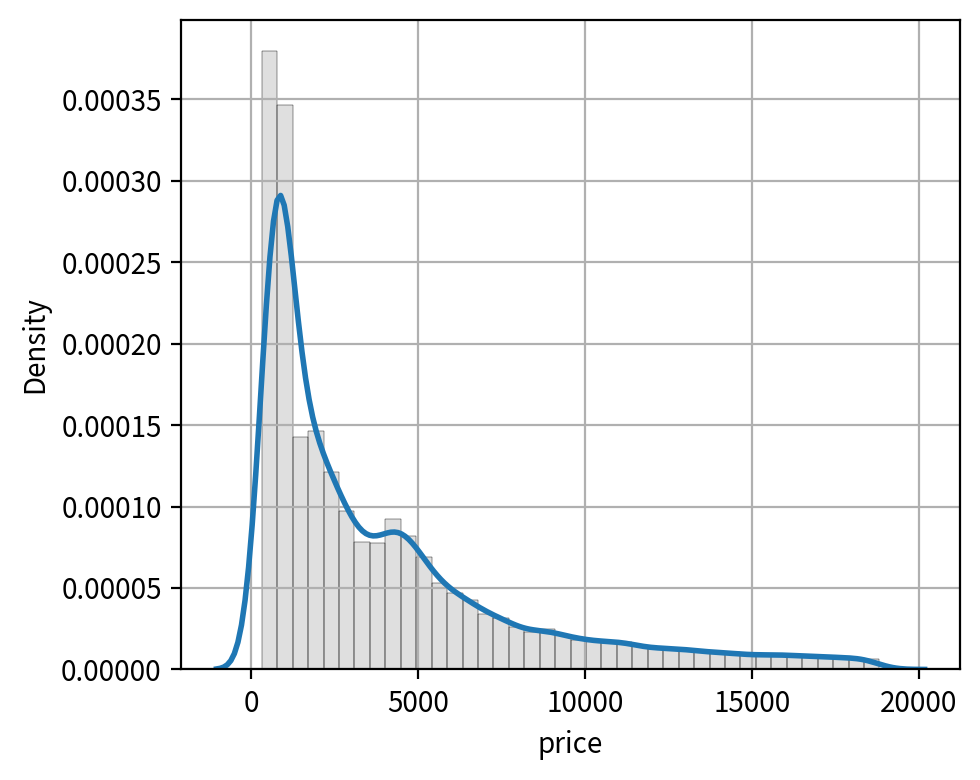

In [28]:
# 1) 그래프 초기화 (캔바스(fig)와 도화지(ax) 준비하기)
width_px = 1000
height_px = 800
rows = 1
cols = 1
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) 그래프 그리기 -> seaborn 사용
# (1) 히스토그램: alpha로 연하게 + 테두리 제거(또는 얇게)
sb.histplot(
    data=df1,
    x="price",
    bins=40,
    stat="density",
    color="grey",
    alpha=0.25,
    edgecolor="#000000",
    linewidth=0.15,
    ax=ax,
)

# (2) KDE: 선만 또는 fill을 아주 약하게
sb.kdeplot(
    data=df1,
    x="price",
    fill=False,  # 채우면 겹쳐서 진해질 수 있어 우선 False 추천
    linewidth=2,
    ax=ax,
)

# 3) 그래프 꾸미기
ax.grid(True)

plt.tight_layout()
plt.show()
plt.close()

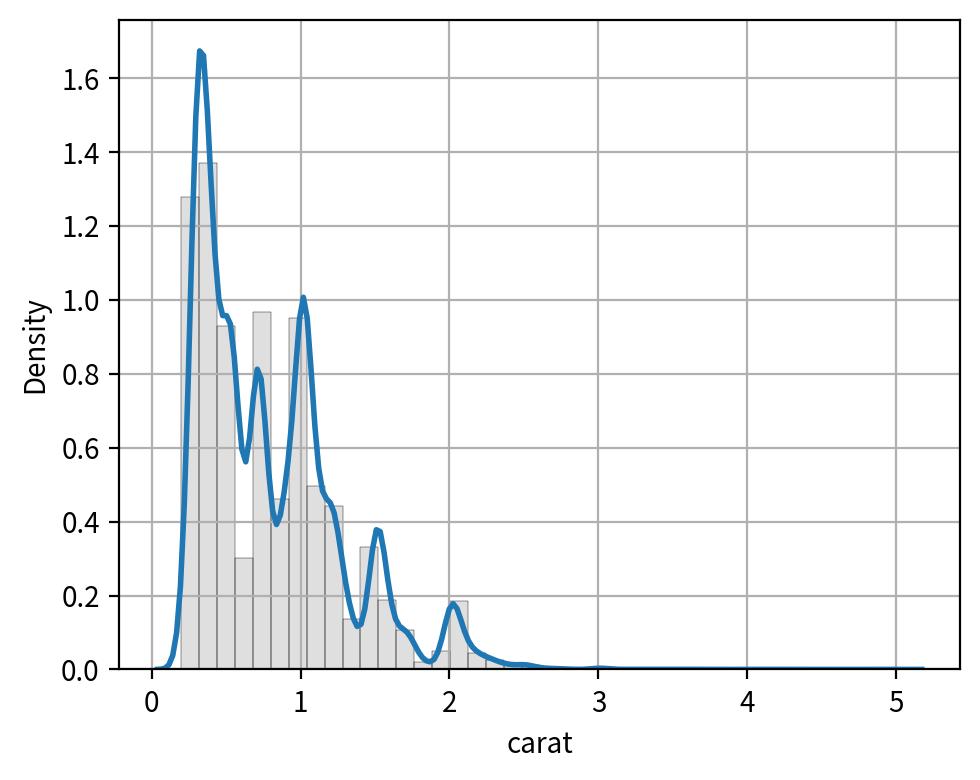

In [29]:
# 1) 그래프 초기화 (캔바스(fig)와 도화지(ax) 준비하기)
width_px = 1000
height_px = 800
rows = 1
cols = 1
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) 그래프 그리기 -> seaborn 사용
# (1) 히스토그램: alpha로 연하게 + 테두리 제거(또는 얇게)
sb.histplot(
    data=df1,
    x="carat",
    bins=40,
    stat="density",
    color="grey",
    alpha=0.25,
    edgecolor="#000000",
    linewidth=0.15,
    ax=ax,
)

# (2) KDE: 선만 또는 fill을 아주 약하게
sb.kdeplot(
    data=df1,
    x="carat",
    fill=False,  # 채우면 겹쳐서 진해질 수 있어 우선 False 추천
    linewidth=2,
    ax=ax,
)

# 3) 그래프 꾸미기
ax.grid(True)

plt.tight_layout()
plt.show()
plt.close()

price와 carat의 분포를 확인한 결과, 두 변수 모두 낮은 값에 데이터가 몰려 있고 높은 값 방향으로 꼬리가 길게 나타났다. 이런 형태는 정규분포와는 거리가 있어 보이므로, 그대로 회귀분석을 진행하면 잔차도 한쪽으로 치우쳐 해석이 어려울 수 있다. 따라서 회귀를 바로 진행하기보다는 로그 변환처럼 분포를 완화하는 방법을 검토할 필요가 있다.

## 미션 3. “로그 변환은 왜 등장할까?”

In [30]:
df2 = df1.copy()
df2["log_price"] = np.log(df2["price"])
df2["log_carat"] = np.log(df2["carat"])
df2.head()

price  carat      cut color clarity     x     y     z  depth  table  \
0    326   0.23    Ideal     E     SI2  3.95  3.98  2.43   61.5   55.0   
1    326   0.21  Premium     E     SI1  3.89  3.84  2.31   59.8   61.0   
2    327   0.23     Good     E     VS1  4.05  4.07  2.31   56.9   65.0   
3    334   0.29  Premium     I     VS2  4.20  4.23  2.63   62.4   58.0   
4    335   0.31     Good     J     SI2  4.34  4.35  2.75   63.3   58.0   

   log_price  log_carat  
0   5.786897  -1.469676  
1   5.786897  -1.560648  
2   5.789960  -1.469676  
3   5.811141  -1.237874  
4   5.814131  -1.171183

In [31]:
# 1) 그래프 초기화 (캔바스(fig)와 도화지(ax) 준비하기)
width_px = 1000
height_px = 800
rows = 1
cols = 1
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) 그래프 그리기 -> seaborn 사용
# (1) 히스토그램: alpha로 연하게 + 테두리 제거(또는 얇게)
sb.histplot(
    data=df2,
    x="log_price",
    bins=40,
    stat="density",
    color="grey",
    alpha=0.25,
    edgecolor="#000000",
    linewidth=0.15,
    ax=ax,
)

# (2) KDE: 선만 또는 fill을 아주 약하게
sb.kdeplot(
    data=df2,
    x="log_price",
    fill=False,  # 채우면 겹쳐서 진해질 수 있어 우선 False 추천
    linewidth=2,
    ax=ax,
)

# 3) 그래프 꾸미기
ax.grid(True)

plt.tight_layout()
plt.show()
plt.close()

In [32]:
# 1) 그래프 초기화 (캔바스(fig)와 도화지(ax) 준비하기)
width_px = 1000
height_px = 800
rows = 1
cols = 1
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) 그래프 그리기 -> seaborn 사용
# (1) 히스토그램: alpha로 연하게 + 테두리 제거(또는 얇게)
sb.histplot(
    data=df2,
    x="log_carat",
    bins=40,
    stat="density",
    color="grey",
    alpha=0.25,
    edgecolor="#000000",
    linewidth=0.15,
    ax=ax,
)

# (2) KDE: 선만 또는 fill을 아주 약하게
sb.kdeplot(
    data=df2,
    x="log_carat",
    fill=False,  # 채우면 겹쳐서 진해질 수 있어 우선 False 추천
    linewidth=2,
    ax=ax,
)

# 3) 그래프 꾸미기
ax.grid(True)

plt.tight_layout()
plt.show()
plt.close()

가격과 carat에 로그 변환을 한 결과 큰 값은 눌러서 작아지고, 작은 값은 상대적으로 덜 변해서 전체 분포가 더 균형 있게 보이게 된다.  
로그 변환 후 히스토그램을 보면 변환 전보다 오른쪽으로 길게 늘어진 꼬리가 줄어든 느낌이 있다. 즉, 극단적으로 큰 값의 영향이 줄었다고 볼 수 있다.  
다만 정규성 검정을 하면 p-value가 0에 가까워서 정규성은 충족 되지 않는다  
즉 로그 변환은 정규분포를 완벽하게 만들기보다는 치우친 분포를 덜 치우치게 만들고 극단값을 줄여서 이후 회귀분석을 더 안정적으로 하기 위해 사용한다.  

## 미션 4. “품질 등급은 가격을 얼마나 설명해 줄까?

In [33]:
order = {
    "cut": ["Ideal", "Premium", "Very Good", "Good", "Fair"],
    "color": ["D", "E", "F", "G", "H", "I", "J"],
    "clarity": ["IF", "VVS1", "VVS2", "VS1", "VS2", "SI1", "SI2", "I1"],
}

In [34]:
data = ["cut", "color", "clarity"]


# 1) 그래프 초기화
rows = 1
cols = len(data)
width_px = 2500
height_px = 900
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) 그래프 그리기
for i, v in enumerate(data):
    sb.boxplot(data=df2, x=v, y="log_price", order=order[v], ax=ax[i])

plt.tight_layout()
plt.show()
plt.close()

cut 기준으로는 Premium의 중앙값이 상대적으로 높고, 박스 폭도 넓어 가격 변동(분산)이 큰 편으로 보인다. Fair는 박스 폭은 비교적 좁지만 이상치가 관찰되어 일부 극단값이 존재함을 확인할 수 있다.

color는 등급 간 가격 분포가 많이 겹쳐, 색상 등급만으로 가격을 뚜렷하게 구분하기 어렵다.

clarity 역시 분포 겹침이 존재해 단독으로 가격을 완전히 가르긴 어렵지만, 세 품질 변수 중에서는 등급별 중앙값 차이가 상대적으로 더 뚜렷하게 나타나 가격 차이를 가장 잘 보여주는 변수로 관찰된다.

결론적으로, 가격 차이가 비교적 뚜렷한 품질 변수는 clarity이고, color는 등급 간 분포 겹침이 커 등급이 달라도 비슷한 가격 구간이 많이 나타난다.

## 미션 5. “Premium 컷은 정말 더 비쌀까?

독립성 t-test를 사용하여 서로 다른 두개의 그룹 간 평균의 차이가 유의미한지 여부를 판단한다.

cut에서 Premium이랑 Ideal등급인 가격정보만 따로 가져온다

In [35]:
df3 = (
    df2.query("cut == 'Premium' or cut == 'Ideal'")[["cut", "log_price"]]
    .dropna()
    .copy()
)

premium = df3.loc[df3["cut"] == "Premium", "log_price"].reset_index(drop=True)
ideal = df3.loc[df3["cut"] == "Ideal", "log_price"].reset_index(drop=True)

df4 = concat([premium, ideal], axis=1)
df4.columns = ["Premium", "Ideal"]
df4

Premium     Ideal
0      5.786897  5.786897
1      5.811141  5.828946
2      5.834811  5.840642
3      5.843544  5.852202
4      5.843544  5.998937
...         ...       ...
21480       NaN  7.921536
21481       NaN  7.921536
21482       NaN  7.921536
21483       NaN  7.921898
21484       NaN  7.921898

[21485 rows x 2 columns]

각각의 인덱스를 초기화 후 하나의 행으로 합쳤다

In [36]:
data = df4[["Premium", "Ideal"]]

equal_var_fields = []
normal_dist = True
report = []

for c in data.columns:
    x = data[c].dropna()  # 결측치 제거

    s, p = normaltest(x)
    normalize = p > 0.05

    report.append({"field": c, "statistic": s, "p-value": p, "result": normalize})

    normal_dist = normal_dist and normalize
    equal_var_fields.append(x)

# 정규성 결과에 따라 등분산 검정 선택
if normal_dist:
    n = "Bartlett"
    s, p = bartlett(*equal_var_fields)
else:
    n = "Levene"
    s, p = levene(*equal_var_fields, center="median")

equal_var = p > 0.05

report.append({"field": n, "statistic": s, "p-value": p, "result": equal_var})

report_df = DataFrame(report).set_index("field")
report_df

statistic       p-value  result
field                                     
Premium  9858.052388  0.000000e+00   False
Ideal    4653.410445  0.000000e+00   False
Levene     71.293568  3.194522e-17   False

Premium과 Ideal의 log_price에 대해 정규성 검정을 수행한 결과 두 그룹 모두 p-value≈0으로 정규성 가정이 충족되지 않았고, Levene 검정에서도 p<0.05 이므로 등분산 가정이 위배되었다.
따라서 등분산 가정 없이 평균 차이를 비교할 수 있는 Welch t-test를 적용한다.

In [37]:
s, p = ttest_ind(
    df4["Premium"].dropna(),
    df4["Ideal"].dropna(),
    equal_var=False,
    alternative="greater",
)

result = "statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(
    s, p, "대립" if p <= 0.05 else "귀무"
)
print(result)

statistic: 27.857, p-value: 0.000, 대립가설 채택


p = 3.79e-171로 (p<0.05) 귀무가설을 기각하였다. 따라서 Premium의 평균(log_price)은 Ideal보다 통계적으로 유의하게 더 크다

## 📝미션 6. “모든 컷은 서로 다를까?”

In [38]:
df6 = df2[["cut", "log_price"]].dropna().copy()
df6

cut  log_price
0          Ideal   5.786897
1        Premium   5.786897
2           Good   5.789960
3        Premium   5.811141
4           Good   5.814131
...          ...        ...
53935      Ideal   7.921898
53936       Good   7.921898
53937  Very Good   7.921898
53938    Premium   7.921898
53939      Ideal   7.921898

[53775 rows x 2 columns]

In [39]:
field = "log_price"
hue_field = "cut"

df = df6[[field, hue_field]].copy()
df["idx"] = df.groupby(hue_field).cumcount()

data = pivot_table(df, index="idx", columns=hue_field, values=field, aggfunc="first")


normal_dist = True
report = []
values = []

for c in data.columns:
    target = data[c].dropna()
    values.append(target)

    s, p = normaltest(target)
    normalize = p > 0.05
    report.append({"field": c, "statistic": s, "p-value": p, "result": normalize})
    normal_dist = normal_dist and normalize

# 등분산성
if normal_dist:
    n = "Bartlett"
    s, p = bartlett(*values)
else:
    n = "Levene"
    s, p = levene(*values, center="median")

equal_var = p > 0.05
report.append({"field": n, "statistic": s, "p-value": p, "result": equal_var})

report_df = DataFrame(report).set_index("field")
report_df

statistic        p-value  result
field                                        
Fair          5.325422   6.975886e-02    True
Good        707.152681  2.778090e-154   False
Ideal      4653.410445   0.000000e+00   False
Premium    9858.052388   0.000000e+00   False
Very Good  4677.135155   0.000000e+00   False
Levene      122.349875  3.939566e-104   False

cut별 log_price 분포에 대해 가정 검정을 수행한 결과, 대부분의 컷은 정규성이 충족되지 않았고, Levene 검정에서도 p=2.49e-104로 등분산성이 명확히 위배되었다.
따라서 등분산을 전제로 하는 일반 일원분산분석보다는, 등분산 가정 없이 컷 간 평균 차이를 검정할 수 있는 방법을 적용하는 것이 타당하다.

In [40]:
anova_df = df6[[field, hue_field]]

if equal_var:
    pg_anova = anova(data=anova_df, dv=field, between=hue_field)
else:
    pg_anova = welch_anova(data=anova_df, dv=field, between=hue_field)

display(pg_anova)

f_val = pg_anova["F"].iloc[0]
p_val = pg_anova["p-unc"].iloc[0]
print(
    "statistic: {0:.3f}, p-value: {1:.3g}, {2}가설 채택".format(
        f_val, p_val, "대립" if p_val <= 0.05 else "귀무"
    )
)

if equal_var:
    print("== Tukey HSD ==")
    hoc_df = pairwise_tukey(data=anova_df, dv=field, between=hue_field)
else:
    print("== Games-Howell ==")
    hoc_df = pairwise_gameshowell(anova_df, dv=field, between=hue_field)

display(hoc_df)

Source  ddof1        ddof2           F          p-unc       np2
0    cut      4  9493.334892  268.919636  2.605876e-219  0.017814

statistic: 268.920, p-value: 2.61e-219, 대립가설 채택
== Games-Howell ==


A          B   mean(A)   mean(B)      diff        se          T  \
0     Fair       Good  8.090289  7.840509  0.249780  0.023727  10.527108   
1     Fair      Ideal  8.090289  7.640958  0.449331  0.020303  22.131770   
2     Fair    Premium  8.090289  7.949959  0.140330  0.021060   6.663216   
3     Fair  Very Good  8.090289  7.798623  0.291666  0.021342  13.666427   
4     Good      Ideal  7.840509  7.640958  0.199551  0.015572  12.814638   
5     Good    Premium  7.840509  7.949959 -0.109450  0.016548  -6.614109   
6     Good  Very Good  7.840509  7.798623  0.041886  0.016905   2.477781   
7    Ideal    Premium  7.640958  7.949959 -0.309001  0.011093 -27.856757   
8    Ideal  Very Good  7.640958  7.798623 -0.157665  0.011618 -13.570723   
9  Premium  Very Good  7.949959  7.798623  0.151337  0.012897  11.734559   

             df          pval    hedges  
0   3445.043360  1.948108e-12  0.267979  
1   2018.137568  4.981571e-13  0.459203  
2   2327.464969  3.321803e-10  0.139562  
3   2447.897947  0.000000e+00  0.289017  
4   7340.800370  4.550804e-13  0.201506  
5   8984.457292  4.000353e-10 -0.107612  
6   9528.343382  9.574532e-02  0.041019  
7  28475.738548  0.000000e+00 -0.306785  
8  24093.884656  2.653544e-12 -0.156290  
9  25329.519422  0.000000e+00  0.146468

Welch ANOVA 결과, cut에 따라 log_price 평균은 유의하게 달라 귀무가설을 기각하였다(p = 2.74e-223). 즉, 컷 등급에 따른 가격 차이가 전반적으로 존재함이 통계적으로 확인되었다.   
평균(log_price)은 Fair(8.093) > Premium(7.950) > Good(7.842) > Very Good(7.799) > Ideal(7.639) 순으로 나타났다.   
사후검정에서는 Good–Very Good만 유의한 차이가 없었으며(p=0.072), 그 외 모든 조합은 유의했다. 따라서 유의성까지 반영한 서열은 Fair > Premium > Good ≈ Very Good > Ideal로 정리된다.   

컷 등급별 평균 가격을 단순 비교하면 Fair가 가장 높게 나타났지만, 이는 Fair 그룹의 캐럿 구성과 고가 극단값 영향으로 평균이 왜곡될 수 있다.   
 따라서 컷의 순수한 효과를 보려면 캐럿 구간을 고정하거나, 다른 변수와의 교호작용을 통한 재검증이 필요하다.

## 📝미션 7. “품질 요인들은 서로 영향을 주고받을까?”

원할한 분석을 위하여 각각의 값만 따로 데이터프레임을 뽑아 분석하기 쉽게 전처리 해주었다.

In [41]:
df7 = df2[["cut", "color", "log_price"]].copy()
df7

cut color  log_price
0          Ideal     E   5.786897
1        Premium     E   5.786897
2           Good     E   5.789960
3        Premium     I   5.811141
4           Good     J   5.814131
...          ...   ...        ...
53935      Ideal     D   7.921898
53936       Good     D   7.921898
53937  Very Good     D   7.921898
53938    Premium     H   7.921898
53939      Ideal     D   7.921898

[53775 rows x 3 columns]

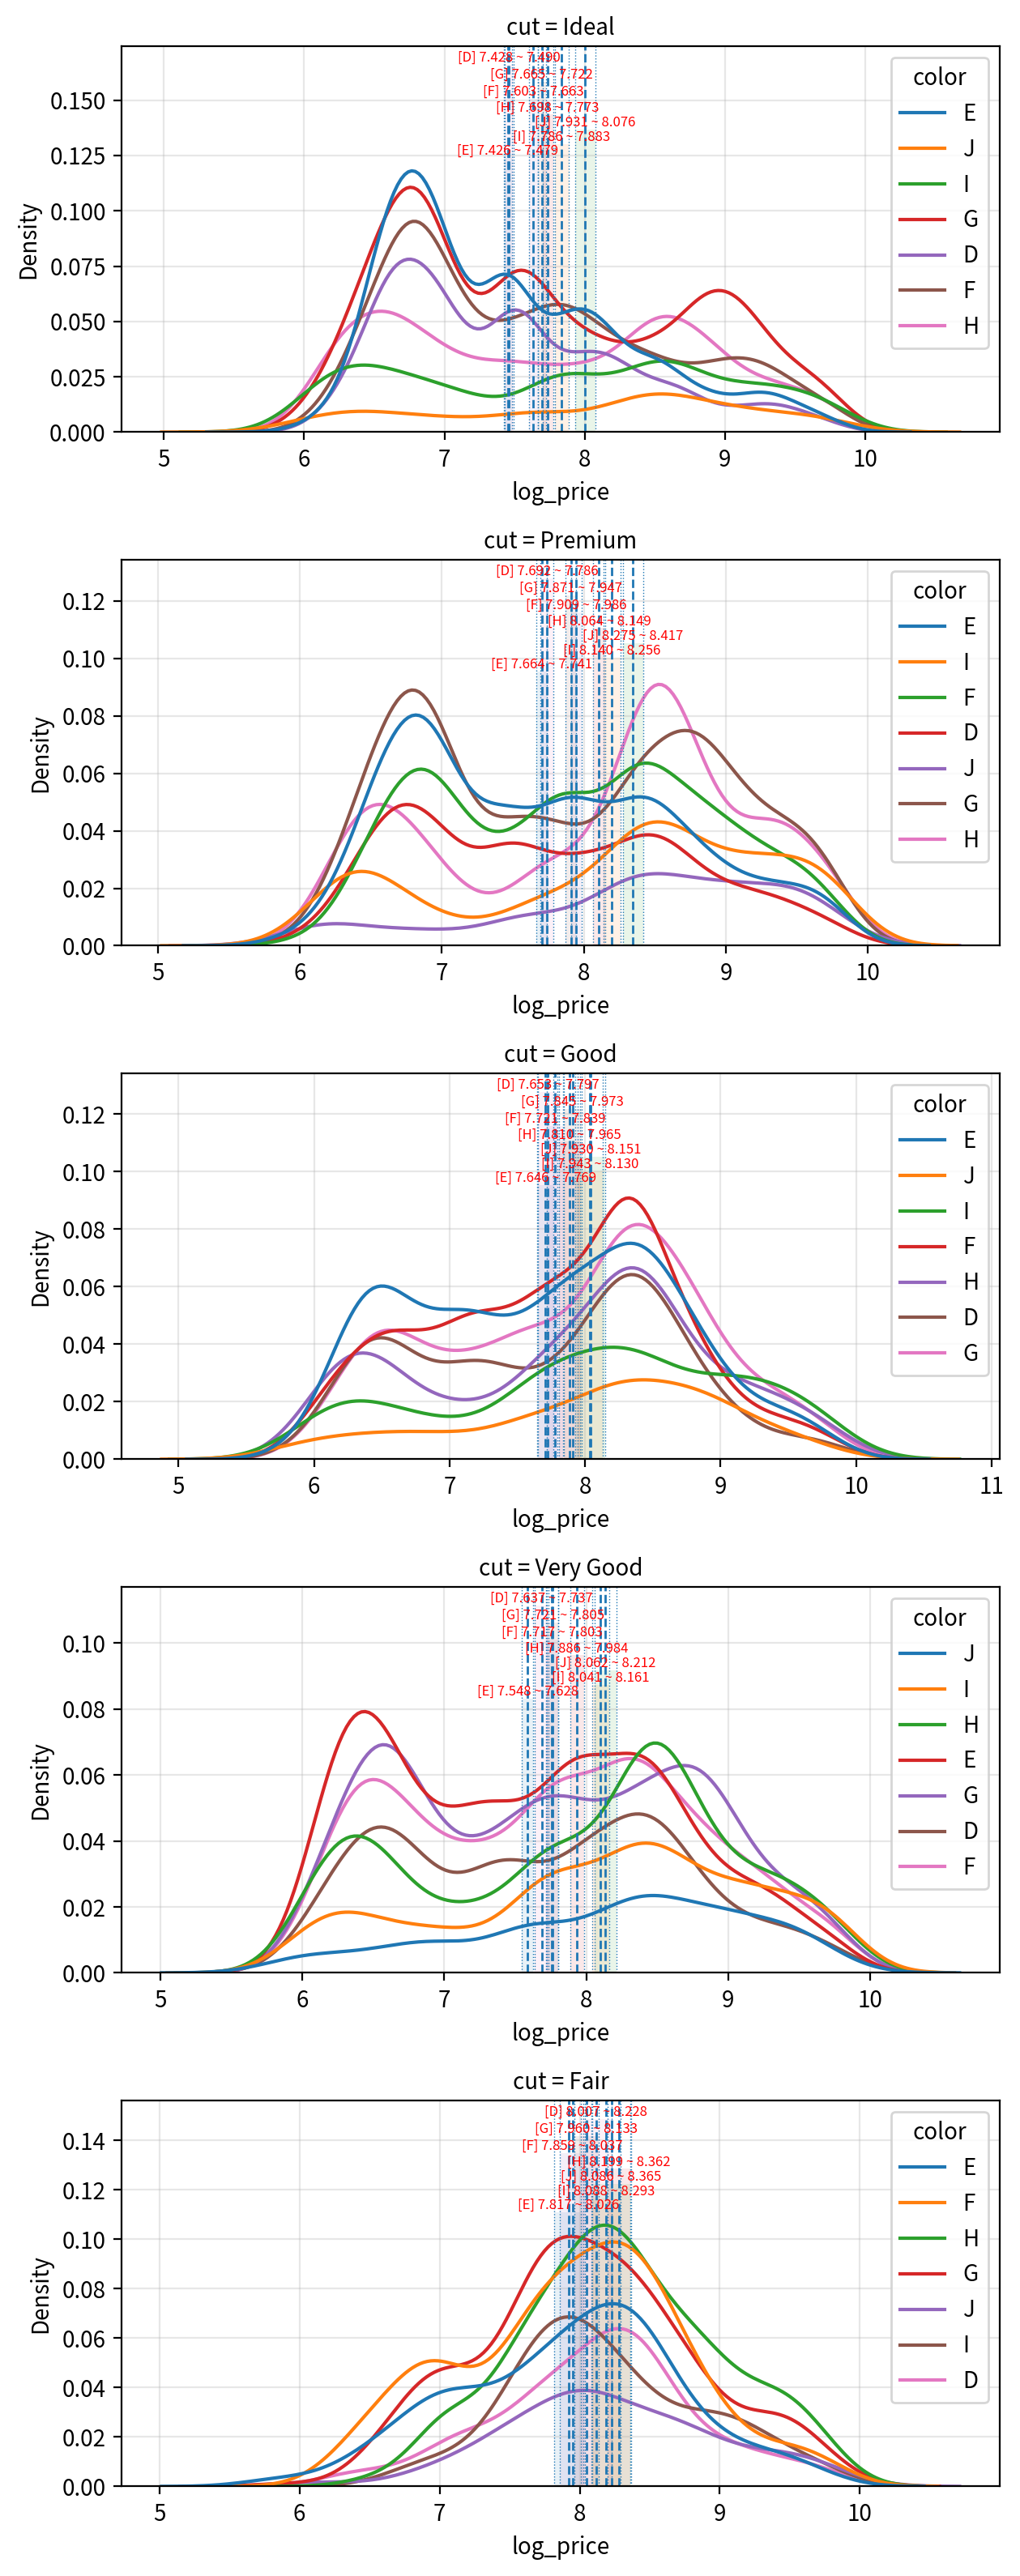

In [42]:
field = "log_price"
group_field = "cut"
hue_field = "color"


data = df2[[field, group_field, hue_field]].dropna().copy()

group_values = data[group_field].unique()
group_count = len(group_values)
hue_values = data[hue_field].unique()

# 1) 그래프 초기화
rows = group_count
cols = 1
width_px = 1280 * cols
height_px = 640 * rows
figsize = (width_px / my_dpi, height_px / my_dpi)

fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)


# 2) 그래프 그리기
for i, v in enumerate(group_values):
    temp = data[data[group_field] == v]

    # KDE Plot
    sb.kdeplot(data=temp, x=field, hue=hue_field, ax=ax[i])
    ax[i].grid(True, alpha=0.3)
    ax[i].set_title("{0} = {1}".format(group_field, v), fontsize=10, pad=5)

    for h in hue_values:
        temp_sub = temp[temp[hue_field] == h]
        n = len(temp_sub[field])

        # 표본이 너무 적으면 신뢰구간 계산 불가 → 스킵
        if n < 2:
            continue

        clevel = 0.95
        dof = n - 1
        sp_mean = temp_sub[field].mean()
        sp_std = temp_sub[field].std(ddof=1)
        sp_std_error = sp_std / sqrt(n)

        # 표준오차가 0/NaN이면 스킵
        if not (sp_std_error > 0):
            continue

        cmin, cmax = t.interval(clevel, dof, loc=sp_mean, scale=sp_std_error)

        # 신뢰구간 경계선
        ax[i].axvline(cmin, linestyle=":", linewidth=0.5)
        ax[i].axvline(cmax, linestyle=":", linewidth=0.5)

        # 평균 및 신뢰구간 영역 표시
        ymin, ymax = ax[i].get_ylim()
        ax[i].fill_between([cmin, cmax], 0, ymax, alpha=0.1)
        ax[i].axvline(sp_mean, linestyle="--", linewidth=1)

        # 텍스트
        ax[i].text(
            x=(cmax - cmin) / 2 + cmin,
            y=ymax,
            s="[%s] %0.3f ~ %0.3f" % (h, cmin, cmax),
            horizontalalignment="center",
            verticalalignment="bottom",
            fontdict={"size": 6, "color": "red"},
        )

# 4) 출력
plt.tight_layout()
plt.show()
plt.close()

In [43]:
data = df7.copy()

xname = ["cut", "color"]
yname = "log_price"

u1 = data[xname[0]].unique()
u2 = data[xname[1]].unique()

equal_var_fields = []
normal_dist = True
report = []

for i in u1:
    for j in u2:
        filtered = data[(data[xname[0]] == i) & (data[xname[1]] == j)][yname].dropna()
        if len(filtered) == 0:
            continue

        equal_var_fields.append(filtered)

        s, p = normaltest(filtered)
        normalize = p > 0.05

        report.append(
            {
                "field": "{0}={1}, {2}={3}".format(xname[0], i, xname[1], j),
                "statistic": s,
                "p-value": p,
                "result": normalize,
            }
        )

        normal_dist = normal_dist and normalize

if normal_dist:
    n = "Bartlett"
    s, p = bartlett(*equal_var_fields)
else:
    n = "Levene"
    s, p = levene(*equal_var_fields, center="median")

equal_var = p > 0.05

report.append({"field": n, "statistic": s, "p-value": p, "result": equal_var})

report_df = DataFrame(report).set_index("field")
report_df

statistic        p-value  result
field                                                      
cut=Ideal, color=E        308.571096   9.877292e-68   False
cut=Ideal, color=I       2764.050631   0.000000e+00   False
cut=Ideal, color=J        255.253793   3.735452e-56   False
cut=Ideal, color=H       4362.667241   0.000000e+00   False
cut=Ideal, color=F        529.434863  1.083129e-115   False
cut=Ideal, color=G       2468.268467   0.000000e+00   False
cut=Ideal, color=D        211.390017   1.250953e-46   False
cut=Premium, color=E      357.297112   2.593689e-78   False
cut=Premium, color=I      311.285498   2.542219e-68   False
cut=Premium, color=J       65.091277   7.338526e-15   False
cut=Premium, color=H      638.612573  2.123449e-139   False
cut=Premium, color=F      818.201710  2.136762e-178   False
cut=Premium, color=G    14916.021792   0.000000e+00   False
cut=Premium, color=D      410.691855   6.597765e-90   False
cut=Good, color=E         185.552345   5.102938e-41   False
cut=Good, color=I          65.625740   5.617609e-15   False
cut=Good, color=J          20.122864   4.269486e-05   False
cut=Good, color=H         111.148271   7.319132e-25   False
cut=Good, color=F          56.996021   4.202148e-13   False
cut=Good, color=G         124.042260   1.160287e-27   False
cut=Good, color=D         148.752382   4.998396e-33   False
cut=Very Good, color=E    653.882727  1.026053e-142   False
cut=Very Good, color=I    120.715352   6.123425e-27   False
cut=Very Good, color=J     46.487152   8.043465e-11   False
cut=Very Good, color=H    491.642246  1.742781e-107   False
cut=Very Good, color=F    606.367121  2.133303e-132   False
cut=Very Good, color=G   1653.002417   0.000000e+00   False
cut=Very Good, color=D    382.880686   7.219636e-84   False
cut=Fair, color=E           2.070356   3.551631e-01    True
cut=Fair, color=I           3.705958   1.567695e-01    True
cut=Fair, color=J           0.003373   9.983151e-01    True
cut=Fair, color=H           4.366171   1.126933e-01    True
cut=Fair, color=F           5.104536   7.790477e-02    True
cut=Fair, color=G           2.909528   2.334554e-01    True
cut=Fair, color=D           0.880055   6.440189e-01    True
Levene                     39.373034  3.996619e-256   False

In [44]:
xname = ["cut", "color"]
yname = "log_price"
data = df7[xname + [yname]]

pg_anova = anova(data=data, dv=yname, between=xname, detailed=True)
display(pg_anova)

for idx in pg_anova.index:
    row = pg_anova.iloc[idx]
    source = row["Source"]
    p_val = row["p-unc"]

    if p_val <= 0.05:
        print(f"→ {source} 효과는 유의함. (대립가설 채택: p ≤ 0.05)")
    else:
        print(f"→ {source} 효과는 유의하지 않음. (귀무가설 채택: p > 0.05)")

Source            SS       DF          MS           F          p-unc  \
0          cut    882.570850      4.0  220.642712  224.008090  4.768926e-191   
1        color   1312.829796      6.0  218.804966  222.142313  2.703293e-281   
2  cut * color     94.129853     24.0    3.922077    3.981899   1.739256e-10   
3     Residual  52932.639061  53740.0    0.984977         NaN            NaN   

        np2  
0  0.016400  
1  0.024202  
2  0.001775  
3       NaN

→ cut 효과는 유의함. (대립가설 채택: p ≤ 0.05)
→ color 효과는 유의함. (대립가설 채택: p ≤ 0.05)
→ cut * color 효과는 유의함. (대립가설 채택: p ≤ 0.05)
→ Residual 효과는 유의하지 않음. (귀무가설 채택: p > 0.05)


In [45]:
xname = ["cut", "color"]
yname = "log_price"

data = df7[xname + [yname]]

levels = {}  # 빈 딕셔너리 만들기
# 예: {'water': 2, 'sun': 3} 이런 식 결과
for factor in xname:  # 요인을 하나씩 꺼냄
    level_count = data[factor].nunique()  # 요인의 수준 수 계산
    levels[factor] = level_count  # 딕셔너리에 저장

pvals = {}  # 빈 딕셔너리 만들기
# 예: {'water': 1.30e-20, 'sun': 2.01e-17, 'water * sun': 0.105}
for index, row in pg_anova.iterrows():  # 행을 하나씩 꺼냄
    source_name = row["Source"]  # 요인 이름
    p_value = row["p-unc"]  # 각 요인의 p-value
    pvals[source_name] = p_value  # 딕셔너리에 저장

# 주효과 사후검정
for factor in xname:
    print(f"\n[{factor}]")

    # 수준이 2개면 사후검정 필요 없음
    if levels[factor] == 2:
        print(f"- {levels[factor]}수준 요인이므로 사후검정이 필요 없습니다.")
        continue

    p_val = pvals.get(factor, None)
    if p_val is None:
        print("- ANOVA 결과에서 해당 요인을 찾을 수 없습니다.")
        continue

    if p_val > 0.05:
        print(f"- 주효과 유의하지 않음 (p={p_val:.3g}) → 사후검정 수행 안 함")
        continue

    print(f"- 주효과 유의 (p={p_val:.3g}) → 사후검정 수행")

    if equal_var:
        print(" · Tukey HSD 사용 (등분산 충족)")
        hoc_df = pairwise_tukey(data=data, dv=yname, between=factor)
    else:
        print(" · Games–Howell 사용 (등분산 불충족)")
        hoc_df = pairwise_gameshowell(data=data, dv=yname, between=factor)

    display(hoc_df)

# 상호작용 자동 처리
interaction_names = [src for src in pvals.keys() if "*" in src]

for inter in interaction_names:
    p_val = pvals[inter]
    print(f"\n[{inter}] 상호작용 효과")

    if p_val <= 0.05:
        print(f"- 상호작용 유의 (p={p_val:.3g}) → 단순주효과 분석 필요")
    else:
        print(f"- 상호작용 유의하지 않음 (p={p_val:.3g}) → 단순주효과 분석 필요 없음")


[cut]
- 주효과 유의 (p=4.77e-191) → 사후검정 수행
 · Games–Howell 사용 (등분산 불충족)


A          B   mean(A)   mean(B)      diff        se          T  \
0     Fair       Good  8.090289  7.840509  0.249780  0.023727  10.527108   
1     Fair      Ideal  8.090289  7.640958  0.449331  0.020303  22.131770   
2     Fair    Premium  8.090289  7.949959  0.140330  0.021060   6.663216   
3     Fair  Very Good  8.090289  7.798623  0.291666  0.021342  13.666427   
4     Good      Ideal  7.840509  7.640958  0.199551  0.015572  12.814638   
5     Good    Premium  7.840509  7.949959 -0.109450  0.016548  -6.614109   
6     Good  Very Good  7.840509  7.798623  0.041886  0.016905   2.477781   
7    Ideal    Premium  7.640958  7.949959 -0.309001  0.011093 -27.856757   
8    Ideal  Very Good  7.640958  7.798623 -0.157665  0.011618 -13.570723   
9  Premium  Very Good  7.949959  7.798623  0.151337  0.012897  11.734559   

             df          pval    hedges  
0   3445.043360  1.948108e-12  0.267979  
1   2018.137568  4.981571e-13  0.459203  
2   2327.464969  3.321803e-10  0.139562  
3   2447.897947  0.000000e+00  0.289017  
4   7340.800370  4.550804e-13  0.201506  
5   8984.457292  4.000353e-10 -0.107612  
6   9528.343382  9.574532e-02  0.041019  
7  28475.738548  0.000000e+00 -0.306785  
8  24093.884656  2.653544e-12 -0.156290  
9  25329.519422  0.000000e+00  0.146468


[color]
- 주효과 유의 (p=2.7e-281) → 사후검정 수행
 · Games–Howell 사용 (등분산 불충족)


A  B   mean(A)   mean(B)      diff        se          T            df  \
0   D  E  7.618173  7.580117  0.038056  0.014652   2.597212  14515.582383   
1   D  F  7.618173  7.762781 -0.144609  0.015014  -9.631319  14916.864602   
2   D  G  7.618173  7.789751 -0.171579  0.014861 -11.545292  15379.789166   
3   D  H  7.618173  7.917375 -0.299202  0.016231 -18.434102  14954.249959   
4   D  I  7.618173  8.020211 -0.402038  0.018794 -21.391367  10523.292778   
5   D  J  7.618173  8.147775 -0.529603  0.022595 -23.439374   4747.645070   
6   E  F  7.580117  7.762781 -0.182664  0.013642 -13.390158  19193.887347   
7   E  G  7.580117  7.789751 -0.209634  0.013473 -15.559550  21000.149239   
8   E  H  7.580117  7.917375 -0.337258  0.014970 -22.528700  16529.605620   
9   E  I  7.580117  8.020211 -0.440094  0.017717 -24.840170   9608.691599   
10  E  J  7.580117  8.147775 -0.567658  0.021707 -26.151383   4165.794903   
11  F  G  7.762781  7.789751 -0.026970  0.013866  -1.945079  20530.433601   
12  F  H  7.762781  7.917375 -0.154594  0.015325 -10.087959  16866.993555   
13  F  I  7.762781  8.020211 -0.257430  0.018018 -14.287763  10050.514889   
14  F  J  7.762781  8.147775 -0.384994  0.021953 -17.537551   4338.982695   
15  G  H  7.789751  7.917375 -0.127624  0.015175  -8.410324  17473.651581   
16  G  I  7.789751  8.020211 -0.230460  0.017890 -12.881935   9993.562714   
17  G  J  7.789751  8.147775 -0.358024  0.021848 -16.386924   4275.821022   
18  H  I  7.917375  8.020211 -0.102836  0.019043  -5.400176  11221.199113   
19  H  J  7.917375  8.147775 -0.230401  0.022802 -10.104463   4936.608079   
20  I  J  8.020211  8.147775 -0.127564  0.024692  -5.166148   5998.441032   

            pval    hedges  
0   1.267697e-01  0.041096  
1   0.000000e+00 -0.152092  
2   0.000000e+00 -0.173158  
3   0.000000e+00 -0.298239  
4   6.181611e-12 -0.398023  
5   1.591172e-12 -0.551687  
6   3.663736e-14 -0.192929  
7   6.617262e-12 -0.213547  
8   0.000000e+00 -0.340476  
9   2.900347e-12 -0.442875  
10  0.000000e+00 -0.596485  
11  4.502827e-01 -0.026951  
12  0.000000e+00 -0.152657  
13  0.000000e+00 -0.252378  
14  1.362688e-12 -0.391283  
15  0.000000e+00 -0.122437  
16  3.828604e-12 -0.218710  
17  0.000000e+00 -0.347760  
18  1.417119e-06 -0.095257  
19  1.368905e-13 -0.218254  
20  5.126327e-06 -0.117808


[cut * color] 상호작용 효과
- 상호작용 유의 (p=1.74e-10) → 단순주효과 분석 필요


log_price(가격)에 대해 cut(컷 등급), color가 각각 어떤 영향을 미치는지와, 또 cut, clarity에 대한 두 요인이 함께 작용할 때를 검증하기 위해 이원 분산분석(2-way ANOVA)을 수행하였다.

cut * color 사후검정(Games–Howell) 결과, 평균(log_price) 차이는 대부분의 조합에서 유의했다(p≤0.05).
평균값(mean) 기준으로는 J(8.146) > I(8.023) > H(7.917) > G(7.789) > F(7.762) > D(7.617) > E(7.579) 순으로 나타난다.
따라서 color는 가격(log_price) 수준을 구분하는 데 의미가 있다.

In [46]:
df8 = df2[["cut", "clarity", "log_price"]].copy()
df8

cut clarity  log_price
0          Ideal     SI2   5.786897
1        Premium     SI1   5.786897
2           Good     VS1   5.789960
3        Premium     VS2   5.811141
4           Good     SI2   5.814131
...          ...     ...        ...
53935      Ideal     SI1   7.921898
53936       Good     SI1   7.921898
53937  Very Good     SI1   7.921898
53938    Premium     SI2   7.921898
53939      Ideal     SI2   7.921898

[53775 rows x 3 columns]

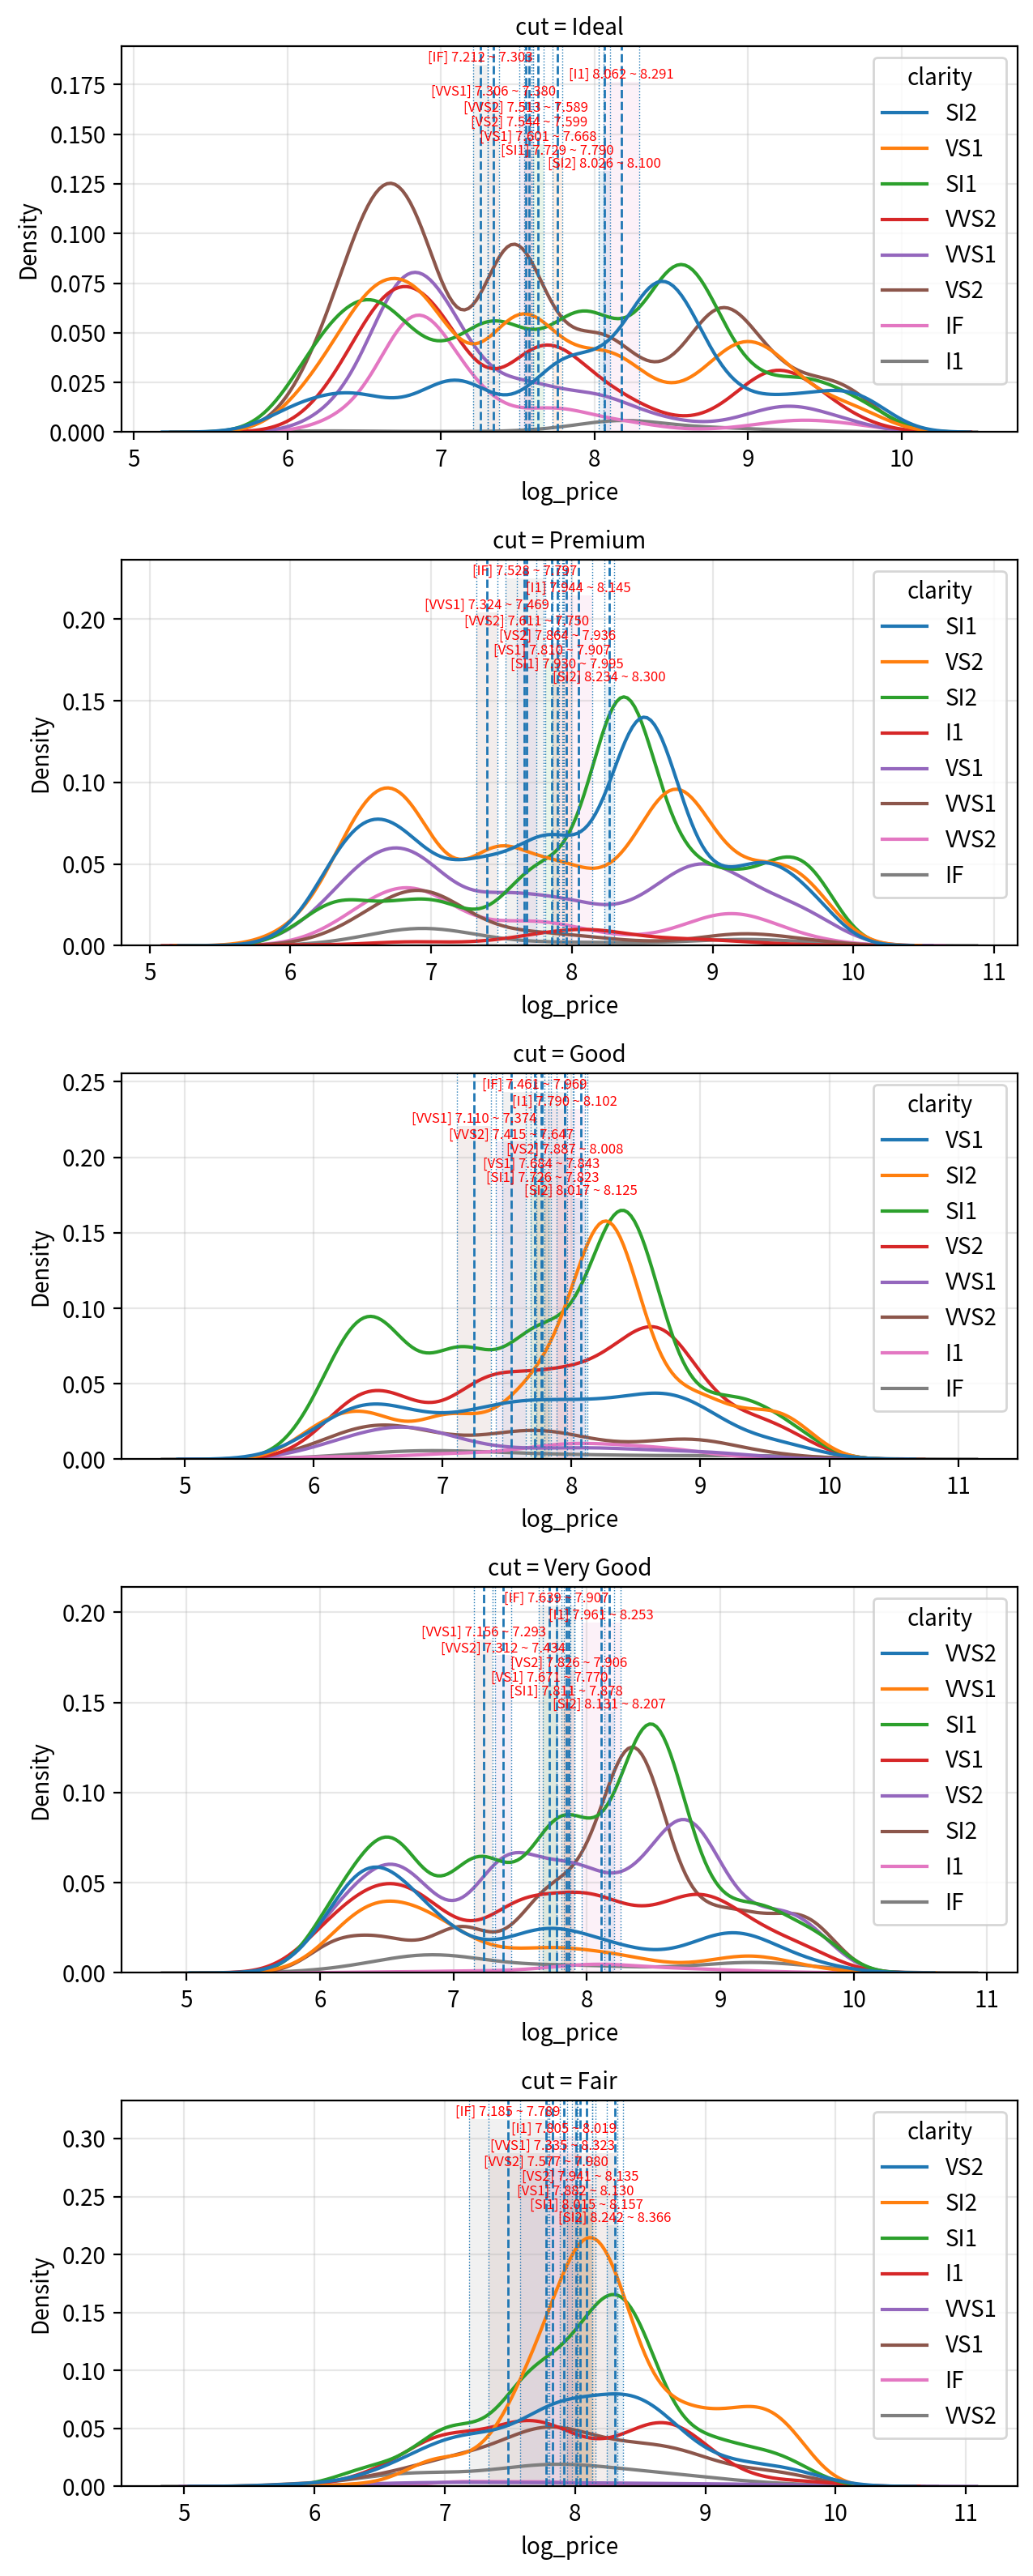

In [47]:
field = "log_price"
group_field = "cut"
hue_field = "clarity"


data = df2[[field, group_field, hue_field]].dropna().copy()

group_values = data[group_field].unique()
group_count = len(group_values)
hue_values = data[hue_field].unique()

# 1) 그래프 초기화
rows = group_count
cols = 1
width_px = 1280 * cols
height_px = 640 * rows
figsize = (width_px / my_dpi, height_px / my_dpi)

fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)


# 2) 그래프 그리기
for i, v in enumerate(group_values):
    temp = data[data[group_field] == v]

    # KDE Plot
    sb.kdeplot(data=temp, x=field, hue=hue_field, ax=ax[i])
    ax[i].grid(True, alpha=0.3)
    ax[i].set_title("{0} = {1}".format(group_field, v), fontsize=10, pad=5)

    for h in hue_values:
        temp_sub = temp[temp[hue_field] == h]
        n = len(temp_sub[field])

        # 표본이 너무 적으면 신뢰구간 계산 불가 → 스킵
        if n < 2:
            continue

        clevel = 0.95
        dof = n - 1
        sp_mean = temp_sub[field].mean()
        sp_std = temp_sub[field].std(ddof=1)
        sp_std_error = sp_std / sqrt(n)

        if not (sp_std_error > 0):
            continue

        cmin, cmax = t.interval(clevel, dof, loc=sp_mean, scale=sp_std_error)

        # 신뢰구간 경계선
        ax[i].axvline(cmin, linestyle=":", linewidth=0.5)
        ax[i].axvline(cmax, linestyle=":", linewidth=0.5)

        # 평균 및 신뢰구간 영역 표시
        ymin, ymax = ax[i].get_ylim()
        ax[i].fill_between([cmin, cmax], 0, ymax, alpha=0.1)
        ax[i].axvline(sp_mean, linestyle="--", linewidth=1)

        # 텍스트
        ax[i].text(
            x=(cmax - cmin) / 2 + cmin,
            y=ymax,
            s="[%s] %0.3f ~ %0.3f" % (h, cmin, cmax),
            horizontalalignment="center",
            verticalalignment="bottom",
            fontdict={"size": 6, "color": "red"},
        )

# 4) 출력
plt.tight_layout()
plt.show()
plt.close()

In [48]:
xname = ["cut", "clarity"]
yname = "log_price"
data = df8[xname + [yname]]

pg_anova = anova(data=data, dv=yname, between=xname, detailed=True)
display(pg_anova)

for idx in pg_anova.index:
    row = pg_anova.iloc[idx]
    source = row["Source"]
    p_val = row["p-unc"]

    if p_val <= 0.05:
        print(f"→ {source} 효과는 유의함. (대립가설 채택: p ≤ 0.05)")
    else:
        print(f"→ {source} 효과는 유의하지 않음. (귀무가설 채택: p > 0.05)")

Source            SS       DF          MS           F  \
0            cut    458.689464      4.0  114.672366  119.056605   
1        clarity   2282.813705      7.0  326.116244  338.584563   
2  cut * clarity    300.567361     28.0   10.734549   11.144960   
3       Residual  51756.217644  53735.0    0.963175         NaN   

           p-unc       np2  
0  2.624736e-101  0.008785  
1   0.000000e+00  0.042244  
2   1.435389e-49  0.005774  
3            NaN       NaN

→ cut 효과는 유의함. (대립가설 채택: p ≤ 0.05)
→ clarity 효과는 유의함. (대립가설 채택: p ≤ 0.05)
→ cut * clarity 효과는 유의함. (대립가설 채택: p ≤ 0.05)
→ Residual 효과는 유의하지 않음. (귀무가설 채택: p > 0.05)


In [49]:
xname = ["cut", "clarity"]
yname = "log_price"

data = df8[xname + [yname]]

levels = {}  # 빈 딕셔너리 만들기
# 예: {'water': 2, 'sun': 3} 이런 식 결과
for factor in xname:  # 요인을 하나씩 꺼냄
    level_count = data[factor].nunique()  # 요인의 수준 수 계산
    levels[factor] = level_count  # 딕셔너리에 저장

pvals = {}  # 빈 딕셔너리 만들기
# 예: {'water': 1.30e-20, 'sun': 2.01e-17, 'water * sun': 0.105}
for index, row in pg_anova.iterrows():  # 행을 하나씩 꺼냄
    source_name = row["Source"]  # 요인 이름
    p_value = row["p-unc"]  # 각 요인의 p-value
    pvals[source_name] = p_value  # 딕셔너리에 저장

# 주효과 사후검정
for factor in xname:
    print(f"\n[{factor}]")

    # 수준이 2개면 사후검정 필요 없음
    if levels[factor] == 2:
        print(f"- {levels[factor]}수준 요인이므로 사후검정이 필요 없습니다.")
        continue

    p_val = pvals.get(factor, None)
    if p_val is None:
        print("- ANOVA 결과에서 해당 요인을 찾을 수 없습니다.")
        continue

    if p_val > 0.05:
        print(f"- 주효과 유의하지 않음 (p={p_val:.3g}) → 사후검정 수행 안 함")
        continue

    print(f"- 주효과 유의 (p={p_val:.3g}) → 사후검정 수행")

    if equal_var:
        print(" · Tukey HSD 사용 (등분산 충족)")
        hoc_df = pairwise_tukey(data=data, dv=yname, between=factor)
    else:
        print(" · Games–Howell 사용 (등분산 불충족)")
        hoc_df = pairwise_gameshowell(data=data, dv=yname, between=factor)

    display(hoc_df)

# 상호작용 자동 처리
interaction_names = [src for src in pvals.keys() if "*" in src]

for inter in interaction_names:
    p_val = pvals[inter]
    print(f"\n[{inter}] 상호작용 효과")

    if p_val <= 0.05:
        print(f"- 상호작용 유의 (p={p_val:.3g}) → 단순주효과 분석 필요")
    else:
        print(f"- 상호작용 유의하지 않음 (p={p_val:.3g}) → 단순주효과 분석 필요 없음")


[cut]
- 주효과 유의 (p=2.62e-101) → 사후검정 수행
 · Games–Howell 사용 (등분산 불충족)


A          B   mean(A)   mean(B)      diff        se          T  \
0     Fair       Good  8.090289  7.840509  0.249780  0.023727  10.527108   
1     Fair      Ideal  8.090289  7.640958  0.449331  0.020303  22.131770   
2     Fair    Premium  8.090289  7.949959  0.140330  0.021060   6.663216   
3     Fair  Very Good  8.090289  7.798623  0.291666  0.021342  13.666427   
4     Good      Ideal  7.840509  7.640958  0.199551  0.015572  12.814638   
5     Good    Premium  7.840509  7.949959 -0.109450  0.016548  -6.614109   
6     Good  Very Good  7.840509  7.798623  0.041886  0.016905   2.477781   
7    Ideal    Premium  7.640958  7.949959 -0.309001  0.011093 -27.856757   
8    Ideal  Very Good  7.640958  7.798623 -0.157665  0.011618 -13.570723   
9  Premium  Very Good  7.949959  7.798623  0.151337  0.012897  11.734559   

             df          pval    hedges  
0   3445.043360  1.948108e-12  0.267979  
1   2018.137568  4.981571e-13  0.459203  
2   2327.464969  3.321803e-10  0.139562  
3   2447.897947  0.000000e+00  0.289017  
4   7340.800370  4.550804e-13  0.201506  
5   8984.457292  4.000353e-10 -0.107612  
6   9528.343382  9.574532e-02  0.041019  
7  28475.738548  0.000000e+00 -0.306785  
8  24093.884656  2.653544e-12 -0.156290  
9  25329.519422  0.000000e+00  0.146468


[clarity]
- 주효과 유의 (p=0) → 사후검정 수행
 · Games–Howell 사용 (등분산 불충족)


A     B   mean(A)   mean(B)      diff        se          T  \
0     I1    IF  8.027337  7.406446  0.620891  0.034991  17.744403   
1     I1   SI1  8.027337  7.847979  0.179358  0.028714   6.246416   
2     I1   SI2  8.027337  8.165532 -0.138195  0.029007  -4.764135   
3     I1   VS1  8.027337  7.725674  0.301663  0.029724  10.148744   
4     I1   VS2  8.027337  7.763671  0.263666  0.028926   9.115057   
5     I1  VVS1  8.027337  7.323430  0.703907  0.031121  22.618445   
6     I1  VVS2  8.027337  7.531702  0.495635  0.030938  16.020472   
7     IF   SI1  7.406446  7.847979 -0.441533  0.023450 -18.828438   
8     IF   SI2  7.406446  8.165532 -0.759086  0.023809 -31.882393   
9     IF   VS1  7.406446  7.725674 -0.319228  0.024677 -12.936150   
10    IF   VS2  7.406446  7.763671 -0.357225  0.023710 -15.066248   
11    IF  VVS1  7.406446  7.323430  0.083016  0.026343   3.151350   
12    IF  VVS2  7.406446  7.531702 -0.125256  0.026126  -4.794289   
13   SI1   SI2  7.847979  8.165532 -0.317553  0.012922 -24.573831   
14   SI1   VS1  7.847979  7.725674  0.122305  0.014460   8.458246   
15   SI1   VS2  7.847979  7.763671  0.084308  0.012740   6.617748   
16   SI1  VVS1  7.847979  7.323430  0.524549  0.017149  30.588534   
17   SI1  VVS2  7.847979  7.531702  0.316277  0.016814  18.810819   
18   SI2   VS1  8.165532  7.725674  0.439858  0.015034  29.256636   
19   SI2   VS2  8.165532  7.763671  0.401861  0.013388  30.015731   
20   SI2  VVS1  8.165532  7.323430  0.842102  0.017636  47.749639   
21   SI2  VVS2  8.165532  7.531702  0.633830  0.017310  36.615925   
22   VS1   VS2  7.725674  7.763671 -0.037997  0.014878  -2.553943   
23   VS1  VVS1  7.725674  7.323430  0.402244  0.018791  21.405663   
24   VS1  VVS2  7.725674  7.531702  0.193972  0.018486  10.492750   
25   VS2  VVS1  7.763671  7.323430  0.440241  0.017502  25.153247   
26   VS2  VVS2  7.763671  7.531702  0.231969  0.017174  13.506769   
27  VVS1  VVS2  7.323430  7.531702 -0.208272  0.020657 -10.082195   

              df          pval    hedges  
0    1684.983002  0.000000e+00  0.711501  
1     890.216775  1.816305e-08  0.183546  
2     926.592970  5.991331e-05 -0.152666  
3    1019.924542  0.000000e+00  0.294574  
4     916.657672  0.000000e+00  0.258809  
5    1208.269133  0.000000e+00  0.808745  
6    1187.133740  2.690070e-13  0.498885  
7    2382.684499  0.000000e+00 -0.450186  
8    2522.009603  0.000000e+00 -0.827275  
9    2881.590505  1.264544e-13 -0.311636  
10   2486.357424  1.033840e-12 -0.350435  
11   3448.329282  3.502545e-02  0.091965  
12   3450.652451  4.649030e-05 -0.125422  
13  20545.161618  7.153167e-12 -0.330857  
14  16583.057246  1.481892e-11  0.120972  
15  24964.678081  1.041004e-09  0.083441  
16   6360.472178  6.754597e-13  0.541462  
17   8915.381766  0.000000e+00  0.316616  
18  16325.333709  0.000000e+00  0.448946  
19  20749.282212  0.000000e+00  0.407971  
20   6865.616588  0.000000e+00  0.924958  
21   9493.901652  0.000000e+00  0.662480  
22  17327.851283  1.732000e-01 -0.036603  
23   8113.497187  2.060685e-12  0.401758  
24  10877.871504  0.000000e+00  0.186921  
25   6806.119097  1.176836e-12  0.439045  
26   9502.686357  2.031708e-14  0.225083  
27   8392.989391  0.000000e+00 -0.214262


[cut * clarity] 상호작용 효과
- 상호작용 유의 (p=1.44e-49) → 단순주효과 분석 필요


cut * clarity 이원분산 사후검정(Games–Howell) 결과, 평균(log_price) 차이는 대부분의 조합에서 유의하였다.(p≤0.05).
평균값(mean) 기준으로는 SI2(8.166) > I1(8.027) > SI1(7.848) > VS2(7.763) > VS1(7.725) > VVS2(7.531) > IF(7.405) > VVS1(7.322) 순으로 나타난다.
따라서 [cut × clarity] 상호작용 효과는 유의하였다(p=2.56e-49).

In [50]:
dff = df2[["color", "clarity", "log_price"]].copy()
dff

color clarity  log_price
0         E     SI2   5.786897
1         E     SI1   5.786897
2         E     VS1   5.789960
3         I     VS2   5.811141
4         J     SI2   5.814131
...     ...     ...        ...
53935     D     SI1   7.921898
53936     D     SI1   7.921898
53937     D     SI1   7.921898
53938     H     SI2   7.921898
53939     D     SI2   7.921898

[53775 rows x 3 columns]

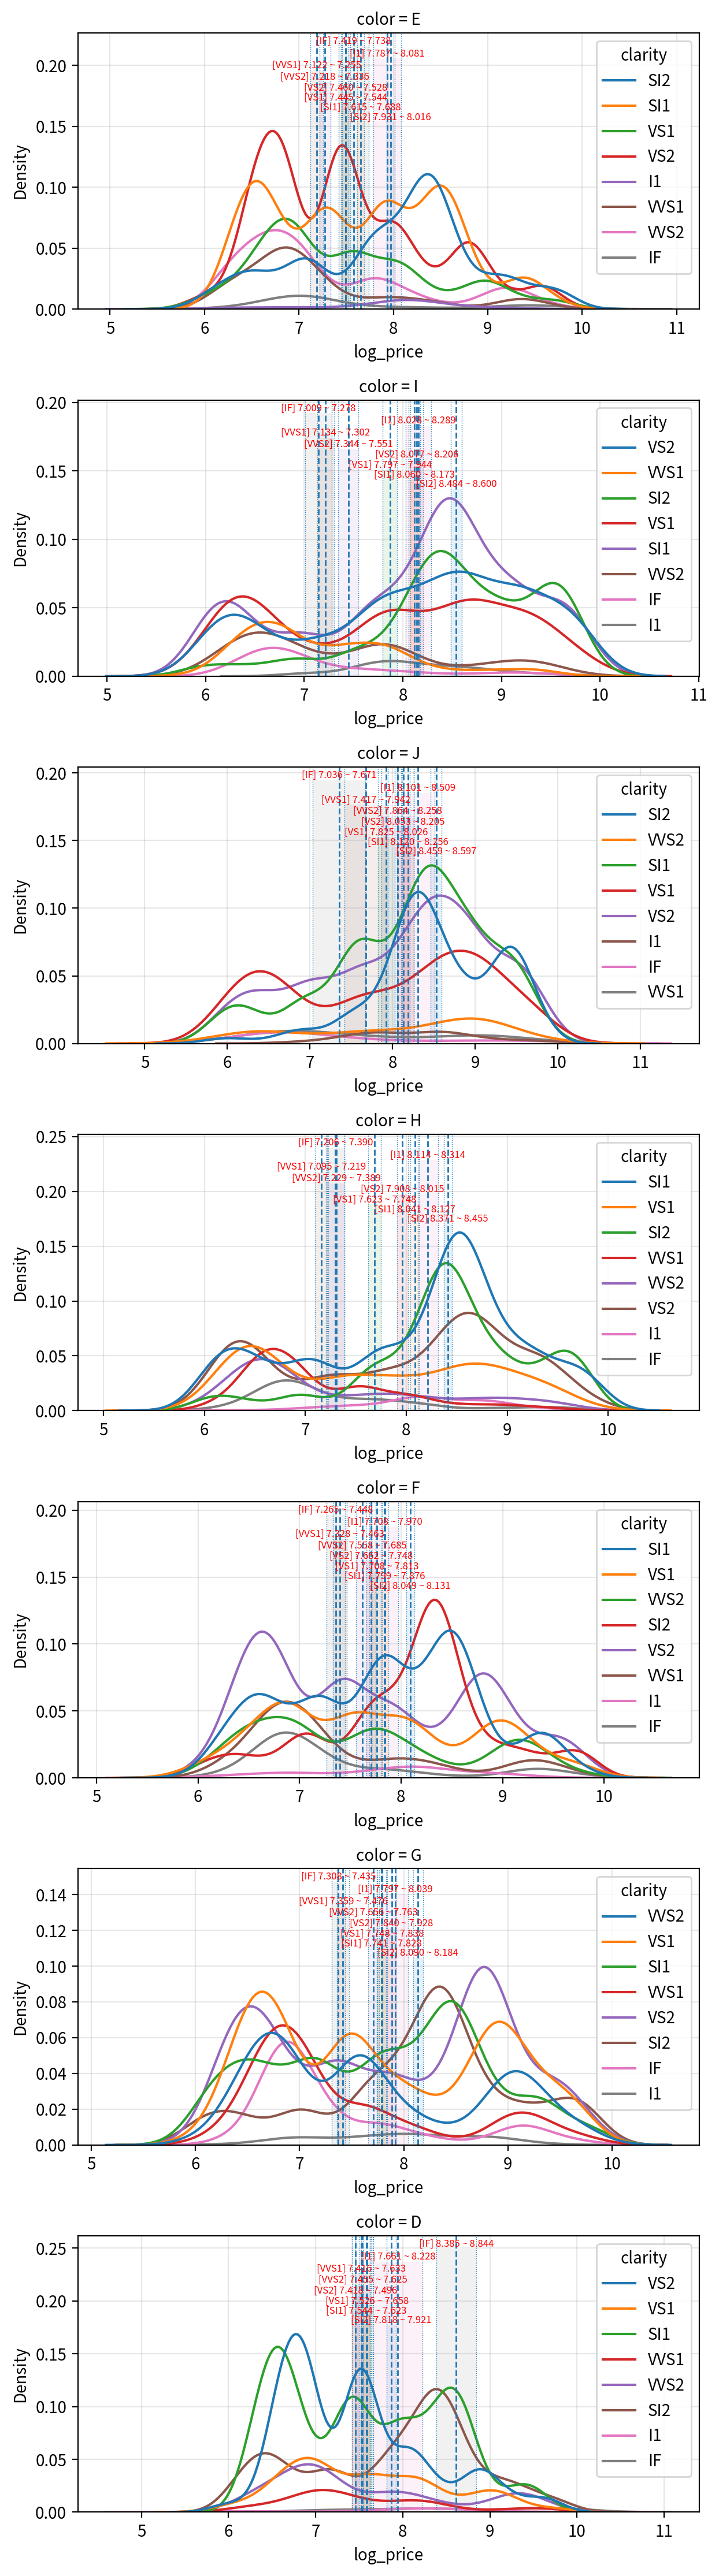

In [51]:
field = "log_price"
group_field = "color"
hue_field = "clarity"


data = dff[[field, group_field, hue_field]].dropna().copy()

group_values = data[group_field].unique()
group_count = len(group_values)
hue_values = data[hue_field].unique()

# 1) 그래프 초기화
rows = group_count
cols = 1
width_px = 1280 * cols
height_px = 640 * rows
figsize = (width_px / my_dpi, height_px / my_dpi)

fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)


# 2) 그래프 그리기
for i, v in enumerate(group_values):
    temp = data[data[group_field] == v]

    # KDE Plot
    sb.kdeplot(data=temp, x=field, hue=hue_field, ax=ax[i])
    ax[i].grid(True, alpha=0.3)
    ax[i].set_title("{0} = {1}".format(group_field, v), fontsize=10, pad=5)

    for h in hue_values:
        temp_sub = temp[temp[hue_field] == h]
        n = len(temp_sub[field])

        # 표본이 너무 적으면 신뢰구간 계산 불가 → 스킵
        if n < 2:
            continue

        clevel = 0.95
        dof = n - 1
        sp_mean = temp_sub[field].mean()
        sp_std = temp_sub[field].std(ddof=1)
        sp_std_error = sp_std / sqrt(n)

        if not (sp_std_error > 0):
            continue

        cmin, cmax = t.interval(clevel, dof, loc=sp_mean, scale=sp_std_error)

        # 신뢰구간 경계선
        ax[i].axvline(cmin, linestyle=":", linewidth=0.5)
        ax[i].axvline(cmax, linestyle=":", linewidth=0.5)

        # 평균 및 신뢰구간 영역 표시
        ymin, ymax = ax[i].get_ylim()
        ax[i].fill_between([cmin, cmax], 0, ymax, alpha=0.1)
        ax[i].axvline(sp_mean, linestyle="--", linewidth=1)

        # 텍스트
        ax[i].text(
            x=(cmax - cmin) / 2 + cmin,
            y=ymax,
            s="[%s] %0.3f ~ %0.3f" % (h, cmin, cmax),
            horizontalalignment="center",
            verticalalignment="bottom",
            fontdict={"size": 6, "color": "red"},
        )

# 4) 출력
plt.tight_layout()
plt.show()
plt.close()

In [52]:
xname = ["color", "clarity"]
yname = "log_price"
data = dff[xname + [yname]]

pg_anova = anova(data=data, dv=yname, between=xname, detailed=True)
display(pg_anova)

for idx in pg_anova.index:
    row = pg_anova.iloc[idx]
    source = row["Source"]
    p_val = row["p-unc"]

    if p_val <= 0.05:
        print(f"→ {source} 효과는 유의함. (대립가설 채택: p ≤ 0.05)")
    else:
        print(f"→ {source} 효과는 유의하지 않음. (귀무가설 채택: p > 0.05)")

Source            SS       DF          MS           F  \
0            color   1464.857041      6.0  244.142840  261.077908   
1          clarity   2858.722335      7.0  408.388905  436.716968   
2  color * clarity    816.151645     42.0   19.432182   20.780103   
3         Residual  50234.465784  53719.0    0.935134         NaN   

           p-unc       np2  
0   0.000000e+00  0.028334  
1   0.000000e+00  0.053843  
2  1.993635e-154  0.015987  
3            NaN       NaN

→ color 효과는 유의함. (대립가설 채택: p ≤ 0.05)
→ clarity 효과는 유의함. (대립가설 채택: p ≤ 0.05)
→ color * clarity 효과는 유의함. (대립가설 채택: p ≤ 0.05)
→ Residual 효과는 유의하지 않음. (귀무가설 채택: p > 0.05)


In [53]:
xname = ["color", "clarity"]
yname = "log_price"

data = dff[xname + [yname]]

levels = {}  # 빈 딕셔너리 만들기
# 예: {'water': 2, 'sun': 3} 이런 식 결과
for factor in xname:  # 요인을 하나씩 꺼냄
    level_count = data[factor].nunique()  # 요인의 수준 수 계산
    levels[factor] = level_count  # 딕셔너리에 저장

pvals = {}  # 빈 딕셔너리 만들기
# 예: {'water': 1.30e-20, 'sun': 2.01e-17, 'water * sun': 0.105}
for index, row in pg_anova.iterrows():  # 행을 하나씩 꺼냄
    source_name = row["Source"]  # 요인 이름
    p_value = row["p-unc"]  # 각 요인의 p-value
    pvals[source_name] = p_value  # 딕셔너리에 저장

# 주효과 사후검정
for factor in xname:
    print(f"\n[{factor}]")

    # 수준이 2개면 사후검정 필요 없음
    if levels[factor] == 2:
        print(f"- {levels[factor]}수준 요인이므로 사후검정이 필요 없습니다.")
        continue

    p_val = pvals.get(factor, None)
    if p_val is None:
        print("- ANOVA 결과에서 해당 요인을 찾을 수 없습니다.")
        continue

    if p_val > 0.05:
        print(f"- 주효과 유의하지 않음 (p={p_val:.3g}) → 사후검정 수행 안 함")
        continue

    print(f"- 주효과 유의 (p={p_val:.3g}) → 사후검정 수행")

    if equal_var:
        print(" · Tukey HSD 사용 (등분산 충족)")
        hoc_df = pairwise_tukey(data=data, dv=yname, between=factor)
    else:
        print(" · Games–Howell 사용 (등분산 불충족)")
        hoc_df = pairwise_gameshowell(data=data, dv=yname, between=factor)

    display(hoc_df)

# 상호작용 자동 처리
interaction_names = [src for src in pvals.keys() if "*" in src]

for inter in interaction_names:
    p_val = pvals[inter]
    print(f"\n[{inter}] 상호작용 효과")

    if p_val <= 0.05:
        print(f"- 상호작용 유의 (p={p_val:.3g}) → 단순주효과 분석 필요")
    else:
        print(f"- 상호작용 유의하지 않음 (p={p_val:.3g}) → 단순주효과 분석 필요 없음")


[color]
- 주효과 유의 (p=0) → 사후검정 수행
 · Games–Howell 사용 (등분산 불충족)


A  B   mean(A)   mean(B)      diff        se          T            df  \
0   D  E  7.618173  7.580117  0.038056  0.014652   2.597212  14515.582383   
1   D  F  7.618173  7.762781 -0.144609  0.015014  -9.631319  14916.864602   
2   D  G  7.618173  7.789751 -0.171579  0.014861 -11.545292  15379.789166   
3   D  H  7.618173  7.917375 -0.299202  0.016231 -18.434102  14954.249959   
4   D  I  7.618173  8.020211 -0.402038  0.018794 -21.391367  10523.292778   
5   D  J  7.618173  8.147775 -0.529603  0.022595 -23.439374   4747.645070   
6   E  F  7.580117  7.762781 -0.182664  0.013642 -13.390158  19193.887347   
7   E  G  7.580117  7.789751 -0.209634  0.013473 -15.559550  21000.149239   
8   E  H  7.580117  7.917375 -0.337258  0.014970 -22.528700  16529.605620   
9   E  I  7.580117  8.020211 -0.440094  0.017717 -24.840170   9608.691599   
10  E  J  7.580117  8.147775 -0.567658  0.021707 -26.151383   4165.794903   
11  F  G  7.762781  7.789751 -0.026970  0.013866  -1.945079  20530.433601   
12  F  H  7.762781  7.917375 -0.154594  0.015325 -10.087959  16866.993555   
13  F  I  7.762781  8.020211 -0.257430  0.018018 -14.287763  10050.514889   
14  F  J  7.762781  8.147775 -0.384994  0.021953 -17.537551   4338.982695   
15  G  H  7.789751  7.917375 -0.127624  0.015175  -8.410324  17473.651581   
16  G  I  7.789751  8.020211 -0.230460  0.017890 -12.881935   9993.562714   
17  G  J  7.789751  8.147775 -0.358024  0.021848 -16.386924   4275.821022   
18  H  I  7.917375  8.020211 -0.102836  0.019043  -5.400176  11221.199113   
19  H  J  7.917375  8.147775 -0.230401  0.022802 -10.104463   4936.608079   
20  I  J  8.020211  8.147775 -0.127564  0.024692  -5.166148   5998.441032   

            pval    hedges  
0   1.267697e-01  0.041096  
1   0.000000e+00 -0.152092  
2   0.000000e+00 -0.173158  
3   0.000000e+00 -0.298239  
4   6.181611e-12 -0.398023  
5   1.591172e-12 -0.551687  
6   3.663736e-14 -0.192929  
7   6.617262e-12 -0.213547  
8   0.000000e+00 -0.340476  
9   2.900347e-12 -0.442875  
10  0.000000e+00 -0.596485  
11  4.502827e-01 -0.026951  
12  0.000000e+00 -0.152657  
13  0.000000e+00 -0.252378  
14  1.362688e-12 -0.391283  
15  0.000000e+00 -0.122437  
16  3.828604e-12 -0.218710  
17  0.000000e+00 -0.347760  
18  1.417119e-06 -0.095257  
19  1.368905e-13 -0.218254  
20  5.126327e-06 -0.117808


[clarity]
- 주효과 유의 (p=0) → 사후검정 수행
 · Games–Howell 사용 (등분산 불충족)


A     B   mean(A)   mean(B)      diff        se          T  \
0     I1    IF  8.027337  7.406446  0.620891  0.034991  17.744403   
1     I1   SI1  8.027337  7.847979  0.179358  0.028714   6.246416   
2     I1   SI2  8.027337  8.165532 -0.138195  0.029007  -4.764135   
3     I1   VS1  8.027337  7.725674  0.301663  0.029724  10.148744   
4     I1   VS2  8.027337  7.763671  0.263666  0.028926   9.115057   
5     I1  VVS1  8.027337  7.323430  0.703907  0.031121  22.618445   
6     I1  VVS2  8.027337  7.531702  0.495635  0.030938  16.020472   
7     IF   SI1  7.406446  7.847979 -0.441533  0.023450 -18.828438   
8     IF   SI2  7.406446  8.165532 -0.759086  0.023809 -31.882393   
9     IF   VS1  7.406446  7.725674 -0.319228  0.024677 -12.936150   
10    IF   VS2  7.406446  7.763671 -0.357225  0.023710 -15.066248   
11    IF  VVS1  7.406446  7.323430  0.083016  0.026343   3.151350   
12    IF  VVS2  7.406446  7.531702 -0.125256  0.026126  -4.794289   
13   SI1   SI2  7.847979  8.165532 -0.317553  0.012922 -24.573831   
14   SI1   VS1  7.847979  7.725674  0.122305  0.014460   8.458246   
15   SI1   VS2  7.847979  7.763671  0.084308  0.012740   6.617748   
16   SI1  VVS1  7.847979  7.323430  0.524549  0.017149  30.588534   
17   SI1  VVS2  7.847979  7.531702  0.316277  0.016814  18.810819   
18   SI2   VS1  8.165532  7.725674  0.439858  0.015034  29.256636   
19   SI2   VS2  8.165532  7.763671  0.401861  0.013388  30.015731   
20   SI2  VVS1  8.165532  7.323430  0.842102  0.017636  47.749639   
21   SI2  VVS2  8.165532  7.531702  0.633830  0.017310  36.615925   
22   VS1   VS2  7.725674  7.763671 -0.037997  0.014878  -2.553943   
23   VS1  VVS1  7.725674  7.323430  0.402244  0.018791  21.405663   
24   VS1  VVS2  7.725674  7.531702  0.193972  0.018486  10.492750   
25   VS2  VVS1  7.763671  7.323430  0.440241  0.017502  25.153247   
26   VS2  VVS2  7.763671  7.531702  0.231969  0.017174  13.506769   
27  VVS1  VVS2  7.323430  7.531702 -0.208272  0.020657 -10.082195   

              df          pval    hedges  
0    1684.983002  0.000000e+00  0.711501  
1     890.216775  1.816305e-08  0.183546  
2     926.592970  5.991331e-05 -0.152666  
3    1019.924542  0.000000e+00  0.294574  
4     916.657672  0.000000e+00  0.258809  
5    1208.269133  0.000000e+00  0.808745  
6    1187.133740  2.690070e-13  0.498885  
7    2382.684499  0.000000e+00 -0.450186  
8    2522.009603  0.000000e+00 -0.827275  
9    2881.590505  1.264544e-13 -0.311636  
10   2486.357424  1.033840e-12 -0.350435  
11   3448.329282  3.502545e-02  0.091965  
12   3450.652451  4.649030e-05 -0.125422  
13  20545.161618  7.153167e-12 -0.330857  
14  16583.057246  1.481892e-11  0.120972  
15  24964.678081  1.041004e-09  0.083441  
16   6360.472178  6.754597e-13  0.541462  
17   8915.381766  0.000000e+00  0.316616  
18  16325.333709  0.000000e+00  0.448946  
19  20749.282212  0.000000e+00  0.407971  
20   6865.616588  0.000000e+00  0.924958  
21   9493.901652  0.000000e+00  0.662480  
22  17327.851283  1.732000e-01 -0.036603  
23   8113.497187  2.060685e-12  0.401758  
24  10877.871504  0.000000e+00  0.186921  
25   6806.119097  1.176836e-12  0.439045  
26   9502.686357  2.031708e-14  0.225083  
27   8392.989391  0.000000e+00 -0.214262


[color * clarity] 상호작용 효과
- 상호작용 유의 (p=1.99e-154) → 단순주효과 분석 필요


color * clarity 사후검정(Games–Howell) 결과, 평균(log_price) 차이는 대부분의 조합에서 유의하였다.(p≤0.05).
따라서 [color × clarity] 상호작용 효과는 유의하였다(p=1.99e-154).

이후 분석에서는 명목형변수들 사이의 교호작용을 포함하여 회귀분석을 추가적으로 진행하고자 한다

## 📝미션 8. “가격과 가장 가까운 물리적 변수는?”

In [54]:
df8 = df2.filter(["log_price", "log_carat", "x", "y", "z", "depth", "table"])
df8

log_price  log_carat     x     y     z  depth  table
0       5.786897  -1.469676  3.95  3.98  2.43   61.5   55.0
1       5.786897  -1.560648  3.89  3.84  2.31   59.8   61.0
2       5.789960  -1.469676  4.05  4.07  2.31   56.9   65.0
3       5.811141  -1.237874  4.20  4.23  2.63   62.4   58.0
4       5.814131  -1.171183  4.34  4.35  2.75   63.3   58.0
...          ...        ...   ...   ...   ...    ...    ...
53935   7.921898  -0.328504  5.75  5.76  3.50   60.8   57.0
53936   7.921898  -0.328504  5.69  5.75  3.61   63.1   55.0
53937   7.921898  -0.356675  5.66  5.68  3.56   62.8   60.0
53938   7.921898  -0.150823  6.15  6.12  3.74   61.0   58.0
53939   7.921898  -0.287682  5.83  5.87  3.64   62.2   55.0

[53775 rows x 7 columns]

In [55]:
skew_outlier = {}
for col in df8.columns:
    temp = df8[col].dropna()
    skew_original = temp.skew()
    z_scores = zscore(temp)
    outlier_count = int(np.sum(np.abs(z_scores) > 3))
    data_log = np.log1p(temp - temp.min() + 1)
    skew_log = data_log.skew()
    skew_outlier[col] = {
        "original_skew": skew_original,
        "log_skew": skew_log,
        "outliers(|z|>3)": outlier_count,
    }
skew_outlier_df = DataFrame(skew_outlier).T
skew_outlier_df

original_skew  log_skew  outliers(|z|>3)
log_price       0.114487 -0.227336              0.0
log_carat       0.094553 -0.146329              6.0
x               0.396908 -0.014382             35.0
y               2.470200  0.014237             27.0
z               1.589309  0.193769             34.0
depth          -0.113711 -2.199048            681.0
table           0.792069  0.156996            334.0

In [56]:
rows = []

for a, b in combinations(df8.columns, 2):
    x = df8[a]
    y = df8[b]

    # [1] 선형성 확인 (Ramsey RESET)
    X = sm.add_constant(x)
    model = sm.OLS(y, X).fit()
    reset = linear_reset(model, power=2, use_f=True)
    linearity_ok = reset.pvalue > 0.05

    # [2] 이상치 존재 여부(|z|>3 기준)
    a_flag = skew_outlier_df.loc[a, "outliers(|z|>3)"] > 0
    b_flag = skew_outlier_df.loc[b, "outliers(|z|>3)"] > 0
    outlier_flag = a_flag or b_flag

    # [3] 상관계수 선택 및 계산
    if linearity_ok and not outlier_flag:
        chosen = "pearson"
        corr, pval = pearsonr(x, y)
    else:
        chosen = "spearman"
        corr, pval = spearmanr(x, y)

    # [4] 유의성 판단 (p <= 0.05)
    significant = pval <= 0.05

    # [5] 상관 강도 계산
    abs_r = abs(corr)
    if abs_r >= 0.80:
        strength = "Very strong"
    elif abs_r >= 0.60:
        strength = "Strong"
    elif abs_r >= 0.40:
        strength = "Medium"
    elif abs_r >= 0.20:
        strength = "Weak"
    else:
        strength = "Very weak"

    # [6] 행 추가
    rows.append(
        {
            "var_a": a,
            "var_b": b,
            "linearity": linearity_ok,
            "outlier_flag": outlier_flag,
            "chosen": chosen,
            "corr": corr,
            "pval": pval,
            "significant": significant,
            "strength": strength,
        }
    )

summary_df = DataFrame(rows)
summary_df

var_a      var_b  linearity  outlier_flag    chosen      corr  \
0   log_price  log_carat      False          True  spearman  0.962930   
1   log_price          x      False          True  spearman  0.963797   
2   log_price          y      False          True  spearman  0.963263   
3   log_price          z      False          True  spearman  0.958652   
4   log_price      depth      False          True  spearman  0.010172   
5   log_price      table      False          True  spearman  0.171032   
6   log_carat          x      False          True  spearman  0.996661   
7   log_carat          y      False          True  spearman  0.996048   
8   log_carat          z      False          True  spearman  0.994755   
9   log_carat      depth       True          True  spearman  0.030334   
10  log_carat      table       True          True  spearman  0.194126   
11          x          y       True          True  spearman  0.997959   
12          x          z      False          True  spearman  0.988393   
13          x      depth      False          True  spearman -0.023094   
14          x      table      False          True  spearman  0.201478   
15          y          z      False          True  spearman  0.988158   
16          y      depth       True          True  spearman -0.025057   
17          y      table      False          True  spearman  0.195000   
18          z      depth      False          True  spearman  0.103665   
19          z      table      False          True  spearman  0.159471   
20      depth      table      False          True  spearman -0.245184   

             pval  significant     strength  
0    0.000000e+00         True  Very strong  
1    0.000000e+00         True  Very strong  
2    0.000000e+00         True  Very strong  
3    0.000000e+00         True  Very strong  
4    1.833012e-02         True    Very weak  
5    0.000000e+00         True    Very weak  
6    0.000000e+00         True  Very strong  
7    0.000000e+00         True  Very strong  
8    0.000000e+00         True  Very strong  
9    1.982387e-12         True    Very weak  
10   0.000000e+00         True    Very weak  
11   0.000000e+00         True  Very strong  
12   0.000000e+00         True  Very strong  
13   8.507912e-08         True    Very weak  
14   0.000000e+00         True         Weak  
15   0.000000e+00         True  Very strong  
16   6.197201e-09         True    Very weak  
17   0.000000e+00         True    Very weak  
18  2.278996e-128         True    Very weak  
19  3.495126e-303         True    Very weak  
20   0.000000e+00         True         Weak

In [57]:
# 1) 등장하는 모든 변수 목록 추출
vars = sorted(set(summary_df["var_a"]).union(summary_df["var_b"]))
# 2) 빈 상관행렬 생성 (NaN으로 초기화)
corr_matrix = DataFrame(np.nan, index=vars, columns=vars)
# 3) summary_df 내용을 반영하여 대칭 행렬 채우기
for _, row in summary_df.iterrows():
    a, b, r = row["var_a"], row["var_b"], row["corr"]
    corr_matrix.loc[a, b] = r
    corr_matrix.loc[b, a] = r  # 대칭
# 4) 대각선(diagonal)을 1로 설정
np.fill_diagonal(corr_matrix.values, 1)
corr_matrix

depth  log_carat  log_price     table         x         y  \
depth      1.000000   0.030334   0.010172 -0.245184 -0.023094 -0.025057   
log_carat  0.030334   1.000000   0.962930  0.194126  0.996661  0.996048   
log_price  0.010172   0.962930   1.000000  0.171032  0.963797  0.963263   
table     -0.245184   0.194126   0.171032  1.000000  0.201478  0.195000   
x         -0.023094   0.996661   0.963797  0.201478  1.000000  0.997959   
y         -0.025057   0.996048   0.963263  0.195000  0.997959  1.000000   
z          0.103665   0.994755   0.958652  0.159471  0.988393  0.988158   

                  z  
depth      0.103665  
log_carat  0.994755  
log_price  0.958652  
table      0.159471  
x          0.988393  
y          0.988158  
z          1.000000

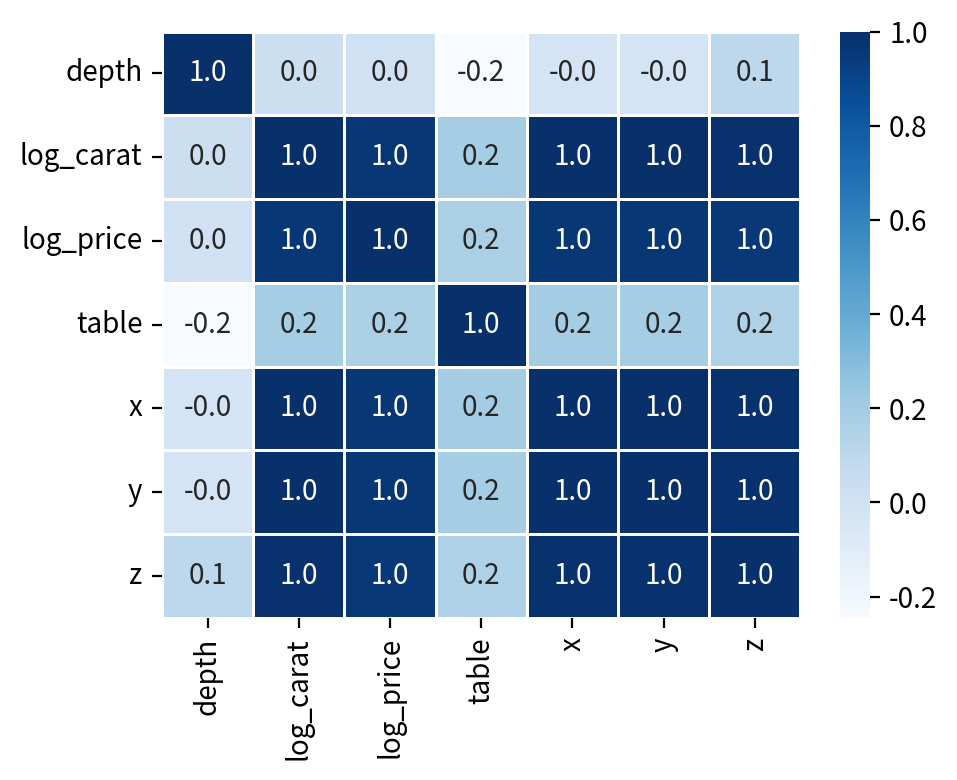

In [58]:
# 1) 그래프 초기화
width_px = 1000  # 그래프 가로 크기
height_px = 800  # 그래프 세로 크기
rows = 1  # 그래프 행 수
cols = 1  # 그래프 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)
# 2) heatmap 그리기
sb.heatmap(
    data=corr_matrix,
    annot=True,
    fmt="0.1f",
    linewidth=0.5,
    cmap="Blues",
    annot_kws={"size": 10},
)
# 4) 출력
plt.tight_layout()  # 여백 제거
plt.show()  # 그래프 화면 출력
plt.close()  # 그래프 작업 종료

가격 분포에 왜도랑 이상치가 존재하여 Pearson보다 Spearman(순위 기반)으로 해석하였다.
그 결과 price는 x가 가장 강하게 연결되어 있었고(r=0.96), y·carat·z도 거의 비슷하게 매우 높았다.
즉 다이아가 커질수록(무게/치수 증가) 가격도 같이 올라가는 경향이 뚜렷했고, depth나 table처럼 비율 변수는 가격과 관계가 약했다.

## 미션 9. “상관관계는 곧 원인일까?
상관이 높다는 것은 무엇을 의미하는가?
이 결과를 그대로 “원인”이라고 말해도 될까?

상관이 높다는 것은 두 변수가 함께 커지거나 작아지는 경향이 강하다는 뜻이다.
하지만 상관분석은 cut/color/clarity 같은 다른 요인을 통제하지 못하므로, 이 결과를 그대로 원인이라고 단정할 수는 없다.
또한 비선형 관계, 이상치 영향 때문에 상관이 더 작게 또는 크게 보일 수도 있다.
따라서 크기 변수들이 강하게 연결돼 있다는 관찰로 해석하고, 원인 판단은 추가 검증이 필요한 영역으로 남겨두는 것이 타당하다.


---

# 원본데이터

**notebooks/jinwoo/원본데이터.ipynb**


In [59]:
# 라이브러리 기본 참조
from hossam import load_data
from pandas import DataFrame, concat, pivot_table, get_dummies
from matplotlib import pyplot as plt
import pandas as pd
from matplotlib import font_manager as fm
import seaborn as sb
import numpy as np
from scipy.stats import t, ttest_ind, normaltest, bartlett, levene
from math import sqrt


# 선형회귀를 위한 참조
import statsmodels.api as sm
from statsmodels.formula.api import ols

# 결과 검정을 위한 참조
from statsmodels.stats.diagnostic import linear_reset
from scipy.stats import zscore, probplot, shapiro, anderson, pearsonr, spearmanr
from statsmodels.stats.api import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from pingouin import anova, welch_anova, pairwise_tukey, pairwise_gameshowell

# VIF값을 계산하기 위한 참조
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statannotations.Annotator import Annotator

# 파이썬 기본 패키지
from itertools import combinations

In [60]:
origin = load_data("diamonds")
print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기: {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")
print("\n===== 타입확인 =====")
print(origin.info())
origin.head()

[data] https://data.hossam.kr/data/kaggle/diamonds.xlsx
[desc] 다이아몬드를 커팅, 색상, 투명도, 가격 및 기타 속성 조사한 데이터 셋 (출처: https://www.kaggle.com/datasets/shivam2503/diamonds)

field    description
-------  -------------------------------------------------------------------
price    다이아몬드 가격 (USD, $326 ~ $18,823)
carat    중량 (0.2~5.01)
cut      컷 품질 (Fair, Good, Very Good, Premium, Ideal)
color    색상 등급 - J (worst) to D (best)
clarity  투명도 등급 (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))
x        길이 mm (0~10.74)
y        너비 mm (0--58.9)
z        두께 mm (0--31.8)
depth    비율 정보 = z / mean(x, y) = 2 * z / (x + y) (43--79)
table    다이아몬드의 가장 넓은 지점에 비해 상단(테이블)의 너비 (43--95)


===== 데이터 크기 확인 =====
데이터셋 크기: (53940, 10)
열 개수: 10
행 개수: 53940

===== 타입확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   price    53940 non-null  int64  
 1   carat    53940 

price  carat      cut color clarity     x     y     z  depth  table
0    326   0.23    Ideal     E     SI2  3.95  3.98  2.43   61.5   55.0
1    326   0.21  Premium     E     SI1  3.89  3.84  2.31   59.8   61.0
2    327   0.23     Good     E     VS1  4.05  4.07  2.31   56.9   65.0
3    334   0.29  Premium     I     VS2  4.20  4.23  2.63   62.4   58.0
4    335   0.31     Good     J     SI2  4.34  4.35  2.75   63.3   58.0

In [61]:
def ols_report(tbl, data):
    """
    OLS summary(tbl)와 데이터프레임(data)을 받아 회귀계수 표(rdf),
    모델 적합도 요약(result_report), 모형 보고 문장(model_report),
    변수별 보고 리스트(variable_reports)를 반환한다.

    Parameters
    ----------
    tbl : statsmodels.iolib.summary.Summary
        sm.OLS(...).fit().summary() 결과로 생성된 summary 객체.
    data : pandas.DataFrame
        종속변수와 독립변수를 모두 포함한 데이터프레임.

    Returns
    -------
    tuple
        (회귀계수 DataFrame, 적합도 요약 문자열, 모형 보고 문자열, 변수별 보고 리스트)
    """

    # 독립변수 이름(상수항 제외)
    xnames = [n for n in fit.model.exog_names if n != "const"]

    # 독립변수 부분 데이터 (VIF 계산용)
    indi_df = data.filter(xnames)

    # 독립변수 결과를 누적
    variables = []

    for i, v in enumerate(tbl.tables[1].data):
        # 한 행의 변수명 추출 후 목록에 있는지 확인
        name = v[0].strip()
        if name not in xnames:
            continue

        # VIF 계산을 위해 열 인덱스 조회
        j = list(indi_df.columns).index(name)
        vif = variance_inflation_factor(indi_df, j)

        # 유의확률과 별표 표시 함수
        p = float(v[4].strip())

        def stars(p):
            return "***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else ""

        # 한 변수에 대한 보고 정보 추가
        variables.append(
            {
                "종속변수": yname,  # 종속변수 이름 (외부에서 정의)
                "독립변수": name,  # 독립변수 이름
                "B": v[1].strip(),  # 비표준화 회귀계수(B)
                "표준오차": v[2].strip(),  # 계수 표준오차
                "Beta": float(fit.params[name])
                * (
                    data[name].std(ddof=1) / data[yname].std(ddof=1)
                ),  # 표준화 회귀계수(β)
                "t": "%s%s" % (v[3].strip(), stars(p)),  # t-통계량(+별표)
                "p-value": p,  # 계수 유의확률
                "공차": 1 / vif,  # 공차(Tolerance = 1/VIF)
                "vif": vif,  # 분산팽창계수
            }
        )

    rdf = DataFrame(variables)

    # summary 표에서 적합도 정보를 key-value로 추출
    result_dict = {}
    for idx in [0, 2]:
        for item in tbl.tables[idx].data:
            n = len(item)
            for j in range(0, n, 2):
                key = item[j].strip()[:-1]
                value = item[j + 1].strip()
                if not key or not value:
                    continue
                result_dict[key] = value

    # 적합도 보고 문자열 구성
    result_report = (
        f"𝑅({result_dict['R-squared']}), "
        f"𝑅^2({result_dict['Adj. R-squared']}), "
        f"𝐹({result_dict['F-statistic']}), "
        f"유의확률({result_dict['Prob (F-statistic)']}), "
        f"Durbin-Watson({result_dict['Durbin-Watson']})"
    )

    # 모형 보고 문장 구성
    p_f = float(result_dict["Prob (F-statistic)"])
    sig_text = "유의하다" if p_f <= 0.05 else "유의하지 않다"
    p_sign = "≤" if p_f <= 0.05 else ">"

    tpl = (
        "%s에 대하여 %s로 예측하는 회귀분석을 실시한 결과, "
        "이 회귀모형은 통계적으로 %s(F(%s,%s) = %s, p %s 0.05)."
    )

    model_report = tpl % (
        rdf["종속변수"][0],
        ",".join(list(rdf["독립변수"])),
        sig_text,
        result_dict["Df Model"],
        result_dict["Df Residuals"],
        result_dict["F-statistic"],
        p_sign,
    )

    # 변수별 보고 문장 리스트 구성
    variable_reports = []
    s = "%s의 회귀계수는 %s(p %s 0.05)로, %s에 대하여 %s 예측변인인 것으로 나타났다."

    for i in rdf.index:
        row = rdf.iloc[i]
        p_val = float(row["p-value"])
        p_sign_var = "≤" if p_val < 0.05 else ">"
        sig_word = "유의미한" if p_val < 0.05 else "유의하지 않은"

        variable_reports.append(
            s
            % (
                row["독립변수"],
                row["B"],
                p_sign_var,
                row["종속변수"],
                sig_word,
            )
        )

    return rdf, result_report, model_report, variable_reports

In [62]:
df = origin.filter(["price", "carat", "depth", "table", "x", "y", "z"]).copy()
df.head()

yname = "price"

x = df.drop(yname, axis=1)
y = df[yname]

x_input = sm.add_constant(x)
fit = sm.OLS(y, x_input).fit()
tbl1 = fit.summary()
print(tbl1)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.859
Method:                 Least Squares   F-statistic:                 5.486e+04
Date:                Fri, 16 Jan 2026   Prob (F-statistic):               0.00
Time:                        17:14:18   Log-Likelihood:            -4.7090e+05
No. Observations:               53940   AIC:                         9.418e+05
Df Residuals:                   53933   BIC:                         9.419e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.085e+04    447.562     46.584      0.0

In [63]:
rdf, r, m, v = ols_report(tbl1, df)
display(rdf)
print(m)

종속변수   독립변수           B    표준오차      Beta           t  p-value        공차  \
0  price  carat   1.069e+04  63.201  1.269710  169.085***    0.000  0.014259   
1  price  depth   -203.1541   5.504 -0.072953  -36.910***    0.000  0.001941   
2  price  table   -102.4457   3.084 -0.057380  -33.216***    0.000  0.001998   
3  price      x  -1315.6678  43.070 -0.369943  -30.547***    0.000  0.000778   
4  price      y     66.3216  25.523  0.018987     2.599**    0.009  0.001883   
5  price      z     41.6277  44.305  0.007364       0.940    0.347  0.001850   

           vif  
0    70.132799  
1   515.146274  
2   500.595341  
3  1284.949828  
4   530.998218  
5   540.677349

price에 대하여 carat,depth,table,x,y,z로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(6,53933) = 5.486e+04, p ≤ 0.05).


In [64]:
while True:
    rdf, r, m, v = ols_report(tbl1, df)
    if rdf["vif"].max() >= 10:
        df = df.drop(rdf[rdf["vif"] == rdf["vif"].max()]["독립변수"], axis=1)
        x = df.drop(yname, axis=1)
        y = df[yname]
        x_input = sm.add_constant(x)
        fit = sm.OLS(y, x_input).fit()
        tbl1 = fit.summary()
    else:
        break

In [65]:
display(rdf)

종속변수   독립변수          B    표준오차      Beta           t  p-value        공차  \
0  price  carat  7820.0379  14.225  0.929149  549.744***      0.0  0.255747   
1  price  table   -74.3007   3.018 -0.041616  -24.623***      0.0  0.255747   

        vif  
0  3.910114  
1  3.910114

In [66]:
df1 = origin.filter(["price", "carat", "cut", "color", "clarity"]).copy()

df1 = get_dummies(
    df1, columns=["cut", "color", "clarity"], dtype="int", drop_first=True
)
df1.head()

price  carat  cut_Good  cut_Ideal  cut_Premium  cut_Very Good  color_E  \
0    326   0.23         0          1            0              0        1   
1    326   0.21         0          0            1              0        1   
2    327   0.23         1          0            0              0        1   
3    334   0.29         0          0            1              0        0   
4    335   0.31         1          0            0              0        0   

   color_F  color_G  color_H  color_I  color_J  clarity_IF  clarity_SI1  \
0        0        0        0        0        0           0            0   
1        0        0        0        0        0           0            1   
2        0        0        0        0        0           0            0   
3        0        0        0        1        0           0            0   
4        0        0        0        0        1           0            0   

   clarity_SI2  clarity_VS1  clarity_VS2  clarity_VVS1  clarity_VVS2  
0            1            0            0             0             0  
1            0            0            0             0             0  
2            0            1            0             0             0  
3            0            0            1             0             0  
4            1            0            0             0             0

In [67]:
yname = "price"

x = df1.drop(yname, axis=1)
y = df1[yname]

x_input = sm.add_constant(x)
fit = sm.OLS(y, x_input).fit()
tbl1 = fit.summary()
print(tbl1)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                 3.264e+04
Date:                Fri, 16 Jan 2026   Prob (F-statistic):               0.00
Time:                        17:14:18   Log-Likelihood:            -4.5699e+05
No. Observations:               53940   AIC:                         9.140e+05
Df Residuals:                   53921   BIC:                         9.142e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -7362.8022     51.684   -142.458

In [68]:
rdf, r, m, v = ols_report(tbl1, df1)
display(rdf)
print(m)

종속변수           독립변수           B    표준오차      Beta           t  p-value  \
0   price          carat   8886.1289  12.034  1.055819  738.437***      0.0   
1   price       cut_Good    655.7674  33.634  0.047265   19.497***      0.0   
2   price      cut_Ideal    998.2544  30.656  0.122562   32.563***      0.0   
3   price    cut_Premium    869.3959  30.931  0.095068   28.108***      0.0   
4   price  cut_Very Good    848.7169  31.277  0.088696   27.135***      0.0   
5   price        color_E   -211.6825  18.316 -0.020457  -11.557***      0.0   
6   price        color_F   -303.3100  18.509 -0.029011  -16.387***      0.0   
7   price        color_G   -506.1995  18.122 -0.051622  -27.933***      0.0   
8   price        color_H   -978.6977  19.272 -0.088537  -50.784***      0.0   
9   price        color_I  -1440.3019  21.646 -0.108559  -66.538***      0.0   
10  price        color_J  -2325.2224  26.723 -0.129476  -87.013***      0.0   
11  price     clarity_IF   5419.6468  52.136  0.243336  103.952***      0.0   
12  price    clarity_SI1   3573.6880  44.598  0.383779   80.132***      0.0   
13  price    clarity_SI2   2625.9500  44.788  0.247512   58.630***      0.0   
14  price    clarity_VS1   4534.8790  45.535  0.407540   99.591***      0.0   
15  price    clarity_VS2   4217.8291  44.841  0.443052   94.061***      0.0   
16  price   clarity_VVS1   5072.0276  48.211  0.319540  105.205***      0.0   
17  price   clarity_VVS2   4967.1994  46.891  0.363215  105.932***      0.0   

          공차        vif  
0   0.214354   4.665188  
1   0.283897   3.522404  
2   0.080458  12.428895  
3   0.121939   8.200831  
4   0.135470   7.381726  
5   0.426759   2.343241  
6   0.428726   2.332493  
7   0.376285   2.657563  
8   0.449624   2.224078  
9   0.537651   1.859942  
10  0.675012   1.481455  
11  0.472803   2.115047  
12  0.117893   8.482272  
13  0.158072   6.326242  
14  0.171780   5.821405  
15  0.123040   8.127418  
16  0.310417   3.221469  
17  0.249954   4.000728

price에 대하여 carat,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_E,color_F,color_G,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(18,53921) = 3.264e+04, p ≤ 0.05).


In [69]:
xnames = list(rdf[rdf["p-value"] > 0.05]["독립변수"])
df2 = df1.drop(xnames, axis=1)
x = df2.drop(yname, axis=1)
y = df2[yname]
x_input = sm.add_constant(x)
fit = sm.OLS(y, x_input).fit()
tbl = fit.summary()
rdf, r, m, v = ols_report(tbl, df2)

In [70]:
r

'𝑅(0.916), 𝑅^2(0.916), 𝐹(3.264e+04), 유의확률(0.00), Durbin-Watson(0.907)'


---

# 전처리

**notebooks/jinwoo/전처리.ipynb**


In [71]:
# 라이브러리 기본 참조
from hossam import load_data
from pandas import DataFrame, concat, pivot_table, get_dummies
from matplotlib import pyplot as plt
import pandas as pd
from matplotlib import font_manager as fm
import seaborn as sb
import numpy as np
from scipy.stats import t, ttest_ind, normaltest, bartlett, levene
from math import sqrt


# 선형회귀를 위한 참조
import statsmodels.api as sm
from statsmodels.formula.api import ols

# 결과 검정을 위한 참조
from statsmodels.stats.diagnostic import linear_reset
from scipy.stats import zscore, probplot, shapiro, anderson, pearsonr, spearmanr
from statsmodels.stats.api import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from pingouin import anova, welch_anova, pairwise_tukey, pairwise_gameshowell

# VIF값을 계산하기 위한 참조
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statannotations.Annotator import Annotator

# 파이썬 기본 패키지
from itertools import combinations

In [72]:
origin = load_data("diamonds")
print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기: {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")
print("\n===== 타입확인 =====")
print(origin.info())
origin.head()

[data] https://data.hossam.kr/data/kaggle/diamonds.xlsx
[desc] 다이아몬드를 커팅, 색상, 투명도, 가격 및 기타 속성 조사한 데이터 셋 (출처: https://www.kaggle.com/datasets/shivam2503/diamonds)

field    description
-------  -------------------------------------------------------------------
price    다이아몬드 가격 (USD, $326 ~ $18,823)
carat    중량 (0.2~5.01)
cut      컷 품질 (Fair, Good, Very Good, Premium, Ideal)
color    색상 등급 - J (worst) to D (best)
clarity  투명도 등급 (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))
x        길이 mm (0~10.74)
y        너비 mm (0--58.9)
z        두께 mm (0--31.8)
depth    비율 정보 = z / mean(x, y) = 2 * z / (x + y) (43--79)
table    다이아몬드의 가장 넓은 지점에 비해 상단(테이블)의 너비 (43--95)


===== 데이터 크기 확인 =====
데이터셋 크기: (53940, 10)
열 개수: 10
행 개수: 53940

===== 타입확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   price    53940 non-null  int64  
 1   carat    53940 

price  carat      cut color clarity     x     y     z  depth  table
0    326   0.23    Ideal     E     SI2  3.95  3.98  2.43   61.5   55.0
1    326   0.21  Premium     E     SI1  3.89  3.84  2.31   59.8   61.0
2    327   0.23     Good     E     VS1  4.05  4.07  2.31   56.9   65.0
3    334   0.29  Premium     I     VS2  4.20  4.23  2.63   62.4   58.0
4    335   0.31     Good     J     SI2  4.34  4.35  2.75   63.3   58.0

In [73]:
def ols_report(tbl, data):
    """
    OLS summary(tbl)와 데이터프레임(data)을 받아 회귀계수 표(rdf),
    모델 적합도 요약(result_report), 모형 보고 문장(model_report),
    변수별 보고 리스트(variable_reports)를 반환한다.

    Parameters
    ----------
    tbl : statsmodels.iolib.summary.Summary
        sm.OLS(...).fit().summary() 결과로 생성된 summary 객체.
    data : pandas.DataFrame
        종속변수와 독립변수를 모두 포함한 데이터프레임.

    Returns
    -------
    tuple
        (회귀계수 DataFrame, 적합도 요약 문자열, 모형 보고 문자열, 변수별 보고 리스트)
    """

    # 독립변수 이름(상수항 제외)
    xnames = [n for n in fit.model.exog_names if n != "const"]

    # 독립변수 부분 데이터 (VIF 계산용)
    indi_df = data.filter(xnames)

    # 독립변수 결과를 누적
    variables = []

    for i, v in enumerate(tbl.tables[1].data):
        # 한 행의 변수명 추출 후 목록에 있는지 확인
        name = v[0].strip()
        if name not in xnames:
            continue

        # VIF 계산을 위해 열 인덱스 조회
        j = list(indi_df.columns).index(name)
        vif = variance_inflation_factor(indi_df, j)

        # 유의확률과 별표 표시 함수
        p = float(v[4].strip())

        def stars(p):
            return "***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else ""

        # 한 변수에 대한 보고 정보 추가
        variables.append(
            {
                "종속변수": yname,  # 종속변수 이름 (외부에서 정의)
                "독립변수": name,  # 독립변수 이름
                "B": v[1].strip(),  # 비표준화 회귀계수(B)
                "표준오차": v[2].strip(),  # 계수 표준오차
                "Beta": float(fit.params[name])
                * (
                    data[name].std(ddof=1) / data[yname].std(ddof=1)
                ),  # 표준화 회귀계수(β)
                "t": "%s%s" % (v[3].strip(), stars(p)),  # t-통계량(+별표)
                "p-value": p,  # 계수 유의확률
                "공차": 1 / vif,  # 공차(Tolerance = 1/VIF)
                "vif": vif,  # 분산팽창계수
            }
        )

    rdf = DataFrame(variables)

    # summary 표에서 적합도 정보를 key-value로 추출
    result_dict = {}
    for idx in [0, 2]:
        for item in tbl.tables[idx].data:
            n = len(item)
            for j in range(0, n, 2):
                key = item[j].strip()[:-1]
                value = item[j + 1].strip()
                if not key or not value:
                    continue
                result_dict[key] = value

    # 적합도 보고 문자열 구성
    result_report = (
        f"𝑅({result_dict['R-squared']}), "
        f"𝑅^2({result_dict['Adj. R-squared']}), "
        f"𝐹({result_dict['F-statistic']}), "
        f"유의확률({result_dict['Prob (F-statistic)']}), "
        f"Durbin-Watson({result_dict['Durbin-Watson']})"
    )

    # 모형 보고 문장 구성
    p_f = float(result_dict["Prob (F-statistic)"])
    sig_text = "유의하다" if p_f <= 0.05 else "유의하지 않다"
    p_sign = "≤" if p_f <= 0.05 else ">"

    tpl = (
        "%s에 대하여 %s로 예측하는 회귀분석을 실시한 결과, "
        "이 회귀모형은 통계적으로 %s(F(%s,%s) = %s, p %s 0.05)."
    )

    model_report = tpl % (
        rdf["종속변수"][0],
        ",".join(list(rdf["독립변수"])),
        sig_text,
        result_dict["Df Model"],
        result_dict["Df Residuals"],
        result_dict["F-statistic"],
        p_sign,
    )

    # 변수별 보고 문장 리스트 구성
    variable_reports = []
    s = "%s의 회귀계수는 %s(p %s 0.05)로, %s에 대하여 %s 예측변인인 것으로 나타났다."

    for i in rdf.index:
        row = rdf.iloc[i]
        p_val = float(row["p-value"])
        p_sign_var = "≤" if p_val < 0.05 else ">"
        sig_word = "유의미한" if p_val < 0.05 else "유의하지 않은"

        variable_reports.append(
            s
            % (
                row["독립변수"],
                row["B"],
                p_sign_var,
                row["종속변수"],
                sig_word,
            )
        )

    return rdf, result_report, model_report, variable_reports

In [74]:
xyz = ["x", "y", "z"]
origin.drop_duplicates()
df = origin[(origin[xyz] != 0).all(axis=1)]

df

price  carat        cut color clarity     x     y     z  depth  table
0        326   0.23      Ideal     E     SI2  3.95  3.98  2.43   61.5   55.0
1        326   0.21    Premium     E     SI1  3.89  3.84  2.31   59.8   61.0
2        327   0.23       Good     E     VS1  4.05  4.07  2.31   56.9   65.0
3        334   0.29    Premium     I     VS2  4.20  4.23  2.63   62.4   58.0
4        335   0.31       Good     J     SI2  4.34  4.35  2.75   63.3   58.0
...      ...    ...        ...   ...     ...   ...   ...   ...    ...    ...
53935   2757   0.72      Ideal     D     SI1  5.75  5.76  3.50   60.8   57.0
53936   2757   0.72       Good     D     SI1  5.69  5.75  3.61   63.1   55.0
53937   2757   0.70  Very Good     D     SI1  5.66  5.68  3.56   62.8   60.0
53938   2757   0.86    Premium     H     SI2  6.15  6.12  3.74   61.0   58.0
53939   2757   0.75      Ideal     D     SI2  5.83  5.87  3.64   62.2   55.0

[53920 rows x 10 columns]

In [75]:
df = df.copy()

df["log_price"] = np.log(df["price"])
df["log_carat"] = np.log(df["carat"])
df.head()

price  carat      cut color clarity     x     y     z  depth  table  \
0    326   0.23    Ideal     E     SI2  3.95  3.98  2.43   61.5   55.0   
1    326   0.21  Premium     E     SI1  3.89  3.84  2.31   59.8   61.0   
2    327   0.23     Good     E     VS1  4.05  4.07  2.31   56.9   65.0   
3    334   0.29  Premium     I     VS2  4.20  4.23  2.63   62.4   58.0   
4    335   0.31     Good     J     SI2  4.34  4.35  2.75   63.3   58.0   

   log_price  log_carat  
0   5.786897  -1.469676  
1   5.786897  -1.560648  
2   5.789960  -1.469676  
3   5.811141  -1.237874  
4   5.814131  -1.171183

In [76]:
df1 = df.filter(["log_price", "log_carat", "depth", "table", "x", "y", "z"]).copy()
df1.head()

yname = "log_price"

x = df1.drop(yname, axis=1)
y = df1[yname]

x_input = sm.add_constant(x)
fit = sm.OLS(y, x_input).fit()
tbl1 = fit.summary()
print(tbl1)

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.935
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                 1.299e+05
Date:                Fri, 16 Jan 2026   Prob (F-statistic):               0.00
Time:                        17:14:20   Log-Likelihood:                -3473.7
No. Observations:               53920   AIC:                             6961.
Df Residuals:                   53913   BIC:                             7024.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.5899      0.116     99.541      0.0

In [77]:
rdf, r, m, v = ols_report(tbl1, df1)
display(rdf)
print(m)

종속변수       독립변수        B   표준오차      Beta           t  p-value  \
0  log_price  log_carat   1.7378  0.018  1.001587   95.637***    0.000   
1  log_price      depth  -0.0309  0.001 -0.043646  -29.583***    0.000   
2  log_price      table  -0.0186  0.001 -0.040992  -34.684***    0.000   
3  log_price          x  -0.0424  0.011 -0.046778   -3.842***    0.000   
4  log_price          y   0.0091  0.004  0.010224      2.049*    0.040   
5  log_price          z   0.0149  0.009  0.010311       1.719    0.086   

         공차          vif  
0  0.019411    51.516387  
1  0.000982  1017.838106  
2  0.001683   594.130693  
3  0.000645  1549.435070  
4  0.001850   540.537766  
5  0.001329   752.453780

log_price에 대하여 log_carat,depth,table,x,y,z로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(6,53913) = 1.299e+05, p ≤ 0.05).


In [78]:
while True:
    rdf, r, m, v = ols_report(tbl1, df1)
    if rdf["vif"].max() >= 10:
        df1 = df1.drop(rdf[rdf["vif"] == rdf["vif"].max()]["독립변수"], axis=1)
        x = df1.drop(yname, axis=1)
        y = df1[yname]
        x_input = sm.add_constant(x)
        fit = sm.OLS(y, x_input).fit()
        tbl1 = fit.summary()
    else:
        break

In [79]:
display(rdf)

종속변수       독립변수        B   표준오차      Beta           t  p-value  \
0  log_price  log_carat   1.7161  0.009  0.989099  192.725***      0.0   
1  log_price          z  -0.0343  0.007 -0.023744   -4.627***      0.0   

         공차       vif  
0  0.846452  1.181402  
1  0.846452  1.181402

In [80]:
df2 = df.filter(["log_price", "log_carat", "cut", "color", "clarity"]).copy()

df2 = get_dummies(
    df2, columns=["cut", "color", "clarity"], dtype="int", drop_first=True
)
df2.head()

log_price  log_carat  cut_Good  cut_Ideal  cut_Premium  cut_Very Good  \
0   5.786897  -1.469676         0          1            0              0   
1   5.786897  -1.560648         0          0            1              0   
2   5.789960  -1.469676         1          0            0              0   
3   5.811141  -1.237874         0          0            1              0   
4   5.814131  -1.171183         1          0            0              0   

   color_E  color_F  color_G  color_H  color_I  color_J  clarity_IF  \
0        1        0        0        0        0        0           0   
1        1        0        0        0        0        0           0   
2        1        0        0        0        0        0           0   
3        0        0        0        0        1        0           0   
4        0        0        0        0        0        1           0   

   clarity_SI1  clarity_SI2  clarity_VS1  clarity_VS2  clarity_VVS1  \
0            0            1            0            0             0   
1            1            0            0            0             0   
2            0            0            1            0             0   
3            0            0            0            1             0   
4            0            1            0            0             0   

   clarity_VVS2  
0             0  
1             0  
2             0  
3             0  
4             0

In [81]:
yname = "log_price"

x = df2.drop(yname, axis=1)
y = df2[yname]

x_input = sm.add_constant(x)
fit = sm.OLS(y, x_input).fit()
tbl1 = fit.summary()
print(tbl1)

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                 1.693e+05
Date:                Fri, 16 Jan 2026   Prob (F-statistic):               0.00
Time:                        17:14:21   Log-Likelihood:                 31961.
No. Observations:               53920   AIC:                        -6.388e+04
Df Residuals:                   53901   BIC:                        -6.372e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             7.8568      0.006   1362.891

In [82]:
rdf, r, m, v = ols_report(tbl1, df2)
display(rdf)
print(m)

종속변수           독립변수        B   표준오차      Beta            t  p-value  \
0   log_price      log_carat   1.8837  0.001  1.085710  1668.528***      0.0   
1   log_price       cut_Good   0.0801  0.004  0.022708    20.592***      0.0   
2   log_price      cut_Ideal   0.1613  0.004  0.077862    45.442***      0.0   
3   log_price    cut_Premium   0.1394  0.004  0.059934    38.942***      0.0   
4   log_price  cut_Very Good   0.1172  0.004  0.048185    32.392***      0.0   
5   log_price        color_E  -0.0542  0.002 -0.020610   -25.600***      0.0   
6   log_price        color_F  -0.0945  0.002 -0.035560   -44.135***      0.0   
7   log_price        color_G  -0.1602  0.002 -0.064237   -76.405***      0.0   
8   log_price        color_H  -0.2511  0.002 -0.089295  -112.834***      0.0   
9   log_price        color_I  -0.3725  0.002 -0.110417  -149.483***      0.0   
10  log_price        color_J  -0.5110  0.003 -0.111898  -166.237***      0.0   
11  log_price     clarity_IF   1.1137  0.006  0.196655   184.434***      0.0   
12  log_price    clarity_SI1   0.5929  0.005  0.250394   114.942***      0.0   
13  log_price    clarity_SI2   0.4279  0.005  0.158558    82.487***      0.0   
14  log_price    clarity_VS1   0.8122  0.005  0.287049   154.231***      0.0   
15  log_price    clarity_VS2   0.7421  0.005  0.306537   143.067***      0.0   
16  log_price   clarity_VVS1   1.0186  0.006  0.252352   182.410***      0.0   
17  log_price   clarity_VVS2   0.9472  0.005  0.272401   174.523***      0.0   

          공차        vif  
0   0.522840   1.912630  
1   0.284892   3.510103  
2   0.080128  12.480108  
3   0.122948   8.133493  
4   0.135808   7.363356  
5   0.429124   2.330329  
6   0.433958   2.304371  
7   0.383126   2.610105  
8   0.462241   2.163375  
9   0.555656   1.799675  
10  0.695564   1.437681  
11  0.452660   2.209162  
12  0.119196   8.389535  
13  0.167713   5.962569  
14  0.168313   5.941300  
15  0.122032   8.194553  
16  0.293554   3.406527  
17  0.240493   4.158130

log_price에 대하여 log_carat,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_E,color_F,color_G,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(18,53901) = 1.693e+05, p ≤ 0.05).


In [83]:
xnames = list(rdf[rdf["p-value"] > 0.05]["독립변수"])
df3 = df2.drop(xnames, axis=1)
x = df3.drop(yname, axis=1)
y = df3[yname]
x_input = sm.add_constant(x)
fit = sm.OLS(y, x_input).fit()
tbl = fit.summary()
rdf, r, m, v = ols_report(tbl, df3)

In [84]:
r

'𝑅(0.983), 𝑅^2(0.983), 𝐹(1.693e+05), 유의확률(0.00), Durbin-Watson(1.245)'

📕 선형성 검정
RESET F-statistic: 909.4493
p-value: 0.0000
선형성/기능형 위배 가능성이 있음 (5% 유의수준)


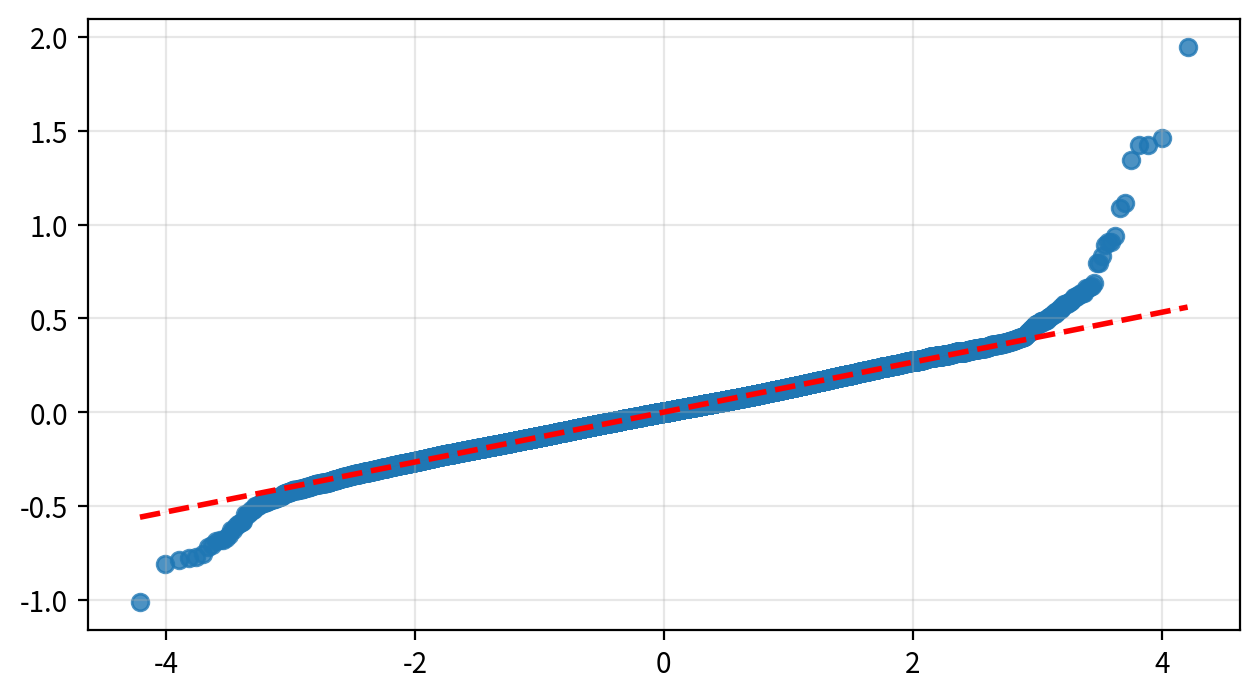

루트 1MSE 구간에 포함된 잔차 비율: 69.74%
루트 2MSE 구간에 포함된 잔차 비율: 95.44%
루트 3MSE 구간에 포함된 잔차 비율: 99.60%


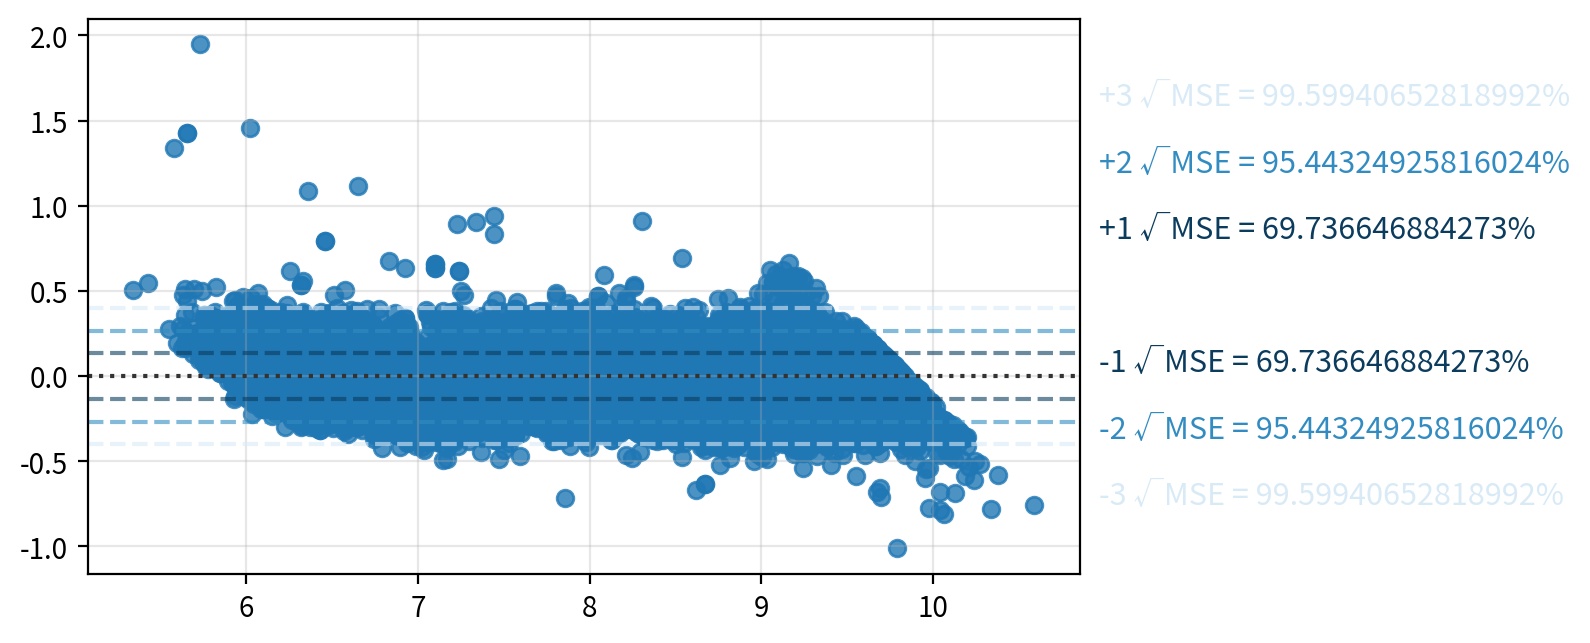

🎯 잔차의 정규성, 등분산성, 독립성 검정
Anderson-Darling statistic: 23.4848, 5% 임계값: 0.7870
정규성 가정 위배 가능성이 있음 (5% 유의수준)
Breusch-Pagan statistic: 77.589, p-value = 0.000
이분산성 존재(등분산 아님)
Durbin-Watson=1.245
잔차에 양(+)의 자기상관이 존재할 가능성 있음 (독립성 위반)
🎓 최종 결과 보고
log_price에 대하여 log_carat,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_E,color_F,color_G,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(18,53901) = 1.693e+05, p ≤ 0.05).
log_carat의 회귀계수는 1.8837(p ≤ 0.05)로, log_price에 대하여 유의미한 예측변인인 것으로 나타났다.
cut_Good의 회귀계수는 0.0801(p ≤ 0.05)로, log_price에 대하여 유의미한 예측변인인 것으로 나타났다.
cut_Ideal의 회귀계수는 0.1613(p ≤ 0.05)로, log_price에 대하여 유의미한 예측변인인 것으로 나타났다.
cut_Premium의 회귀계수는 0.1394(p ≤ 0.05)로, log_price에 대하여 유의미한 예측변인인 것으로 나타났다.
cut_Very Good의 회귀계수는 0.1172(p ≤ 0.05)로, log_price에 대하여 유의미한 예측변인인 것으로 나타났다.
color_E의 회귀계수는 -0.0542(p ≤ 0.05)로, log_price에 대하여 유의미한 예측변인인 것으로 나타났다.
color_F의 회귀계수는 -0.0945(p ≤ 0.05)로, log_price에 대하여 

In [85]:
# 잔차 검정
print("=" * 50)
print("📕 선형성 검정")
print("=" * 50)
reset_res = linear_reset(fit, power=2, use_f=True)
print(f"RESET F-statistic: {reset_res.fvalue:.4f}")
print(f"p-value: {reset_res.pvalue:.4f}")
if reset_res.pvalue < 0.05:
    print("선형성/기능형 위배 가능성이 있음 (5% 유의수준)")
else:
    print("선형성 가정 위배 근거 없음 (5% 유의수준)")

(x, y), _ = probplot(fit.resid)
width_px = 1280
height_px = 720
rows = 1
cols = 1
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)
sb.regplot(x=x, y=y, line_kws={"color": "red", "linestyle": "--", "linewidth": 2})
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
plt.close()

rr = fit.resid
mse_sq = fit.mse_resid
mse_root = np.sqrt(mse_sq)
colors = ["#0B3C5D", "#328CC1", "#D9EAF7"]
r1 = rr[(rr > -mse_root) & (rr < mse_root)].count() / rr.count() * 100
r2 = rr[(rr > -2 * mse_root) & (rr < 2 * mse_root)].count() / rr.count() * 100
r3 = rr[(rr > -3 * mse_root) & (rr < 3 * mse_root)].count() / rr.count() * 100
mse_r = [r1, r2, r3]
print(f"루트 1MSE 구간에 포함된 잔차 비율: {r1:.2f}%")
print(f"루트 2MSE 구간에 포함된 잔차 비율: {r2:.2f}%")
print(f"루트 3MSE 구간에 포함된 잔차 비율: {r3:.2f}%")
width_px = 1280
height_px = 720
rows = 1
cols = 1
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)
sb.residplot(x=fit.fittedvalues, y=fit.resid)
ax.grid(True, alpha=0.3)
for i, c in enumerate(colors):
    k = i + 1
    y_pos = k * mse_root
    ax.axhline(y=y_pos, color=c, linestyle="--", alpha=0.6)
    ax.axhline(y=-y_pos, color=c, linestyle="--", alpha=0.6)
    ax.text(
        x=1.02,
        y=0.5 + 0.12 * k,
        s=f"+{k} √MSE = {mse_r[i]}%",
        transform=ax.transAxes,
        ha="left",
        va="center",
        fontsize=11,
        color=c,
    )
    ax.text(
        x=1.02,
        y=0.5 - 0.12 * k,
        s=f"-{k} √MSE = {mse_r[i]}%",
        transform=ax.transAxes,
        ha="left",
        va="center",
        fontsize=11,
        color=c,
    )
plt.show()
plt.close()

# 잔차의 정규성, 등분산성, 독립성 검정
print("=" * 50)
print("🎯 잔차의 정규성, 등분산성, 독립성 검정")
print("=" * 50)
if len(origin) < 5000:
    method = "Shapiro-Wilk"
    s, p = shapiro(fit.resid)
    print(f"{method} statistic: {s:.4f}, p-value: {p:.4f}")
    violated = p < 0.05
else:
    method = "Anderson-Darling"
    ad_res = anderson(fit.resid, dist="norm")
    crit_levels = ad_res.significance_level.tolist()
    crit_values = ad_res.critical_values.tolist()
    crit_5 = crit_values[crit_levels.index(5.0)] if 5.0 in crit_levels else None
    print(f"{method} statistic: {ad_res.statistic:.4f}, 5% 임계값: {crit_5:.4f}")
    violated = crit_5 is not None and ad_res.statistic > crit_5
print(
    "정규성 가정 위배 가능성이 있음 (5% 유의수준)"
    if violated
    else "정규성 가정 위배 근거 없음 (5% 유의수준)"
)

names = ["LM Statistic", "LM p-value", "F Statistic", "F p-value"]
bp_test = het_breuschpagan(fit.resid, fit.model.exog)
bp = DataFrame(bp_test, index=names, columns=["value"])
p_bp = bp.loc["F p-value", "value"]
print(
    f"Breusch-Pagan statistic: {bp.loc['F Statistic', 'value']:.3f}, p-value = {p_bp:.3f}"
)
print(f"{'이분산성 존재(등분산 아님)' if p_bp<=0.05 else '등분산성 만족'}")

dw = durbin_watson(fit.resid)
if 1.5 <= dw <= 2.5:
    interpretation = "잔차는 독립성을 만족함 (자기상관 없음)"
elif dw < 1.5:
    interpretation = "잔차에 양(+)의 자기상관이 존재할 가능성 있음 (독립성 위반)"
else:
    interpretation = "잔차에 음(-)의 자기상관이 존재할 가능성 있음 (독립성 위반)"
print(f"Durbin-Watson={dw:.3f}\n{interpretation}")

# 최종 결과 보고
print("=" * 50)
print("🎓 최종 결과 보고")
print("=" * 50)
print(m)
print("\n".join(v))


---

# 교호작용

**notebooks/seongyu/교효작용.ipynb**


# 1. 패키지 참조 및 데이터 가져오기

In [86]:
from hossam import load_data
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
import numpy as np
import pandas as pd
from pandas import DataFrame
import statsmodels.api as sm
from statsmodels.stats.diagnostic import linear_reset
from scipy.stats import zscore, pearsonr, spearmanr, probplot, shapiro, kstest, anderson

from statsmodels.formula.api import ols
from statsmodels.stats.api import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson

from statsmodels.stats.outliers_influence import variance_inflation_factor

In [87]:
my_dpi = 200
font_path = "./NotoSansKR-Regular.ttf"
fm.fontManager.addfont(font_path)
font_prop = fm.FontProperties(fname=font_path)
font_name = font_prop.get_name()
plt.rcParams["font.family"] = font_name
plt.rcParams["font.size"] = 6
plt.rcParams["axes.unicode_minus"] = False

In [88]:
origin = load_data("diamonds")
print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기 : {origin.shape}")
print(f"행 개수 : {origin.shape[0]}개")
print(f"열 개수 : {origin.shape[1]}개")
print("\n===== 타입 확인 =====")
print(origin.info())
origin.head()

[data] https://data.hossam.kr/data/kaggle/diamonds.xlsx
[desc] 다이아몬드를 커팅, 색상, 투명도, 가격 및 기타 속성 조사한 데이터 셋 (출처: https://www.kaggle.com/datasets/shivam2503/diamonds)

field    description
-------  -------------------------------------------------------------------
price    다이아몬드 가격 (USD, $326 ~ $18,823)
carat    중량 (0.2~5.01)
cut      컷 품질 (Fair, Good, Very Good, Premium, Ideal)
color    색상 등급 - J (worst) to D (best)
clarity  투명도 등급 (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))
x        길이 mm (0~10.74)
y        너비 mm (0--58.9)
z        두께 mm (0--31.8)
depth    비율 정보 = z / mean(x, y) = 2 * z / (x + y) (43--79)
table    다이아몬드의 가장 넓은 지점에 비해 상단(테이블)의 너비 (43--95)


===== 데이터 크기 확인 =====
데이터셋 크기 : (53940, 10)
행 개수 : 53940개
열 개수 : 10개

===== 타입 확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   price    53940 non-null  int64  
 1   carat    

price  carat      cut color clarity     x     y     z  depth  table
0    326   0.23    Ideal     E     SI2  3.95  3.98  2.43   61.5   55.0
1    326   0.21  Premium     E     SI1  3.89  3.84  2.31   59.8   61.0
2    327   0.23     Good     E     VS1  4.05  4.07  2.31   56.9   65.0
3    334   0.29  Premium     I     VS2  4.20  4.23  2.63   62.4   58.0
4    335   0.31     Good     J     SI2  4.34  4.35  2.75   63.3   58.0

# 2. 전처리 작업

In [89]:
df = origin.drop_duplicates()
df1 = df.drop(index=df[(df["x"] == 0) | (df["y"] == 0) | (df["z"] == 0)].index)
df1.head()

price  carat      cut color clarity     x     y     z  depth  table
0    326   0.23    Ideal     E     SI2  3.95  3.98  2.43   61.5   55.0
1    326   0.21  Premium     E     SI1  3.89  3.84  2.31   59.8   61.0
2    327   0.23     Good     E     VS1  4.05  4.07  2.31   56.9   65.0
3    334   0.29  Premium     I     VS2  4.20  4.23  2.63   62.4   58.0
4    335   0.31     Good     J     SI2  4.34  4.35  2.75   63.3   58.0

In [90]:
col_1 = "cut"
col_2 = "clarity"

df1[f"{col_1}_{col_2}"] = ""
df1 = df1.reset_index(drop=True)

for i in range(0, len(df1)):
    df1.loc[i, f"{col_1}_{col_2}"] = f"{df1.loc[i,col_1]}_{df1.loc[i,col_2]}"

df1.head()

price  carat      cut color clarity     x     y     z  depth  table  \
0    326   0.23    Ideal     E     SI2  3.95  3.98  2.43   61.5   55.0   
1    326   0.21  Premium     E     SI1  3.89  3.84  2.31   59.8   61.0   
2    327   0.23     Good     E     VS1  4.05  4.07  2.31   56.9   65.0   
3    334   0.29  Premium     I     VS2  4.20  4.23  2.63   62.4   58.0   
4    335   0.31     Good     J     SI2  4.34  4.35  2.75   63.3   58.0   

   cut_clarity  
0    Ideal_SI2  
1  Premium_SI1  
2     Good_VS1  
3  Premium_VS2  
4     Good_SI2

In [91]:
col_1 = "cut"
col_2 = "color"

df1[f"{col_1}_{col_2}"] = ""
df1 = df1.reset_index(drop=True)

for i in range(0, len(df1)):
    df1.loc[i, f"{col_1}_{col_2}"] = f"{df1.loc[i,col_1]}_{df1.loc[i,col_2]}"

df1.head()

price  carat      cut color clarity     x     y     z  depth  table  \
0    326   0.23    Ideal     E     SI2  3.95  3.98  2.43   61.5   55.0   
1    326   0.21  Premium     E     SI1  3.89  3.84  2.31   59.8   61.0   
2    327   0.23     Good     E     VS1  4.05  4.07  2.31   56.9   65.0   
3    334   0.29  Premium     I     VS2  4.20  4.23  2.63   62.4   58.0   
4    335   0.31     Good     J     SI2  4.34  4.35  2.75   63.3   58.0   

   cut_clarity  cut_color  
0    Ideal_SI2    Ideal_E  
1  Premium_SI1  Premium_E  
2     Good_VS1     Good_E  
3  Premium_VS2  Premium_I  
4     Good_SI2     Good_J

In [92]:
col_1 = "color"
col_2 = "clarity"

df1[f"{col_1}_{col_2}"] = ""
df1 = df1.reset_index(drop=True)

for i in range(0, len(df1)):
    df1.loc[i, f"{col_1}_{col_2}"] = f"{df1.loc[i,col_1]}_{df1.loc[i,col_2]}"

df1.head()

price  carat      cut color clarity     x     y     z  depth  table  \
0    326   0.23    Ideal     E     SI2  3.95  3.98  2.43   61.5   55.0   
1    326   0.21  Premium     E     SI1  3.89  3.84  2.31   59.8   61.0   
2    327   0.23     Good     E     VS1  4.05  4.07  2.31   56.9   65.0   
3    334   0.29  Premium     I     VS2  4.20  4.23  2.63   62.4   58.0   
4    335   0.31     Good     J     SI2  4.34  4.35  2.75   63.3   58.0   

   cut_clarity  cut_color color_clarity  
0    Ideal_SI2    Ideal_E         E_SI2  
1  Premium_SI1  Premium_E         E_SI1  
2     Good_VS1     Good_E         E_VS1  
3  Premium_VS2  Premium_I         I_VS2  
4     Good_SI2     Good_J         J_SI2

In [93]:
df1["log_price"] = np.log(df1["price"])
df1["log_carat"] = np.log(df1["carat"])
df1.head()

price  carat      cut color clarity     x     y     z  depth  table  \
0    326   0.23    Ideal     E     SI2  3.95  3.98  2.43   61.5   55.0   
1    326   0.21  Premium     E     SI1  3.89  3.84  2.31   59.8   61.0   
2    327   0.23     Good     E     VS1  4.05  4.07  2.31   56.9   65.0   
3    334   0.29  Premium     I     VS2  4.20  4.23  2.63   62.4   58.0   
4    335   0.31     Good     J     SI2  4.34  4.35  2.75   63.3   58.0   

   cut_clarity  cut_color color_clarity  log_price  log_carat  
0    Ideal_SI2    Ideal_E         E_SI2   5.786897  -1.469676  
1  Premium_SI1  Premium_E         E_SI1   5.786897  -1.560648  
2     Good_VS1     Good_E         E_VS1   5.789960  -1.469676  
3  Premium_VS2  Premium_I         I_VS2   5.811141  -1.237874  
4     Good_SI2     Good_J         J_SI2   5.814131  -1.171183

In [94]:
def ols_report(tbl, data):
    xnames = [n for n in fit.model.exog_names if n != "const"]
    indi_mydata1 = data.filter(xnames)
    variables = []
    for i, v in enumerate(tbl.tables[1].data):
        name = v[0].strip()
        if name not in xnames:
            continue
        j = list(indi_mydata1.columns).index(name)
        vif = variance_inflation_factor(indi_mydata1, j)

        p = float(v[4].strip())
        stars = lambda p: (
            "***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else ""
        )

        variables.append(
            {
                "종속변수": yname,
                "독립변수": name,
                "B": v[1].strip(),
                "표준오차": v[2].strip(),
                "Beta": float(fit.params[name])
                * (data[name].std(ddof=1) / data[yname].std(ddof=1)),
                "t": "%s%s" % (v[3].strip(), stars(p)),
                "p-value": p,
                "공차": 1 / vif,
                "vif": vif,
            }
        )

    rdf = DataFrame(variables)

    if rdf.empty:
        return None, "데이터 없음", "모델 유의하지 않음", []

    result_dict = {}
    for i in [0, 2]:
        for item in tbl.tables[i].data:
            n = len(item)
            for j in range(0, n, 2):
                key = item[j].strip()[:-1]
                value = item[j + 1].strip()
                if not key or not value:
                    continue
                result_dict[key] = value

    result_report = f"R({result_dict['R-squared']}), R²({result_dict['Adj. R-squared']}), F({result_dict['F-statistic']}), 유의확률({result_dict['Prob (F-statistic)']}), Durbin-Watson({result_dict['Durbin-Watson']})"

    tpl = "%s에 대하여 %s로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 %s(F(%s,%s)=%s, p %s 0.05)."
    model_report = tpl % (
        rdf["종속변수"][0],
        ",".join(list(rdf["독립변수"])),
        (
            "유의하다"
            if float(result_dict["Prob (F-statistic)"]) <= 0.05
            else "유의하지 않다"
        ),
        result_dict["Df Model"],
        result_dict["Df Residuals"],
        result_dict["F-statistic"],
        "<=" if float(result_dict["Prob (F-statistic)"]) <= 0.05 else ">",
    )

    variable_reports = []
    s = "%s의 회귀계수는 %s(p %s 0.05)로, %s에 대하여 %s 예측변인인 것으로 나타났다."

    for i in rdf.index:
        row = rdf.iloc[i]
        variable_reports.append(
            s
            % (
                row["독립변수"],
                row["B"],
                "<=" if float(row["p-value"]) < 0.05 else ">",
                row["종속변수"],
                "유의미한" if float(row["p-value"]) < 0.05 else "유의하지 않은",
            )
        )

    return rdf, result_report, model_report, variable_reports

# 3. 📊 교효작용 데이터 추가 모형

In [95]:
mydata = df1.drop(["price", "carat"], axis=1)
yname = "log_price"
# mydata1=mydata.copy()

mydata1 = pd.get_dummies(mydata, drop_first=True)
mydata1 = mydata1.astype(float)
x = mydata1.drop(yname, axis=1)
y = mydata1[yname]
x_input = sm.add_constant(x)
fit = sm.OLS(y, x_input).fit()
tbl1 = fit.summary()
rdf, r, m, v = ols_report(tbl1, mydata1)
display(rdf)
print(r)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


종속변수                  독립변수           B   표준오차      Beta          t  \
0    log_price                     x      0.0721  0.006  0.079565  12.752***   
1    log_price                     y     -0.0017  0.002 -0.001912     -0.775   
2    log_price                     z      0.0002  0.004  0.000144      0.049   
3    log_price                 depth      0.0025  0.001  0.003555   4.521***   
4    log_price                 table  -7.507e-05  0.000 -0.000165     -0.226   
..         ...                   ...         ...    ...       ...        ...   
146  log_price   color_clarity_J_SI2      0.0998  0.006  0.009243  17.428***   
147  log_price   color_clarity_J_VS1     -0.0117  0.006 -0.001145    -2.095*   
148  log_price   color_clarity_J_VS2     -0.0156  0.005 -0.001782   -3.073**   
149  log_price  color_clarity_J_VVS1     -0.0692  0.012 -0.002528  -5.733***   
150  log_price  color_clarity_J_VVS2     -0.0604  0.009 -0.002923  -6.425***   

     p-value        공차          vif  
0      0.000  0.000474  2108.050421  
1      0.438  0.001834   545.359592  
2      0.961  0.001306   765.518182  
3      0.000  0.000697  1433.796844  
4      0.821  0.001136   880.406896  
..       ...       ...          ...  
146    0.000  0.000000          inf  
147    0.036  0.000000          inf  
148    0.002  0.000000          inf  
149    0.000  0.000000          inf  
150    0.000  0.000000          inf  

[151 rows x 9 columns]

R(0.984), R²(0.984), F(2.879e+04), 유의확률(0.00), Durbin-Watson(1.253)


In [96]:
xnames = list(rdf[rdf["p-value"] > 0.05]["독립변수"])

mydata = df1.drop(["price", "carat"], axis=1)
yname = "log_price"
# mydata1=mydata.copy()

mydata1 = pd.get_dummies(mydata, drop_first=True)
mydata1 = mydata1.astype(float)
mydata1 = mydata1.drop(xnames, axis=1)
x = mydata1.drop(yname, axis=1)
y = mydata1[yname]
x_input = sm.add_constant(x)
fit = sm.OLS(y, x_input).fit()
tbl1 = fit.summary()
rdf, r, m, v = ols_report(tbl1, mydata1)

display(rdf)
print(r)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


종속변수                  독립변수        B   표준오차      Beta           t  \
0    log_price                     x   0.0708  0.005  0.078114   14.564***   
1    log_price                 depth   0.0026  0.000  0.003656    5.632***   
2    log_price             log_carat   1.7475  0.009  1.006754  187.939***   
3    log_price              cut_Good   0.1830  0.009  0.051856   19.684***   
4    log_price             cut_Ideal   0.2560  0.009  0.123610   29.451***   
..         ...                   ...      ...    ...       ...         ...   
135  log_price   color_clarity_J_SI2   0.0995  0.006  0.009219   17.217***   
136  log_price   color_clarity_J_VS1  -0.0124  0.006 -0.001222     -2.218*   
137  log_price   color_clarity_J_VS2  -0.0159  0.006 -0.001814    -2.761**   
138  log_price  color_clarity_J_VVS1  -0.0699  0.012 -0.002556   -5.757***   
139  log_price  color_clarity_J_VVS2  -0.0612  0.009 -0.002961   -6.461***   

     p-value        공차          vif  
0      0.000  0.000918  1089.626050  
1      0.000  0.000897  1114.590905  
2      0.000  0.016811    59.484410  
3      0.000  0.000000          inf  
4      0.000  0.000000          inf  
..       ...       ...          ...  
135    0.000  0.000000          inf  
136    0.027  0.000000          inf  
137    0.006  0.000000          inf  
138    0.000  0.000000          inf  
139    0.000  0.000000          inf  

[140 rows x 9 columns]

R(0.984), R²(0.984), F(2.955e+04), 유의확률(0.00), Durbin-Watson(1.253)


# 4. 📊 다중공선성 제거 모형

In [97]:
mydata = df1.filter(["x", "y", "z", "depth", "table", "log_carat", "log_price"])
yname = "log_price"
mydata1 = mydata.copy()

x = mydata1.drop(yname, axis=1)
y = mydata1[yname]
x_input = sm.add_constant(x)
fit = sm.OLS(y, x_input).fit()
tbl1 = fit.summary()
rdf, r, m, v = ols_report(tbl1, mydata1)
print("=== 1차 회귀분석 ===")
display(rdf)
print(r)

count = 2
while True:
    rdf, r, m, v = ols_report(tbl1, mydata1)
    if rdf["vif"].max() >= 10:
        mydata1 = mydata1.drop(rdf[rdf["vif"] == rdf["vif"].max()]["독립변수"], axis=1)
        x = mydata1.drop(yname, axis=1)
        y = mydata1[yname]
        x_input = sm.add_constant(x)
        fit = sm.OLS(y, x_input).fit()
        tbl1 = fit.summary()
        rdf, r, m, v = ols_report(tbl1, mydata1)
        print(f"=== {count}차 회귀분석 ===")
        display(rdf)
        print(r)
        count += 1
    else:
        break

print("\n")
print("***" * 50)
print(f"총 {count} 번의 회귀분석 진행")

=== 1차 회귀분석 ===


종속변수       독립변수        B   표준오차      Beta           t  p-value  \
0  log_price          x  -0.0442  0.011 -0.048776   -3.998***    0.000   
1  log_price          y   0.0088  0.004  0.009918      1.989*    0.047   
2  log_price          z   0.0150  0.009  0.010348       1.727    0.084   
3  log_price      depth  -0.0313  0.001 -0.044112  -29.839***    0.000   
4  log_price      table  -0.0187  0.001 -0.041270  -34.862***    0.000   
5  log_price  log_carat   1.7425  0.018  1.003894   95.511***    0.000   

         공차          vif  
0  0.000645  1549.499703  
1  0.001855   539.123229  
2  0.001331   751.082633  
3  0.000982  1017.938743  
4  0.001682   594.455997  
5  0.019401    51.542736

R(0.935), R²(0.935), F(1.297e+05), 유의확률(0.00), Durbin-Watson(1.247)
=== 2차 회귀분석 ===


종속변수       독립변수        B   표준오차      Beta           t  p-value  \
0  log_price          y   0.0037  0.004  0.004120       0.864    0.388   
1  log_price          z   0.0019  0.008  0.001315       0.237    0.813   
2  log_price      depth  -0.0291  0.001 -0.041050  -32.459***    0.000   
3  log_price      table  -0.0186  0.001 -0.040931  -34.660***    0.000   
4  log_price  log_carat   1.6832  0.011  0.969742  158.334***    0.000   

         공차         vif  
0  0.002608  383.411242  
1  0.001489  671.514148  
2  0.001055  948.115140  
3  0.002169  461.100313  
4  0.028328   35.300911

R(0.935), R²(0.935), F(1.555e+05), 유의확률(0.00), Durbin-Watson(1.256)
=== 3차 회귀분석 ===


종속변수       독립변수        B   표준오차      Beta           t  p-value  \
0  log_price          y   0.0484  0.004  0.054341   11.927***      0.0   
1  log_price          z  -0.0851  0.008 -0.058921  -11.154***      0.0   
2  log_price      table  -0.0137  0.001 -0.030114  -26.324***      0.0   
3  log_price  log_carat   1.6951  0.011  0.976570  158.004***      0.0   

         공차         vif  
0  0.002633  379.744562  
1  0.002635  379.531893  
2  0.002718  367.917663  
3  0.063712   15.695520

R(0.934), R²(0.934), F(1.904e+05), 유의확률(0.00), Durbin-Watson(1.243)
=== 4차 회귀분석 ===


종속변수       독립변수        B   표준오차      Beta           t  p-value  \
0  log_price          z  -0.0662  0.007 -0.045830   -8.858***      0.0   
1  log_price      table  -0.0135  0.001 -0.029713  -25.950***      0.0   
2  log_price  log_carat   1.7642  0.009  1.016352  195.069***      0.0   

         공차         vif  
0  0.004135  241.845750  
1  0.003389  295.084231  
2  0.077415   12.917391

R(0.934), R²(0.934), F(2.532e+05), 유의확률(0.00), Durbin-Watson(1.234)
=== 5차 회귀분석 ===


종속변수       독립변수        B   표준오차      Beta           t  p-value  \
0  log_price          z  -0.0345  0.007 -0.023895   -4.652***      0.0   
1  log_price  log_carat   1.7171  0.009  0.989263  192.598***      0.0   

         공차       vif  
0  0.846194  1.181763  
1  0.846194  1.181763

R(0.933), R²(0.933), F(3.748e+05), 유의확률(0.00), Durbin-Watson(1.228)


******************************************************************************************************************************************************
총 6 번의 회귀분석 진행


> z 변수보다 log_carat의 표준화계수 절대값이 높으므로, z 변수를 제거 후 명목형 변수 더미처리 이후 회귀분석 재차 진행

In [98]:
mydata = df1.drop(["price", "carat", "x", "y", "z", "depth", "table"], axis=1)
yname = "log_price"
# mydata1=mydata.copy()

mydata1 = pd.get_dummies(mydata, drop_first=True)
mydata1 = mydata1.astype(float)
x = mydata1.drop(yname, axis=1)
y = mydata1[yname]
x_input = sm.add_constant(x)
fit = sm.OLS(y, x_input).fit()
tbl1 = fit.summary()

rdf, r, m, v = ols_report(tbl1, mydata1)
display(rdf)
print(r)

종속변수                  독립변수           B      표준오차          Beta  \
0    log_price             log_carat      1.8832     0.001  1.084958e+00   
1    log_price              cut_Good   1.714e+11  1.24e+11  4.856694e+10   
2    log_price             cut_Ideal  -3.889e+10  3.24e+10 -1.878021e+10   
3    log_price           cut_Premium   3.741e+10  7.14e+10  1.608655e+10   
4    log_price         cut_Very Good   5.293e+10  8.37e+10  2.176999e+10   
..         ...                   ...         ...       ...           ...   
141  log_price   color_clarity_J_SI2   1.447e+11  3.59e+10  1.340104e+10   
142  log_price   color_clarity_J_VS1  -2.189e+10  1.09e+10 -2.149717e+09   
143  log_price   color_clarity_J_VS2  -3.281e+10  1.61e+10 -3.740197e+09   
144  log_price  color_clarity_J_VVS1  -1.895e+09  9.14e+09 -6.924951e+07   
145  log_price  color_clarity_J_VVS2   3.086e+10  4.02e+10  1.494075e+09   

               t  p-value            공차           vif  
0    1566.934***    0.000  5.147849e-01  1.942559e+00  
1          1.386    0.166  6.046090e-07  1.653961e+06  
2         -1.201    0.230  1.109424e-06  9.013688e+05  
3          0.524    0.600  1.046136e-07  9.558985e+06  
4          0.633    0.527  4.106189e-07  2.435348e+06  
..           ...      ...           ...           ...  
141     4.035***    0.000  8.654707e-07  1.155441e+06  
142      -2.012*    0.044  2.390816e-08  4.182673e+07  
143      -2.032*    0.042  7.991411e-09  1.251343e+08  
144       -0.207    0.836  9.175263e-10  1.089887e+09  
145        0.768    0.443  1.596972e-06  6.261850e+05  

[146 rows x 9 columns]

R(0.984), R²(0.984), F(2.993e+04), 유의확률(0.00), Durbin-Watson(1.228)


# 5. 📊 유의하지 않은 변수 제거를 통한 최종 모형

In [99]:
mydata = df1.filter(["x", "y", "z", "depth", "table", "log_carat", "log_price"])
yname = "log_price"
mydata1 = mydata.copy()

x = mydata1.drop(yname, axis=1)
y = mydata1[yname]
x_input = sm.add_constant(x)
fit = sm.OLS(y, x_input).fit()
tbl1 = fit.summary()
rdf, r, m, v = ols_report(tbl1, mydata1)
print("=== 1차 회귀분석 ===")
display(rdf)
print(r)

count = 2
while True:
    rdf, r, m, v = ols_report(tbl1, mydata1)
    if rdf["vif"].max() >= 10:
        mydata1 = mydata1.drop(rdf[rdf["vif"] == rdf["vif"].max()]["독립변수"], axis=1)
        x = mydata1.drop(yname, axis=1)
        y = mydata1[yname]
        x_input = sm.add_constant(x)
        fit = sm.OLS(y, x_input).fit()
        tbl1 = fit.summary()
        rdf, r, m, v = ols_report(tbl1, mydata1)
        print(f"=== {count}차 회귀분석 ===")
        display(rdf)
        print(r)
        count += 1
    else:
        break

print("\n")
print("***" * 50)
print(f"총 {count} 번의 회귀분석 진행")

=== 1차 회귀분석 ===


종속변수       독립변수        B   표준오차      Beta           t  p-value  \
0  log_price          x  -0.0442  0.011 -0.048776   -3.998***    0.000   
1  log_price          y   0.0088  0.004  0.009918      1.989*    0.047   
2  log_price          z   0.0150  0.009  0.010348       1.727    0.084   
3  log_price      depth  -0.0313  0.001 -0.044112  -29.839***    0.000   
4  log_price      table  -0.0187  0.001 -0.041270  -34.862***    0.000   
5  log_price  log_carat   1.7425  0.018  1.003894   95.511***    0.000   

         공차          vif  
0  0.000645  1549.499703  
1  0.001855   539.123229  
2  0.001331   751.082633  
3  0.000982  1017.938743  
4  0.001682   594.455997  
5  0.019401    51.542736

R(0.935), R²(0.935), F(1.297e+05), 유의확률(0.00), Durbin-Watson(1.247)
=== 2차 회귀분석 ===


종속변수       독립변수        B   표준오차      Beta           t  p-value  \
0  log_price          y   0.0037  0.004  0.004120       0.864    0.388   
1  log_price          z   0.0019  0.008  0.001315       0.237    0.813   
2  log_price      depth  -0.0291  0.001 -0.041050  -32.459***    0.000   
3  log_price      table  -0.0186  0.001 -0.040931  -34.660***    0.000   
4  log_price  log_carat   1.6832  0.011  0.969742  158.334***    0.000   

         공차         vif  
0  0.002608  383.411242  
1  0.001489  671.514148  
2  0.001055  948.115140  
3  0.002169  461.100313  
4  0.028328   35.300911

R(0.935), R²(0.935), F(1.555e+05), 유의확률(0.00), Durbin-Watson(1.256)
=== 3차 회귀분석 ===


종속변수       독립변수        B   표준오차      Beta           t  p-value  \
0  log_price          y   0.0484  0.004  0.054341   11.927***      0.0   
1  log_price          z  -0.0851  0.008 -0.058921  -11.154***      0.0   
2  log_price      table  -0.0137  0.001 -0.030114  -26.324***      0.0   
3  log_price  log_carat   1.6951  0.011  0.976570  158.004***      0.0   

         공차         vif  
0  0.002633  379.744562  
1  0.002635  379.531893  
2  0.002718  367.917663  
3  0.063712   15.695520

R(0.934), R²(0.934), F(1.904e+05), 유의확률(0.00), Durbin-Watson(1.243)
=== 4차 회귀분석 ===


종속변수       독립변수        B   표준오차      Beta           t  p-value  \
0  log_price          z  -0.0662  0.007 -0.045830   -8.858***      0.0   
1  log_price      table  -0.0135  0.001 -0.029713  -25.950***      0.0   
2  log_price  log_carat   1.7642  0.009  1.016352  195.069***      0.0   

         공차         vif  
0  0.004135  241.845750  
1  0.003389  295.084231  
2  0.077415   12.917391

R(0.934), R²(0.934), F(2.532e+05), 유의확률(0.00), Durbin-Watson(1.234)
=== 5차 회귀분석 ===


종속변수       독립변수        B   표준오차      Beta           t  p-value  \
0  log_price          z  -0.0345  0.007 -0.023895   -4.652***      0.0   
1  log_price  log_carat   1.7171  0.009  0.989263  192.598***      0.0   

         공차       vif  
0  0.846194  1.181763  
1  0.846194  1.181763

R(0.933), R²(0.933), F(3.748e+05), 유의확률(0.00), Durbin-Watson(1.228)


******************************************************************************************************************************************************
총 6 번의 회귀분석 진행


In [100]:
mydata = df1.drop(["price", "carat", "x", "y", "z", "depth", "table"], axis=1)
yname = "log_price"
# mydata1=mydata.copy()

mydata1 = pd.get_dummies(mydata, drop_first=True)
mydata1 = mydata1.astype(float)
x = mydata1.drop(yname, axis=1)
y = mydata1[yname]
x_input = sm.add_constant(x)
fit = sm.OLS(y, x_input).fit()
tbl1 = fit.summary()

rdf, r, m, v = ols_report(tbl1, mydata1)
display(rdf)
print(r)

종속변수                  독립변수           B      표준오차          Beta  \
0    log_price             log_carat      1.8832     0.001  1.084958e+00   
1    log_price              cut_Good   1.714e+11  1.24e+11  4.856694e+10   
2    log_price             cut_Ideal  -3.889e+10  3.24e+10 -1.878021e+10   
3    log_price           cut_Premium   3.741e+10  7.14e+10  1.608655e+10   
4    log_price         cut_Very Good   5.293e+10  8.37e+10  2.176999e+10   
..         ...                   ...         ...       ...           ...   
141  log_price   color_clarity_J_SI2   1.447e+11  3.59e+10  1.340104e+10   
142  log_price   color_clarity_J_VS1  -2.189e+10  1.09e+10 -2.149717e+09   
143  log_price   color_clarity_J_VS2  -3.281e+10  1.61e+10 -3.740197e+09   
144  log_price  color_clarity_J_VVS1  -1.895e+09  9.14e+09 -6.924951e+07   
145  log_price  color_clarity_J_VVS2   3.086e+10  4.02e+10  1.494075e+09   

               t  p-value            공차           vif  
0    1566.934***    0.000  5.147849e-01  1.942559e+00  
1          1.386    0.166  6.046090e-07  1.653961e+06  
2         -1.201    0.230  1.109424e-06  9.013688e+05  
3          0.524    0.600  1.046136e-07  9.558985e+06  
4          0.633    0.527  4.106189e-07  2.435348e+06  
..           ...      ...           ...           ...  
141     4.035***    0.000  8.654707e-07  1.155441e+06  
142      -2.012*    0.044  2.390816e-08  4.182673e+07  
143      -2.032*    0.042  7.991411e-09  1.251343e+08  
144       -0.207    0.836  9.175263e-10  1.089887e+09  
145        0.768    0.443  1.596972e-06  6.261850e+05  

[146 rows x 9 columns]

R(0.984), R²(0.984), F(2.993e+04), 유의확률(0.00), Durbin-Watson(1.228)


In [101]:
xnames = list(rdf[rdf["p-value"] > 0.05]["독립변수"])

mydata = df1.drop(["price", "carat", "x", "y", "z", "depth", "table"], axis=1)
yname = "log_price"
# mydata1=mydata.copy()

mydata1 = pd.get_dummies(mydata, drop_first=True)
mydata1 = mydata1.astype(float)
mydata1 = mydata1.drop(xnames, axis=1)
x = mydata1.drop(yname, axis=1)
y = mydata1[yname]
x_input = sm.add_constant(x)
fit = sm.OLS(y, x_input).fit()
tbl1 = fit.summary()
rdf, r, m, v = ols_report(tbl1, mydata1)

display(rdf)
print(r)

종속변수                       독립변수        B   표준오차      Beta  \
0   log_price                  log_carat   1.7676  0.002  1.018325   
1   log_price                    color_F   0.0258  0.004  0.009713   
2   log_price                    color_G   0.0200  0.004  0.008023   
3   log_price                clarity_SI2  -0.4096  0.010 -0.151689   
4   log_price       cut_clarity_Fair_SI2  -0.0468  0.013 -0.004241   
5   log_price       cut_clarity_Good_VS2  -0.0424  0.007 -0.005586   
6   log_price      cut_clarity_Ideal_SI2   0.0660  0.008  0.013933   
7   log_price    cut_clarity_Premium_SI2   0.0277  0.008  0.006201   
8   log_price  cut_clarity_Very Good_SI2   0.0377  0.008  0.007200   
9   log_price           cut_color_Fair_F  -0.0998  0.013 -0.007433   
10  log_price           cut_color_Fair_G  -0.1399  0.013 -0.010460   
11  log_price           cut_color_Good_G  -0.0448  0.008 -0.005561   
12  log_price          cut_color_Ideal_J  -0.1488  0.008 -0.018753   
13  log_price        cut_color_Premium_F  -0.0011  0.005 -0.000220   
14  log_price        cut_color_Premium_G   0.0003  0.005  0.000063   
15  log_price        color_clarity_D_SI2   0.2003  0.009  0.031077   
16  log_price        color_clarity_E_SI2   0.1689  0.009  0.029160   
17  log_price         color_clarity_F_I1  -0.6455  0.019 -0.032775   
18  log_price         color_clarity_F_IF   0.4106  0.012  0.034038   
19  log_price        color_clarity_F_SI2   0.1184  0.010  0.019815   
20  log_price        color_clarity_F_VS1   0.1200  0.007  0.018595   
21  log_price        color_clarity_F_VS2   0.0679  0.006  0.013261   
22  log_price       color_clarity_F_VVS1   0.3245  0.009  0.037119   
23  log_price         color_clarity_G_I1  -0.7435  0.019 -0.038402   
24  log_price         color_clarity_G_IF   0.3143  0.009  0.034570   
25  log_price        color_clarity_G_SI2   0.0902  0.010  0.014831   
26  log_price        color_clarity_G_VS1   0.0921  0.005  0.017757   
27  log_price       color_clarity_G_VVS1   0.2397  0.007  0.031841   
28  log_price        color_clarity_H_SI2   0.0718  0.009  0.011846   
29  log_price        color_clarity_J_SI2  -0.0467  0.012 -0.004328   
30  log_price        color_clarity_J_VS1  -0.2375  0.010 -0.023329   
31  log_price        color_clarity_J_VS2  -0.2943  0.009 -0.033556   

              t  p-value        공차        vif  
0   1035.242***    0.000  0.806676   1.239655  
1      5.948***    0.000  0.280809   3.561138  
2      5.626***    0.000  0.369116   2.709172  
3    -41.476***    0.000  0.054141  18.470166  
4     -3.713***    0.000  0.640962   1.560154  
5     -5.855***    0.000  0.921470   1.085223  
6      8.274***    0.000  0.283171   3.531433  
7      3.508***    0.000  0.255393   3.915540  
8      4.594***    0.000  0.329929   3.030951  
9     -7.600***    0.000  0.876787   1.140528  
10   -10.546***    0.000  0.852616   1.172861  
11    -5.535***    0.000  0.822517   1.215780  
12   -18.348***    0.000  0.800243   1.249621  
13       -0.205    0.838  0.701182   1.426164  
14        0.058    0.953  0.678306   1.474260  
15    21.498***    0.000  0.394235   2.536559  
16    18.922***    0.000  0.344494   2.902804  
17   -34.516***    0.000  0.933320   1.071444  
18    34.906***    0.000  0.881682   1.134195  
19    11.921***    0.000  0.303207   3.298074  
20    17.085***    0.000  0.694051   1.440817  
21    11.208***    0.000  0.578187   1.729546  
22    36.346***    0.000  0.798760   1.251940  
23   -40.059***    0.000  0.915842   1.091891  
24    35.512***    0.000  0.880155   1.136163  
25     9.376***    0.000  0.335090   2.984277  
26    16.824***    0.000  0.727066   1.375390  
27    32.056***    0.000  0.840317   1.190027  
28     7.941***    0.000  0.368167   2.716156  
29    -3.779***    0.000  0.637754   1.568004  
30   -24.113***    0.000  0.904881   1.105117  
31   -34.438***    0.000  0.895126   1.117162

R(0.955), R²(0.955), F(3.537e+04), 유의확률(0.00), Durbin-Watson(1.332)


📕 선형성 검정
RESET F-statistic: 62.9198
p-value: 0.0000
선형성/기능형 위배 가능성이 있음 (5% 유의수준)


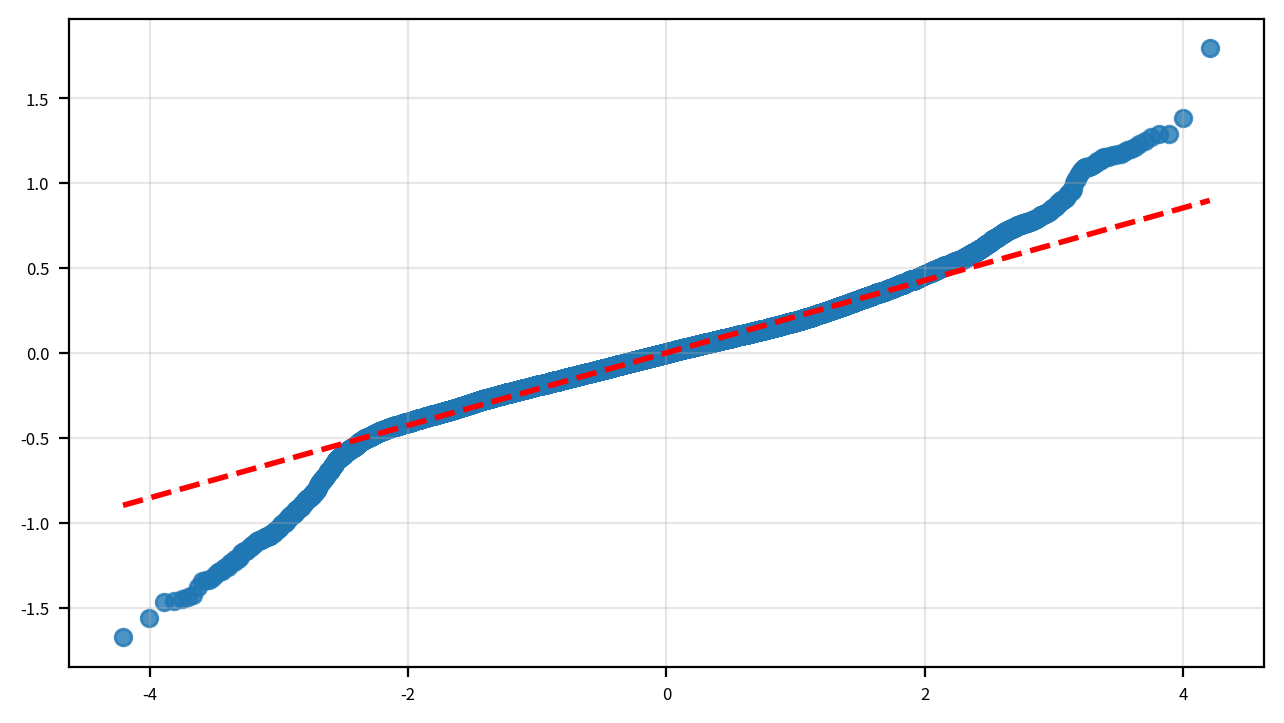

루트 1MSE 구간에 포함된 잔차 비율: 74.04%
루트 2MSE 구간에 포함된 잔차 비율: 95.52%
루트 3MSE 구간에 포함된 잔차 비율: 98.87%


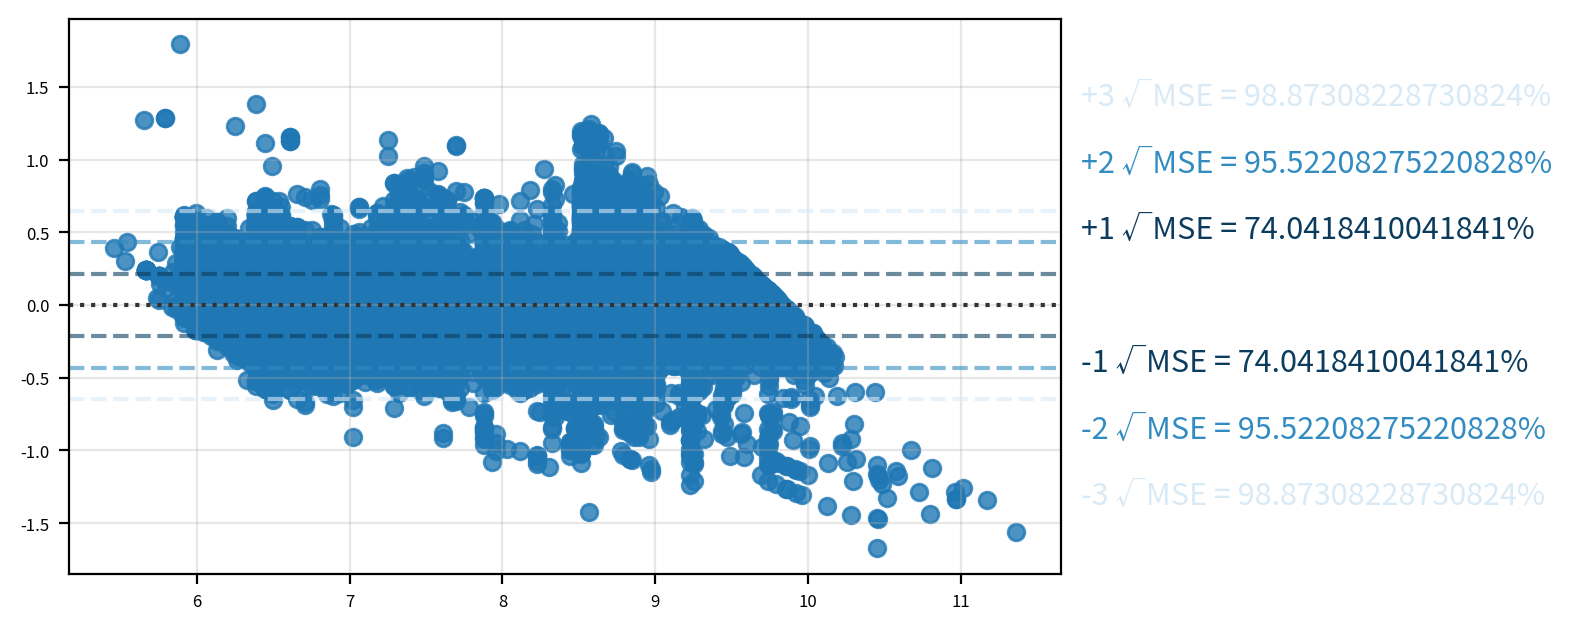

🎯 잔차의 정규성, 등분산성, 독립성 검정
Anderson-Darling statistic: 167.8061, 5% 임계값: 0.7870
정규성 가정 위배 가능성이 있음 (5% 유의수준)
Breusch-Pagan statistic: 88.668, p-value = 0.000
이분산성 존재(등분산 아님)
Durbin-Watson=1.332
잔차에 양(+)의 자기상관이 존재할 가능성 있음 (독립성 위반)
🎓 최종 결과 보고
log_price에 대하여 log_carat,color_F,color_G,clarity_SI2,cut_clarity_Fair_SI2,cut_clarity_Good_VS2,cut_clarity_Ideal_SI2,cut_clarity_Premium_SI2,cut_clarity_Very Good_SI2,cut_color_Fair_F,cut_color_Fair_G,cut_color_Good_G,cut_color_Ideal_J,cut_color_Premium_F,cut_color_Premium_G,color_clarity_D_SI2,color_clarity_E_SI2,color_clarity_F_I1,color_clarity_F_IF,color_clarity_F_SI2,color_clarity_F_VS1,color_clarity_F_VS2,color_clarity_F_VVS1,color_clarity_G_I1,color_clarity_G_IF,color_clarity_G_SI2,color_clarity_G_VS1,color_clarity_G_VVS1,color_clarity_H_SI2,color_clarity_J_SI2,color_clarity_J_VS1,color_clarity_J_VS2로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(32,53742)=3.537e+04, p <= 0.05).
log_carat의 회귀계수는 1.7676(p <= 0.05)로, log_price에 대하여 유의미한 예측변인인 것으로 나타났다.
co

In [102]:
# 잔차 검정
print("=" * 50)
print("📕 선형성 검정")
print("=" * 50)
reset_res = linear_reset(fit, power=2, use_f=True)
print(f"RESET F-statistic: {reset_res.fvalue:.4f}")
print(f"p-value: {reset_res.pvalue:.4f}")
if reset_res.pvalue < 0.05:
    print("선형성/기능형 위배 가능성이 있음 (5% 유의수준)")
else:
    print("선형성 가정 위배 근거 없음 (5% 유의수준)")

(x, y), _ = probplot(fit.resid)
width_px = 1280
height_px = 720
rows = 1
cols = 1
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)
sb.regplot(x=x, y=y, line_kws={"color": "red", "linestyle": "--", "linewidth": 2})
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
plt.close()

rr = fit.resid
mse_sq = fit.mse_resid
mse_root = np.sqrt(mse_sq)
colors = ["#0B3C5D", "#328CC1", "#D9EAF7"]
r1 = rr[(rr > -mse_root) & (rr < mse_root)].count() / rr.count() * 100
r2 = rr[(rr > -2 * mse_root) & (rr < 2 * mse_root)].count() / rr.count() * 100
r3 = rr[(rr > -3 * mse_root) & (rr < 3 * mse_root)].count() / rr.count() * 100
mse_r = [r1, r2, r3]
print(f"루트 1MSE 구간에 포함된 잔차 비율: {r1:.2f}%")
print(f"루트 2MSE 구간에 포함된 잔차 비율: {r2:.2f}%")
print(f"루트 3MSE 구간에 포함된 잔차 비율: {r3:.2f}%")
width_px = 1280
height_px = 720
rows = 1
cols = 1
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)
sb.residplot(x=fit.fittedvalues, y=fit.resid)
ax.grid(True, alpha=0.3)
for i, c in enumerate(colors):
    k = i + 1
    y_pos = k * mse_root
    ax.axhline(y=y_pos, color=c, linestyle="--", alpha=0.6)
    ax.axhline(y=-y_pos, color=c, linestyle="--", alpha=0.6)
    ax.text(
        x=1.02,
        y=0.5 + 0.12 * k,
        s=f"+{k} √MSE = {mse_r[i]}%",
        transform=ax.transAxes,
        ha="left",
        va="center",
        fontsize=11,
        color=c,
    )
    ax.text(
        x=1.02,
        y=0.5 - 0.12 * k,
        s=f"-{k} √MSE = {mse_r[i]}%",
        transform=ax.transAxes,
        ha="left",
        va="center",
        fontsize=11,
        color=c,
    )
plt.show()
plt.close()

# 잔차의 정규성, 등분산성, 독립성 검정
print("=" * 50)
print("🎯 잔차의 정규성, 등분산성, 독립성 검정")
print("=" * 50)
if len(origin) < 5000:
    method = "Shapiro-Wilk"
    s, p = shapiro(fit.resid)
    print(f"{method} statistic: {s:.4f}, p-value: {p:.4f}")
    violated = p < 0.05
else:
    method = "Anderson-Darling"
    ad_res = anderson(fit.resid, dist="norm")
    crit_levels = ad_res.significance_level.tolist()
    crit_values = ad_res.critical_values.tolist()
    crit_5 = crit_values[crit_levels.index(5.0)] if 5.0 in crit_levels else None
    print(f"{method} statistic: {ad_res.statistic:.4f}, 5% 임계값: {crit_5:.4f}")
    violated = crit_5 is not None and ad_res.statistic > crit_5
print(
    "정규성 가정 위배 가능성이 있음 (5% 유의수준)"
    if violated
    else "정규성 가정 위배 근거 없음 (5% 유의수준)"
)

names = ["LM Statistic", "LM p-value", "F Statistic", "F p-value"]
bp_test = het_breuschpagan(fit.resid, fit.model.exog)
bp = DataFrame(bp_test, index=names, columns=["value"])
p_bp = bp.loc["F p-value", "value"]
print(
    f"Breusch-Pagan statistic: {bp.loc['F Statistic', 'value']:.3f}, p-value = {p_bp:.3f}"
)
print(f"{'이분산성 존재(등분산 아님)' if p_bp<=0.05 else '등분산성 만족'}")

dw = durbin_watson(fit.resid)
if 1.5 <= dw <= 2.5:
    interpretation = "잔차는 독립성을 만족함 (자기상관 없음)"
elif dw < 1.5:
    interpretation = "잔차에 양(+)의 자기상관이 존재할 가능성 있음 (독립성 위반)"
else:
    interpretation = "잔차에 음(-)의 자기상관이 존재할 가능성 있음 (독립성 위반)"
print(f"Durbin-Watson={dw:.3f}\n{interpretation}")

# 최종 결과 보고
print("=" * 50)
print("🎓 최종 결과 보고")
print("=" * 50)
print(m)
print("\n".join(v))


---

# 1사분위수_작업

**notebooks/seongyu/1사분위수_작업.ipynb**


In [103]:
from hossam import load_data
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
import numpy as np
import pandas as pd
from pandas import DataFrame
import statsmodels.api as sm
from statsmodels.stats.diagnostic import linear_reset
from scipy.stats import zscore, pearsonr, spearmanr, probplot, shapiro, kstest, anderson

from statsmodels.formula.api import ols
from statsmodels.stats.api import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson

from statsmodels.stats.outliers_influence import variance_inflation_factor

In [104]:
origin = pd.read_excel("1사분위수_데이터.xlsx")
df = origin.drop("Unnamed: 0", axis=1)
df.head()

price  carat      cut color clarity     x     y     z  depth  table
0    326   0.23    Ideal     E     SI2  3.95  3.98  2.43   61.5   55.0
1    326   0.21  Premium     E     SI1  3.89  3.84  2.31   59.8   61.0
2    327   0.23     Good     E     VS1  4.05  4.07  2.31   56.9   65.0
3    334   0.29  Premium     I     VS2  4.20  4.23  2.63   62.4   58.0
4    335   0.31     Good     J     SI2  4.34  4.35  2.75   63.3   58.0

In [105]:
def ols_report(tbl, data):
    xnames = [n for n in fit.model.exog_names if n != "const"]
    indi_mydata1 = data.filter(xnames)
    variables = []
    for i, v in enumerate(tbl.tables[1].data):
        name = v[0].strip()
        if name not in xnames:
            continue
        j = list(indi_mydata1.columns).index(name)
        vif = variance_inflation_factor(indi_mydata1, j)

        p = float(v[4].strip())
        stars = lambda p: (
            "***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else ""
        )

        variables.append(
            {
                "종속변수": yname,
                "독립변수": name,
                "B": v[1].strip(),
                "표준오차": v[2].strip(),
                "Beta": float(fit.params[name])
                * (data[name].std(ddof=1) / data[yname].std(ddof=1)),
                "t": "%s%s" % (v[3].strip(), stars(p)),
                "p-value": p,
                "공차": 1 / vif,
                "vif": vif,
            }
        )

    rdf = DataFrame(variables)

    if rdf.empty:
        return None, "데이터 없음", "모델 유의하지 않음", []

    result_dict = {}
    for i in [0, 2]:
        for item in tbl.tables[i].data:
            n = len(item)
            for j in range(0, n, 2):
                key = item[j].strip()[:-1]
                value = item[j + 1].strip()
                if not key or not value:
                    continue
                result_dict[key] = value

    result_report = f"R({result_dict['R-squared']}), R²({result_dict['Adj. R-squared']}), F({result_dict['F-statistic']}), 유의확률({result_dict['Prob (F-statistic)']}), Durbin-Watson({result_dict['Durbin-Watson']})"

    tpl = "%s에 대하여 %s로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 %s(F(%s,%s)=%s, p %s 0.05)."
    model_report = tpl % (
        rdf["종속변수"][0],
        ",".join(list(rdf["독립변수"])),
        (
            "유의하다"
            if float(result_dict["Prob (F-statistic)"]) <= 0.05
            else "유의하지 않다"
        ),
        result_dict["Df Model"],
        result_dict["Df Residuals"],
        result_dict["F-statistic"],
        "<=" if float(result_dict["Prob (F-statistic)"]) <= 0.05 else ">",
    )

    variable_reports = []
    s = "%s의 회귀계수는 %s(p %s 0.05)로, %s에 대하여 %s 예측변인인 것으로 나타났다."

    for i in rdf.index:
        row = rdf.iloc[i]
        variable_reports.append(
            s
            % (
                row["독립변수"],
                row["B"],
                "<=" if float(row["p-value"]) < 0.05 else ">",
                row["종속변수"],
                "유의미한" if float(row["p-value"]) < 0.05 else "유의하지 않은",
            )
        )

    return rdf, result_report, model_report, variable_reports

In [106]:
mydata = df
yname = "price"
# mydata1=mydata.copy()

mydata1 = mydata.drop(["cut", "color", "clarity"], axis=1)
x = mydata1.drop(yname, axis=1)
y = mydata1[yname]
x_input = sm.add_constant(x)
fit = sm.OLS(y, x_input).fit()
tbl1 = fit.summary()
rdf, r, m, v = ols_report(tbl1, mydata1)
print("=== 1차 회귀분석 ===")
display(rdf)

=== 1차 회귀분석 ===


종속변수   독립변수           B     표준오차      Beta           t  p-value        공차  \
0  price  carat    418.2261  177.342  0.139142      2.358*    0.018  0.000535   
1  price      x    712.1382   36.146  1.049620   19.702***    0.000  0.000079   
2  price      y  -1268.6392   54.634 -1.868168  -23.221***    0.000  0.000072   
3  price      z   1269.4950   97.301  1.191316   13.047***    0.000  0.000037   
4  price  depth    -64.9594    4.759 -0.501661  -13.650***    0.000  0.000099   
5  price  table     -7.9740    0.649 -0.111636  -12.286***    0.000  0.001115   

            vif  
0   1870.038224  
1  12623.340831  
2  13923.200928  
3  26980.367784  
4  10057.396023  
5    896.727561

> vif 값이 가장 높은 z를 제외하고 다시 분석

In [107]:
mydata = df
yname = "price"
# mydata1=mydata.copy()

mydata1 = mydata.drop(["z", "cut", "color", "clarity"], axis=1)
x = mydata1.drop(yname, axis=1)
y = mydata1[yname]
x_input = sm.add_constant(x)
fit = sm.OLS(y, x_input).fit()
tbl1 = fit.summary()
rdf, r, m, v = ols_report(tbl1, mydata1)
print("=== 2차 회귀분석 ===")
display(rdf)

=== 2차 회귀분석 ===


종속변수   독립변수          B     표준오차      Beta           t  p-value        공차  \
0  price  carat   435.4938  178.453  0.144887      2.440*    0.015  0.002625   
1  price      x   937.4507   31.953  1.381708   29.338***    0.000  0.000079   
2  price      y  -712.2624   34.367 -1.048861  -20.725***    0.000  0.000087   
3  price  depth    -7.4140    1.798 -0.057256   -4.123***    0.000  0.000982   
4  price  table    -7.4878    0.652 -0.104829  -11.483***    0.000  0.001537   

            vif  
0    380.945858  
1  12617.944299  
2  11533.773835  
3   1017.889284  
4    650.626360

> vif 값이 가장 높은 x를 제외하고 다시 분석

In [108]:
mydata = df
yname = "price"
# mydata1=mydata.copy()

mydata1 = mydata.filter(["price", "carat", "y", "depth", "table"])
x = mydata1.drop(yname, axis=1)
y = mydata1[yname]
x_input = sm.add_constant(x)
fit = sm.OLS(y, x_input).fit()
tbl1 = fit.summary()
rdf, r, m, v = ols_report(tbl1, mydata1)
print("=== 3차 회귀분석 ===")
display(rdf)

=== 3차 회귀분석 ===


종속변수   독립변수          B     표준오차      Beta           t  p-value        공차  \
0  price  carat  3430.9795  150.976  1.141469   22.725***      0.0  0.002922   
1  price      y  -462.6659   34.348 -0.681311  -13.470***      0.0  0.000370   
2  price  depth   -29.9997    1.676 -0.231679  -17.896***      0.0  0.001024   
3  price  table   -11.1659    0.660 -0.156323  -16.916***      0.0  0.001620   

           vif  
0   342.277100  
1  2705.743403  
2   976.634711  
3   617.237197

> vif 값이 가장 높은 y를 제외하고 다시 분석

In [109]:
mydata = df
yname = "price"
# mydata1=mydata.copy()

mydata1 = mydata.filter(["price", "carat", "depth", "table"])
x = mydata1.drop(yname, axis=1)
y = mydata1[yname]
x_input = sm.add_constant(x)
fit = sm.OLS(y, x_input).fit()
tbl1 = fit.summary()
rdf, r, m, v = ols_report(tbl1, mydata1)
print("=== 4차 회귀분석 ===")
display(rdf)

=== 4차 회귀분석 ===


종속변수   독립변수          B    표준오차      Beta           t  p-value        공차  \
0  price  carat  1420.3619  22.807  0.472547   62.278***      0.0  0.021959   
1  price  depth   -12.4372   1.061 -0.096049  -11.726***      0.0  0.002071   
2  price  table    -6.9298   0.584 -0.097018  -11.861***      0.0  0.002193   

          vif  
0   45.539408  
1  482.879830  
2  456.017822

> vif 값이 가장 높은 depth를 제외하고 다시 분석

In [110]:
mydata = df
yname = "price"
# mydata1=mydata.copy()

mydata1 = mydata.filter(["price", "carat", "table"])
x = mydata1.drop(yname, axis=1)
y = mydata1[yname]
x_input = sm.add_constant(x)
fit = sm.OLS(y, x_input).fit()
tbl1 = fit.summary()
rdf, r, m, v = ols_report(tbl1, mydata1)
print("=== 5차 회귀분석 ===")
display(rdf)

=== 5차 회귀분석 ===


종속변수   독립변수          B    표준오차      Beta          t  p-value        공차  \
0  price  carat  1405.3487  22.886  0.467552  61.406***      0.0  0.023342   
1  price  table    -4.3465   0.544 -0.060852  -7.992***      0.0  0.023342   

         vif  
0  42.840456  
1  42.840456

> carat과 table 모두 vif값은 동일하나, carat의 t값이 더 크기에 table을 제거 후 다시 분석

In [111]:
mydata = df
yname = "price"
# mydata1=mydata.copy()

mydata1 = mydata.filter(["price", "carat"])
x = mydata1.drop(yname, axis=1)
y = mydata1[yname]
x_input = sm.add_constant(x)
fit = sm.OLS(y, x_input).fit()
tbl1 = fit.summary()
print("=== 6차 회귀분석 ===")
display(tbl1)

=== 6차 회귀분석 ===


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.219
Model:                            OLS   Adj. R-squared:                  0.219
Method:                 Least Squares   F-statistic:                     3756.
Date:                Fri, 16 Jan 2026   Prob (F-statistic):               0.00
Time:                        17:19:07   Log-Likelihood:                -84508.
No. Observations:               13414   AIC:                         1.690e+05
Df Residuals:                   13412   BIC:                         1.690e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        222.2427      7.672     28.968      0.000     207.204     237.281
carat       1405.9612     22.940     61.289      0.000    1360.996    1450.926
==============================================================================
Omnibus:                      783.551   Durbin-Watson:                   0.198
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              299.587
Skew:                           0.070   Prob(JB):                     8.82e-66
Kurtosis:                       2.281   Cond. No.                         22.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

> 명목형 변수들을 다시 넣은 후 회귀분석 진행

In [112]:
mydata = df
yname = "price"
# mydata1=mydata.copy()

mydata1 = mydata.filter(["price", "carat", "cut", "color", "clarity"])
mydata2 = pd.get_dummies(mydata1, drop_first=True)
mydata2 = mydata2.astype(float)
x = mydata2.drop(yname, axis=1)
y = mydata2[yname]
x_input = sm.add_constant(x)
fit = sm.OLS(y, x_input).fit()
tbl1 = fit.summary()
rdf, r, m, v = ols_report(tbl1, mydata2)
print("=== 7차 회귀분석 ===")
display(rdf)

=== 7차 회귀분석 ===


종속변수           독립변수          B    표준오차      Beta           t  p-value  \
0   price          carat  2369.6077  16.399  0.788356  144.495***    0.000   
1   price       cut_Good     0.2244   9.369  0.000405       0.024    0.981   
2   price      cut_Ideal    55.8046   9.096  0.186729    6.135***    0.000   
3   price    cut_Premium    85.7268   9.156  0.236522    9.363***    0.000   
4   price  cut_Very Good     2.6157   9.157  0.007415       0.286    0.775   
5   price        color_E   -28.8420   2.493 -0.078330  -11.569***    0.000   
6   price        color_F   -49.6388   2.634 -0.124642  -18.847***    0.000   
7   price        color_G   -84.0879   2.538 -0.232261  -33.125***    0.000   
8   price        color_H  -139.0340   2.728 -0.332779  -50.970***    0.000   
9   price        color_I  -206.2285   3.160 -0.392256  -65.265***    0.000   
10  price        color_J  -276.3478   4.561 -0.324295  -60.587***    0.000   
11  price     clarity_IF   549.4899  12.123  0.767883   45.328***    0.000   
12  price    clarity_SI1   256.4699  11.560  0.709722   22.186***    0.000   
13  price    clarity_SI2   158.1546  11.706  0.281433   13.510***    0.000   
14  price    clarity_VS1   373.0122  11.688  0.940407   31.913***    0.000   
15  price    clarity_VS2   343.3884  11.609  0.999066   29.579***    0.000   
16  price   clarity_VVS1   479.1712  11.845  0.977975   40.454***    0.000   
17  price   clarity_VVS2   433.9810  11.784  0.984922   36.827***    0.000   

          공차        vif  
0   0.022835  43.792753  
1   0.092906  10.763592  
2   0.016777  59.604330  
3   0.035919  27.840331  
4   0.033277  30.050512  
5   0.396508   2.522020  
6   0.435747   2.294912  
7   0.362434   2.759121  
8   0.453419   2.205466  
9   0.572930   1.745413  
10  0.768275   1.301617  
11  0.142569   7.014141  
12  0.033131  30.182837  
13  0.087906  11.375828  
14  0.042696  23.421160  
15  0.029267  34.168478  
16  0.069147  14.461883  
17  0.055551  18.001399

> cut_Good과 cut_Very Good의 p-value 값이 0.05보다 크기 때문에 제거 후 다시 분석

In [113]:
mydata = df
yname = "price"
# mydata1=mydata.copy()

mydata1 = mydata.filter(["price", "carat", "cut", "color", "clarity"])
mydata2 = pd.get_dummies(mydata1, drop_first=True)
mydata2 = mydata2.astype(float)
mydata3 = mydata2.drop(["cut_Good", "cut_Very Good"], axis=1)
x = mydata3.drop(yname, axis=1)
y = mydata3[yname]
x_input = sm.add_constant(x)
fit = sm.OLS(y, x_input).fit()
tbl1 = fit.summary()
rdf, r, m, v = ols_report(tbl1, mydata3)
print("=== 8차 회귀분석 ===")
display(rdf)

=== 8차 회귀분석 ===


종속변수          독립변수          B    표준오차      Beta           t  p-value  \
0   price         carat  2368.9413  16.350  0.788135  144.894***      0.0   
1   price     cut_Ideal    53.8250   1.660  0.180105   32.426***      0.0   
2   price   cut_Premium    83.7727   2.005  0.231130   41.776***      0.0   
3   price       color_E   -28.8466   2.493 -0.078343  -11.572***      0.0   
4   price       color_F   -49.6651   2.633 -0.124708  -18.866***      0.0   
5   price       color_G   -84.0809   2.538 -0.232242  -33.125***      0.0   
6   price       color_H  -139.0692   2.727 -0.332863  -50.994***      0.0   
7   price       color_I  -206.2861   3.159 -0.392365  -65.306***      0.0   
8   price       color_J  -276.4080   4.560 -0.324366  -60.616***      0.0   
9   price    clarity_IF   550.1275  11.942  0.768774   46.067***      0.0   
10  price   clarity_SI1   257.0180  11.369  0.711239   22.607***      0.0   
11  price   clarity_SI2   158.6786  11.517  0.282366   13.778***      0.0   
12  price   clarity_VS1   373.6404  11.503  0.941991   32.481***      0.0   
13  price   clarity_VS2   344.0161  11.422  1.000892   30.119***      0.0   
14  price  clarity_VVS1   479.8445  11.658  0.979349   41.161***      0.0   
15  price  clarity_VVS2   434.6797  11.603  0.986508   37.464***      0.0   

          공차        vif  
0   0.024149  41.410351  
1   0.392725   2.546313  
2   0.583015   1.715223  
3   0.397088   2.518336  
4   0.435953   2.293826  
5   0.362574   2.758061  
6   0.453915   2.203057  
7   0.573263   1.744400  
8   0.768628   1.301019  
9   0.356608   2.804203  
10  0.090901  11.001000  
11  0.209149   4.781289  
12  0.124847   8.009824  
13  0.086099  11.614533  
14  0.206883   4.833644  
15  0.171795   5.820890

📕 선형성 검정
RESET F-statistic: 14.9890
p-value: 0.0001
선형성/기능형 위배 가능성이 있음 (5% 유의수준)


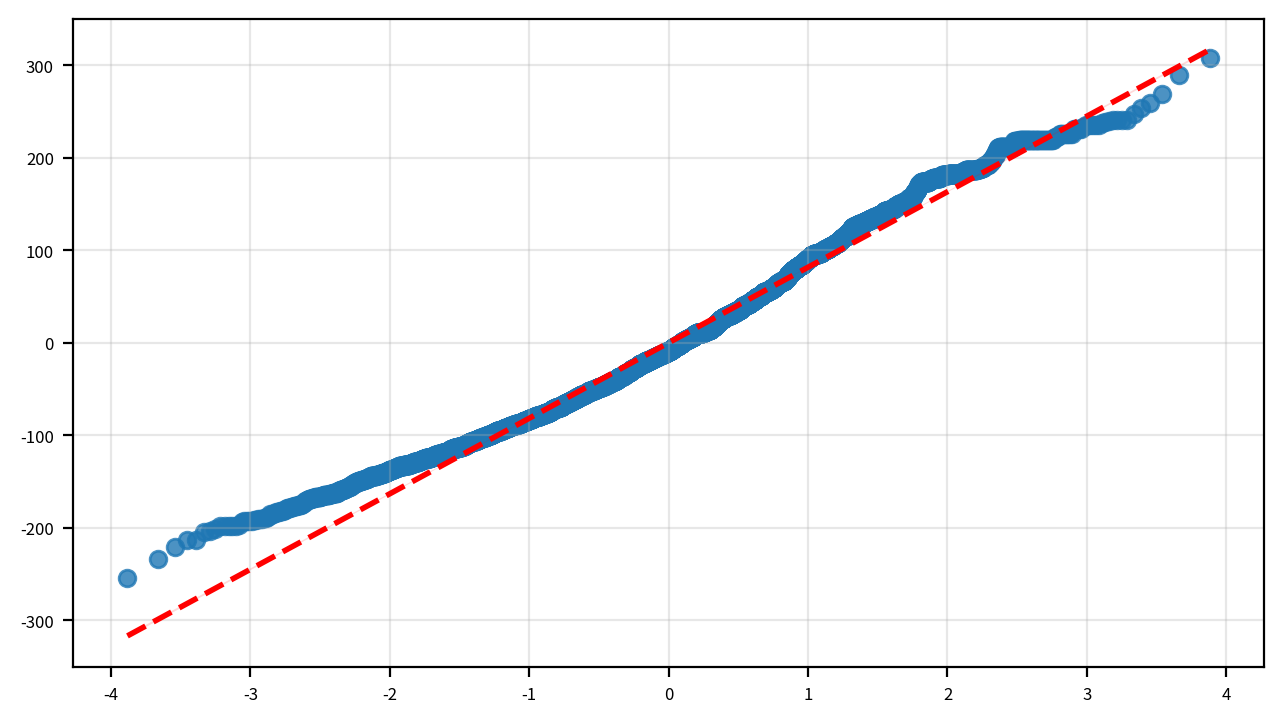

루트 1MSE 구간에 포함된 잔차 비율: 66.27%
루트 2MSE 구간에 포함된 잔차 비율: 95.51%
루트 3MSE 구간에 포함된 잔차 비율: 99.95%


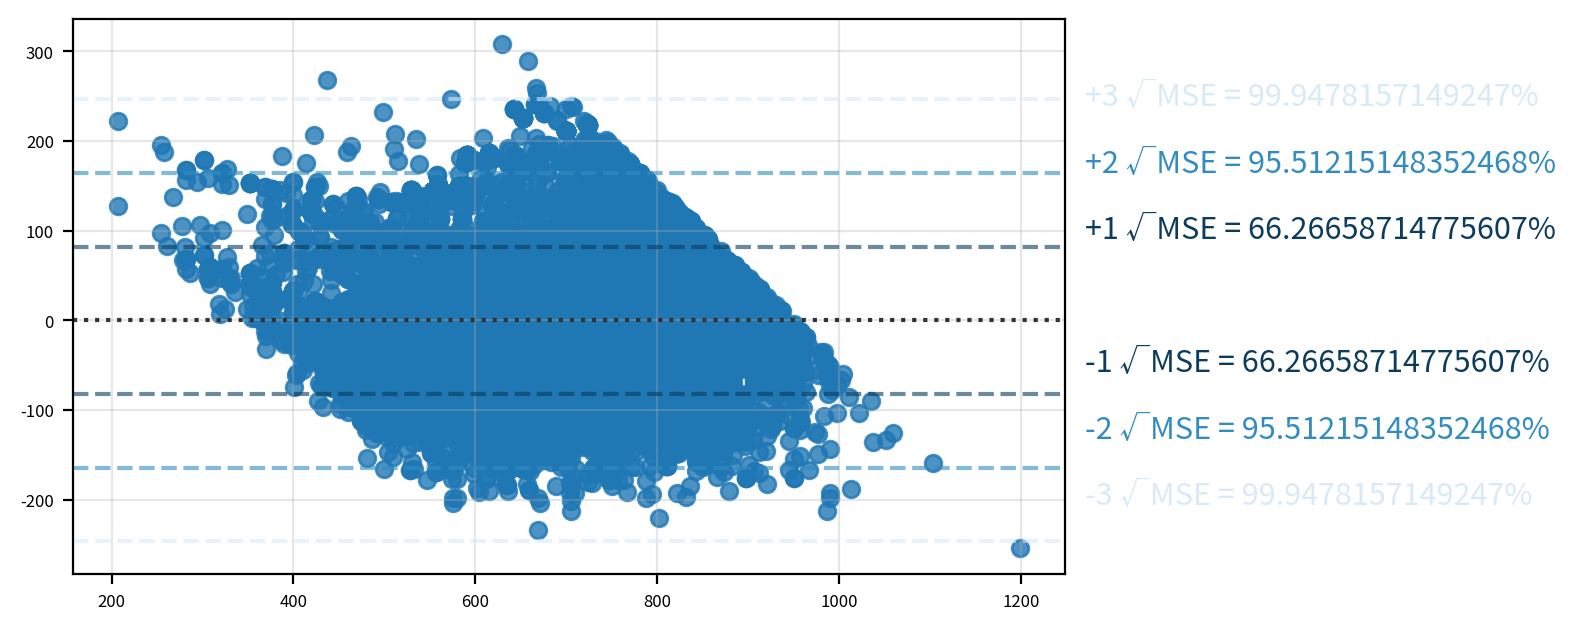

🎯 잔차의 정규성, 등분산성, 독립성 검정
Anderson-Darling statistic: 60.5857, 5% 임계값: 0.7870
정규성 가정 위배 가능성이 있음 (5% 유의수준)
Breusch-Pagan statistic: 22.376, p-value = 0.000
이분산성 존재(등분산 아님)
Durbin-Watson=0.571
잔차에 양(+)의 자기상관이 존재할 가능성 있음 (독립성 위반)
🎓 최종 결과 보고
price에 대하여 carat,cut_Ideal,cut_Premium,color_E,color_F,color_G,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(16,13397)=1917., p <= 0.05).
carat의 회귀계수는 2368.9413(p <= 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
cut_Ideal의 회귀계수는 53.8250(p <= 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
cut_Premium의 회귀계수는 83.7727(p <= 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
color_E의 회귀계수는 -28.8466(p <= 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
color_F의 회귀계수는 -49.6651(p <= 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
color_G의 회귀계수는 -84.0809(p <= 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
color_H의 회귀계수는 -139.0692(p <= 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
color_I의 회귀계수는 -206.2861(p <= 0.05)

In [114]:
# 잔차 검정
print("=" * 50)
print("📕 선형성 검정")
print("=" * 50)
reset_res = linear_reset(fit, power=2, use_f=True)
print(f"RESET F-statistic: {reset_res.fvalue:.4f}")
print(f"p-value: {reset_res.pvalue:.4f}")
if reset_res.pvalue < 0.05:
    print("선형성/기능형 위배 가능성이 있음 (5% 유의수준)")
else:
    print("선형성 가정 위배 근거 없음 (5% 유의수준)")

(x, y), _ = probplot(fit.resid)
width_px = 1280
height_px = 720
rows = 1
cols = 1
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)
sb.regplot(x=x, y=y, line_kws={"color": "red", "linestyle": "--", "linewidth": 2})
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
plt.close()

rr = fit.resid
mse_sq = fit.mse_resid
mse_root = np.sqrt(mse_sq)
colors = ["#0B3C5D", "#328CC1", "#D9EAF7"]
r1 = rr[(rr > -mse_root) & (rr < mse_root)].count() / rr.count() * 100
r2 = rr[(rr > -2 * mse_root) & (rr < 2 * mse_root)].count() / rr.count() * 100
r3 = rr[(rr > -3 * mse_root) & (rr < 3 * mse_root)].count() / rr.count() * 100
mse_r = [r1, r2, r3]
print(f"루트 1MSE 구간에 포함된 잔차 비율: {r1:.2f}%")
print(f"루트 2MSE 구간에 포함된 잔차 비율: {r2:.2f}%")
print(f"루트 3MSE 구간에 포함된 잔차 비율: {r3:.2f}%")
width_px = 1280
height_px = 720
rows = 1
cols = 1
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)
sb.residplot(x=fit.fittedvalues, y=fit.resid)
ax.grid(True, alpha=0.3)
for i, c in enumerate(colors):
    k = i + 1
    y_pos = k * mse_root
    ax.axhline(y=y_pos, color=c, linestyle="--", alpha=0.6)
    ax.axhline(y=-y_pos, color=c, linestyle="--", alpha=0.6)
    ax.text(
        x=1.02,
        y=0.5 + 0.12 * k,
        s=f"+{k} √MSE = {mse_r[i]}%",
        transform=ax.transAxes,
        ha="left",
        va="center",
        fontsize=11,
        color=c,
    )
    ax.text(
        x=1.02,
        y=0.5 - 0.12 * k,
        s=f"-{k} √MSE = {mse_r[i]}%",
        transform=ax.transAxes,
        ha="left",
        va="center",
        fontsize=11,
        color=c,
    )
plt.show()
plt.close()

# 잔차의 정규성, 등분산성, 독립성 검정
print("=" * 50)
print("🎯 잔차의 정규성, 등분산성, 독립성 검정")
print("=" * 50)
if len(origin) < 5000:
    method = "Shapiro-Wilk"
    s, p = shapiro(fit.resid)
    print(f"{method} statistic: {s:.4f}, p-value: {p:.4f}")
    violated = p < 0.05
else:
    method = "Anderson-Darling"
    ad_res = anderson(fit.resid, dist="norm")
    crit_levels = ad_res.significance_level.tolist()
    crit_values = ad_res.critical_values.tolist()
    crit_5 = crit_values[crit_levels.index(5.0)] if 5.0 in crit_levels else None
    print(f"{method} statistic: {ad_res.statistic:.4f}, 5% 임계값: {crit_5:.4f}")
    violated = crit_5 is not None and ad_res.statistic > crit_5
print(
    "정규성 가정 위배 가능성이 있음 (5% 유의수준)"
    if violated
    else "정규성 가정 위배 근거 없음 (5% 유의수준)"
)

names = ["LM Statistic", "LM p-value", "F Statistic", "F p-value"]
bp_test = het_breuschpagan(fit.resid, fit.model.exog)
bp = DataFrame(bp_test, index=names, columns=["value"])
p_bp = bp.loc["F p-value", "value"]
print(
    f"Breusch-Pagan statistic: {bp.loc['F Statistic', 'value']:.3f}, p-value = {p_bp:.3f}"
)
print(f"{'이분산성 존재(등분산 아님)' if p_bp<=0.05 else '등분산성 만족'}")

dw = durbin_watson(fit.resid)
if 1.5 <= dw <= 2.5:
    interpretation = "잔차는 독립성을 만족함 (자기상관 없음)"
elif dw < 1.5:
    interpretation = "잔차에 양(+)의 자기상관이 존재할 가능성 있음 (독립성 위반)"
else:
    interpretation = "잔차에 음(-)의 자기상관이 존재할 가능성 있음 (독립성 위반)"
print(f"Durbin-Watson={dw:.3f}\n{interpretation}")

# 최종 결과 보고
print("=" * 50)
print("🎓 최종 결과 보고")
print("=" * 50)
print(m)
print("\n".join(v))

In [115]:
r

'R(0.696), R²(0.696), F(1917.), 유의확률(0.00), Durbin-Watson(0.571)'


---

# q2

**notebooks/jinwoo/q2.ipynb**


In [116]:
# 라이브러리 기본 참조
from hossam import load_data
from pandas import DataFrame, concat, pivot_table, get_dummies, read_excel
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
import numpy as np
from scipy.stats import t, ttest_ind, normaltest, bartlett, levene
from math import sqrt


# 선형회귀를 위한 참조
import statsmodels.api as sm
from statsmodels.formula.api import ols

# 결과 검정을 위한 참조
from statsmodels.stats.diagnostic import linear_reset
from scipy.stats import zscore, probplot, shapiro, anderson, pearsonr, spearmanr
from statsmodels.stats.api import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from pingouin import anova, welch_anova, pairwise_tukey, pairwise_gameshowell

# VIF값을 계산하기 위한 참조
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statannotations.Annotator import Annotator

# 파이썬 기본 패키지
from itertools import combinations

In [117]:
origin = read_excel("2사분위수_데이터.xlsx")
dfq2 = origin.drop("Unnamed: 0", axis=1)
dfq2.head()

price  carat        cut color clarity     x     y     z  depth  table
0    949   0.35    Premium     J     VS1  5.67  5.64  3.53   62.4   58.0
1    949   0.40    Premium     E     VS2  4.79  4.68  2.90   61.2   60.0
2    949   0.30  Very Good     E      IF  4.29  4.32  2.62   60.9   59.0
3    949   0.41       Good     D    VVS2  4.71  4.73  2.99   63.3   59.0
4    949   0.30      Ideal     E    VVS2  4.35  4.37  2.65   60.8   56.0

In [118]:
def ols_report(tbl, data):
    """
    OLS summary(tbl)와 데이터프레임(data)을 받아 회귀계수 표(rdf),
    모델 적합도 요약(result_report), 모형 보고 문장(model_report),
    변수별 보고 리스트(variable_reports)를 반환한다.

    Parameters
    ----------
    tbl : statsmodels.iolib.summary.Summary
        sm.OLS(...).fit().summary() 결과로 생성된 summary 객체.
    data : pandas.DataFrame
        종속변수와 독립변수를 모두 포함한 데이터프레임.

    Returns
    -------
    tuple
        (회귀계수 DataFrame, 적합도 요약 문자열, 모형 보고 문자열, 변수별 보고 리스트)
    """

    # 독립변수 이름(상수항 제외)
    xnames = [n for n in fit.model.exog_names if n != "const"]

    # 독립변수 부분 데이터 (VIF 계산용)
    indi_df = data.filter(xnames)

    # 독립변수 결과를 누적
    variables = []

    for i, v in enumerate(tbl.tables[1].data):
        # 한 행의 변수명 추출 후 목록에 있는지 확인
        name = v[0].strip()
        if name not in xnames:
            continue

        # VIF 계산을 위해 열 인덱스 조회
        j = list(indi_df.columns).index(name)
        vif = variance_inflation_factor(indi_df, j)

        # 유의확률과 별표 표시 함수
        p = float(v[4].strip())

        def stars(p):
            return "***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else ""

        # 한 변수에 대한 보고 정보 추가
        variables.append(
            {
                "종속변수": yname,  # 종속변수 이름 (외부에서 정의)
                "독립변수": name,  # 독립변수 이름
                "B": v[1].strip(),  # 비표준화 회귀계수(B)
                "표준오차": v[2].strip(),  # 계수 표준오차
                "Beta": float(fit.params[name])
                * (
                    data[name].std(ddof=1) / data[yname].std(ddof=1)
                ),  # 표준화 회귀계수(β)
                "t": "%s%s" % (v[3].strip(), stars(p)),  # t-통계량(+별표)
                "p-value": p,  # 계수 유의확률
                "공차": 1 / vif,  # 공차(Tolerance = 1/VIF)
                "vif": vif,  # 분산팽창계수
            }
        )

    rdf = DataFrame(variables)

    # summary 표에서 적합도 정보를 key-value로 추출
    result_dict = {}
    for idx in [0, 2]:
        for item in tbl.tables[idx].data:
            n = len(item)
            for j in range(0, n, 2):
                key = item[j].strip()[:-1]
                value = item[j + 1].strip()
                if not key or not value:
                    continue
                result_dict[key] = value

    # 적합도 보고 문자열 구성
    result_report = (
        f"𝑅({result_dict['R-squared']}), "
        f"𝑅^2({result_dict['Adj. R-squared']}), "
        f"𝐹({result_dict['F-statistic']}), "
        f"유의확률({result_dict['Prob (F-statistic)']}), "
        f"Durbin-Watson({result_dict['Durbin-Watson']})"
    )

    # 모형 보고 문장 구성
    p_f = float(result_dict["Prob (F-statistic)"])
    sig_text = "유의하다" if p_f <= 0.05 else "유의하지 않다"
    p_sign = "≤" if p_f <= 0.05 else ">"

    tpl = (
        "%s에 대하여 %s로 예측하는 회귀분석을 실시한 결과, "
        "이 회귀모형은 통계적으로 %s(F(%s,%s) = %s, p %s 0.05)."
    )

    model_report = tpl % (
        rdf["종속변수"][0],
        ",".join(list(rdf["독립변수"])),
        sig_text,
        result_dict["Df Model"],
        result_dict["Df Residuals"],
        result_dict["F-statistic"],
        p_sign,
    )

    # 변수별 보고 문장 리스트 구성
    variable_reports = []
    s = "%s의 회귀계수는 %s(p %s 0.05)로, %s에 대하여 %s 예측변인인 것으로 나타났다."

    for i in rdf.index:
        row = rdf.iloc[i]
        p_val = float(row["p-value"])
        p_sign_var = "≤" if p_val < 0.05 else ">"
        sig_word = "유의미한" if p_val < 0.05 else "유의하지 않은"

        variable_reports.append(
            s
            % (
                row["독립변수"],
                row["B"],
                p_sign_var,
                row["종속변수"],
                sig_word,
            )
        )

    return rdf, result_report, model_report, variable_reports

In [119]:
dfq2.shape

(13462, 10)

In [120]:
dfq2["price"].agg(["count", "min", "median", "mean", "max"])

count     13462.000000
min         949.000000
median     1571.000000
mean       1561.147526
max        2400.000000
Name: price, dtype: float64

In [121]:
dfq2.describe().T

count         mean         std     min      25%      50%      75%  \
price  13462.0  1561.147526  442.840338  949.00  1133.00  1571.00  1917.00   
carat  13462.0     0.526674    0.124832    0.24     0.42     0.52     0.58   
x      13462.0     5.158122    0.400432    0.00     4.84     5.17     5.38   
y      13462.0     5.160296    0.461780    0.00     4.83     5.18     5.39   
z      13462.0     3.183147    0.357593    0.00     2.98     3.19     3.31   
depth  13462.0    61.677202    1.426259   52.20    61.00    61.70    62.40   
table  13462.0    57.228049    2.255112   51.00    56.00    57.00    58.00   

           max  
price  2400.00  
carat     1.21  
x         6.86  
y        31.80  
z        31.80  
depth    78.20  
table    79.00

“Q2 구간의 표본수는 n = 13,462이며, 가격은 최소 949달러 ~ 최대 2,400달러 범위에 분포한다.”

In [122]:
dfq2_1 = dfq2.filter(["price", "carat", "x", "y", "z", "depth", "table"]).copy()

##dfq2_1 = get_dummies(dfq2_1, columns=["cut", "color", "clarity"], dtype="int", drop_first=True)

yname = "price"

x = dfq2_1.drop(yname, axis=1)
y = dfq2_1[yname]

x_input = sm.add_constant(x)
fit = sm.OLS(y, x_input).fit()
tbl1 = fit.summary()
print(tbl1)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.603
Model:                            OLS   Adj. R-squared:                  0.603
Method:                 Least Squares   F-statistic:                     3405.
Date:                Fri, 16 Jan 2026   Prob (F-statistic):               0.00
Time:                        17:19:09   Log-Likelihood:                -94912.
No. Observations:               13462   AIC:                         1.898e+05
Df Residuals:                   13455   BIC:                         1.899e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        885.0823    256.556      3.450      0.0

In [123]:
rdf, r, m, v = ols_report(tbl1, dfq2_1)
display(rdf)
print(m)

종속변수   독립변수          B     표준오차      Beta           t  p-value        공차  \
0  price  carat  1660.8497  105.129  0.468177   15.798***     0.00  0.005472   
1  price      x   308.2452   33.860  0.278726    9.104***     0.00  0.000476   
2  price      y    41.0218   10.274  0.042776    3.993***     0.00  0.002052   
3  price      z    22.3424    9.606  0.018041      2.326*     0.02  0.006188   
4  price  depth   -18.1602    2.326 -0.058489   -7.808***     0.00  0.001582   
5  price  table   -16.6240    1.174 -0.084656  -14.157***     0.00  0.001797   

           vif  
0   182.740338  
1  2101.791328  
2   487.414568  
3   161.598852  
4   632.133145  
5   556.517552

price에 대하여 carat,x,y,z,depth,table로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(6,13455) = 3405., p ≤ 0.05).


In [124]:
dfq2_2 = dfq2_1.drop("x", axis=1)
yname = "price"
x = dfq2_2.drop(yname, axis=1)
y = dfq2_2[yname]
x_input = sm.add_constant(x)
fit = sm.OLS(y, x_input).fit()
tbl1 = fit.summary()
rdf, r, m, v = ols_report(tbl1, dfq2_2)
display(rdf)
print(m)

종속변수   독립변수          B    표준오차      Beta           t  p-value        공차  \
0  price  carat  2545.1463  40.327  0.717451   63.113***      0.0  0.014940   
1  price      y    65.0126   9.960  0.067793    6.527***      0.0  0.002701   
2  price      z    35.0344   9.533  0.028290    3.675***      0.0  0.006244   
3  price  depth   -30.4748   1.898 -0.098150  -16.058***      0.0  0.002014   
4  price  table   -18.2845   1.164 -0.093111  -15.715***      0.0  0.002372   

          vif  
0   66.932516  
1  370.212426  
2  160.154214  
3  496.498912  
4  421.644660

price에 대하여 carat,y,z,depth,table로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(5,13456) = 4044., p ≤ 0.05).


In [125]:
dfq2_3 = dfq2_2.drop("depth", axis=1)
yname = "price"
x = dfq2_3.drop(yname, axis=1)
y = dfq2_3[yname]
x_input = sm.add_constant(x)
fit = sm.OLS(y, x_input).fit()
tbl1 = fit.summary()
rdf, r, m, v = ols_report(tbl1, dfq2_3)
display(rdf)
print(m)

종속변수   독립변수          B    표준오차      Beta           t  p-value        공차  \
0  price  carat  2395.4043  39.606  0.675241   60.480***    0.000  0.017105   
1  price      y   108.5127   9.676  0.113154   11.215***    0.000  0.002931   
2  price      z    10.7157   9.502  0.008653       1.128    0.259  0.007130   
3  price  table   -11.9359   1.105 -0.060782  -10.805***    0.000  0.005321   

          vif  
0   58.463045  
1  341.133603  
2  140.261033  
3  187.927362

price에 대하여 carat,y,z,table로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(4,13457) = 4898., p ≤ 0.05).


In [126]:
dfq2_4 = dfq2_3.drop("table", axis=1)
yname = "price"
x = dfq2_4.drop(yname, axis=1)
y = dfq2_4[yname]
x_input = sm.add_constant(x)
fit = sm.OLS(y, x_input).fit()
tbl1 = fit.summary()
rdf, r, m, v = ols_report(tbl1, dfq2_4)
display(rdf)
print(m)

종속변수   독립변수          B    표준오차      Beta          t  p-value        공차  \
0  price  carat  2331.6533  39.333  0.657270  59.280***    0.000  0.026345   
1  price      y   109.6208   9.717  0.114309  11.281***    0.000  0.007161   
2  price      z    21.4226   9.491  0.017299     2.257*    0.024  0.008016   

          vif  
0   37.957197  
1  139.649365  
2  124.747644

price에 대하여 carat,y,z로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(3,13458) = 6436., p ≤ 0.05).


In [127]:
dfq2_5 = dfq2_4.drop("y", axis=1)
yname = "price"
x = dfq2_5.drop(yname, axis=1)
y = dfq2_5[yname]
x_input = sm.add_constant(x)
fit = sm.OLS(y, x_input).fit()
tbl1 = fit.summary()
rdf, r, m, v = ols_report(tbl1, dfq2_5)
display(rdf)
print(m)

종속변수   독립변수          B    표준오차      Beta          t  p-value        공차  \
0  price  carat  2653.3451  27.218  0.747951  97.486***    0.000  0.030295   
1  price      z    30.3909   9.501  0.024541    3.199**    0.001  0.030295   

         vif  
0  33.008819  
1  33.008819

price에 대하여 carat,z로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(2,13459) = 9501., p ≤ 0.05).


In [128]:
df1q2 = dfq2.filter(["price", "carat", "cut", "color", "clarity"]).copy()

df1q2 = get_dummies(
    df1q2, columns=["cut", "color", "clarity"], dtype="int", drop_first=True
)

yname = "price"

x = df1q2.drop(yname, axis=1)
y = df1q2[yname]

x_input = sm.add_constant(x)
fit = sm.OLS(y, x_input).fit()
tbl1 = fit.summary()
print(tbl1)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     4119.
Date:                Fri, 16 Jan 2026   Prob (F-statistic):               0.00
Time:                        17:19:09   Log-Likelihood:                -88513.
No. Observations:               13462   AIC:                         1.771e+05
Df Residuals:                   13443   BIC:                         1.772e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -2114.2517     20.261   -104.349

In [129]:
rdf, r, m, v = ols_report(tbl1, df1q2)
display(rdf)
print(m)

종속변수           독립변수          B    표준오차      Beta           t  p-value  \
0   price          carat  4670.0579  17.987  1.316443  259.629***      0.0   
1   price       cut_Good    88.6587   9.983  0.054409    8.881***      0.0   
2   price      cut_Ideal   194.6242   8.968  0.219379   21.702***      0.0   
3   price    cut_Premium   168.1241   9.150  0.159096   18.374***      0.0   
4   price  cut_Very Good   141.6123   9.229  0.124855   15.344***      0.0   
5   price        color_E   -86.2959   5.004 -0.080954  -17.244***      0.0   
6   price        color_F  -141.5719   5.227 -0.126537  -27.085***      0.0   
7   price        color_G  -202.7447   5.230 -0.189485  -38.766***      0.0   
8   price        color_H  -315.3971   6.261 -0.220604  -50.372***      0.0   
9   price        color_I  -473.9949   7.473 -0.265691  -63.428***      0.0   
10  price        color_J  -670.1068   9.076 -0.293222  -73.836***      0.0   
11  price     clarity_IF  1638.7477  16.673  0.839693   98.288***      0.0   
12  price    clarity_SI1  1044.7059  14.259  0.963649   73.266***      0.0   
13  price    clarity_SI2   842.5338  14.294  0.600941   58.943***      0.0   
14  price    clarity_VS1  1342.1847  14.823  1.117620   90.546***      0.0   
15  price    clarity_VS2  1248.4336  14.554  1.187473   85.779***      0.0   
16  price   clarity_VVS1  1536.4277  15.808  1.043901   97.195***      0.0   
17  price   clarity_VVS2  1486.7495  15.336  1.066826   96.947***      0.0   

          공차        vif  
0   0.048813  20.486181  
1   0.296714   3.370250  
2   0.065232  15.330015  
3   0.129945   7.695561  
4   0.149941   6.669308  
5   0.408915   2.445496  
6   0.423114   2.363427  
7   0.373382   2.678223  
8   0.532017   1.879638  
9   0.613925   1.628863  
10  0.709205   1.410030  
11  0.332275   3.009558  
12  0.105785   9.453162  
13  0.172437   5.799221  
14  0.139927   7.146575  
15  0.100768   9.923802  
16  0.211815   4.721096  
17  0.189523   5.276407

price에 대하여 carat,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_E,color_F,color_G,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(18,13443) = 4119., p ≤ 0.05).


In [130]:
reset_res = linear_reset(fit, power=2, use_f=True)
print(f"RESET F-statistic: {reset_res.fvalue:.4f}")
print(f"p-value: {reset_res.pvalue:.4f}")
if reset_res.pvalue < 0.05:
    print("선형성/기능형 위배 가능성이 있음 (5% 유의수준)")
else:
    print("선형성 가정 위배 근거 없음 (5% 유의수준)")

RESET F-statistic: 74.1768
p-value: 0.0000
선형성/기능형 위배 가능성이 있음 (5% 유의수준)


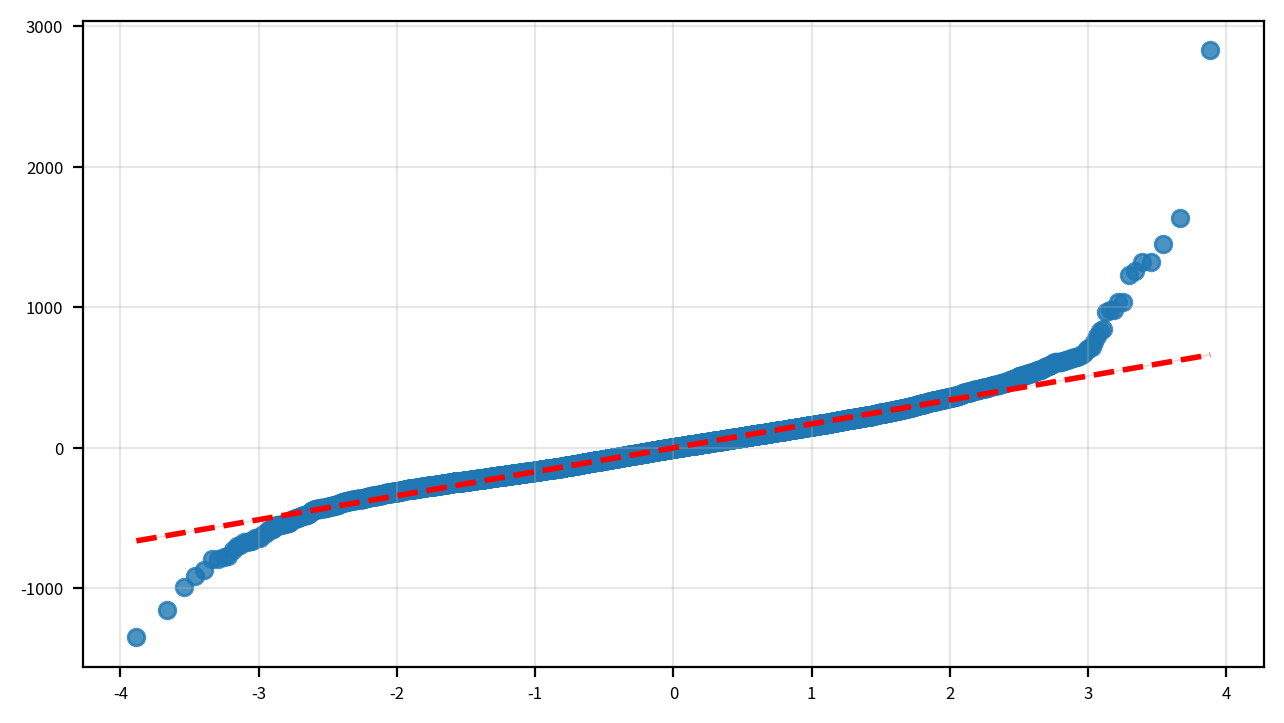

In [131]:
(x, y), _ = probplot(fit.resid)
# 1) 그래프 초기화
width_px = 1280  # 그래프 가로 크기
height_px = 720  # 그래프 세로 크기
rows = 1  # 그래프 행 수
cols = 1  # 그래프 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)
# 2) regplot 그리기
sb.regplot(
    x=x, y=y, line_kws={"color": "red", "linestyle": "--", "linewidth": 2}  # 점선
)
# 3) 그래프 꾸미기
ax.grid(True, alpha=0.3)  # 배경 격자 표시
# 4) 출력
plt.tight_layout()  # 여백 제거
plt.show()  # 그래프 화면 출력
plt.close()  # 그래프 작업 종료

In [132]:
r

'𝑅(0.847), 𝑅^2(0.846), 𝐹(4119.), 유의확률(0.00), Durbin-Watson(1.181)'

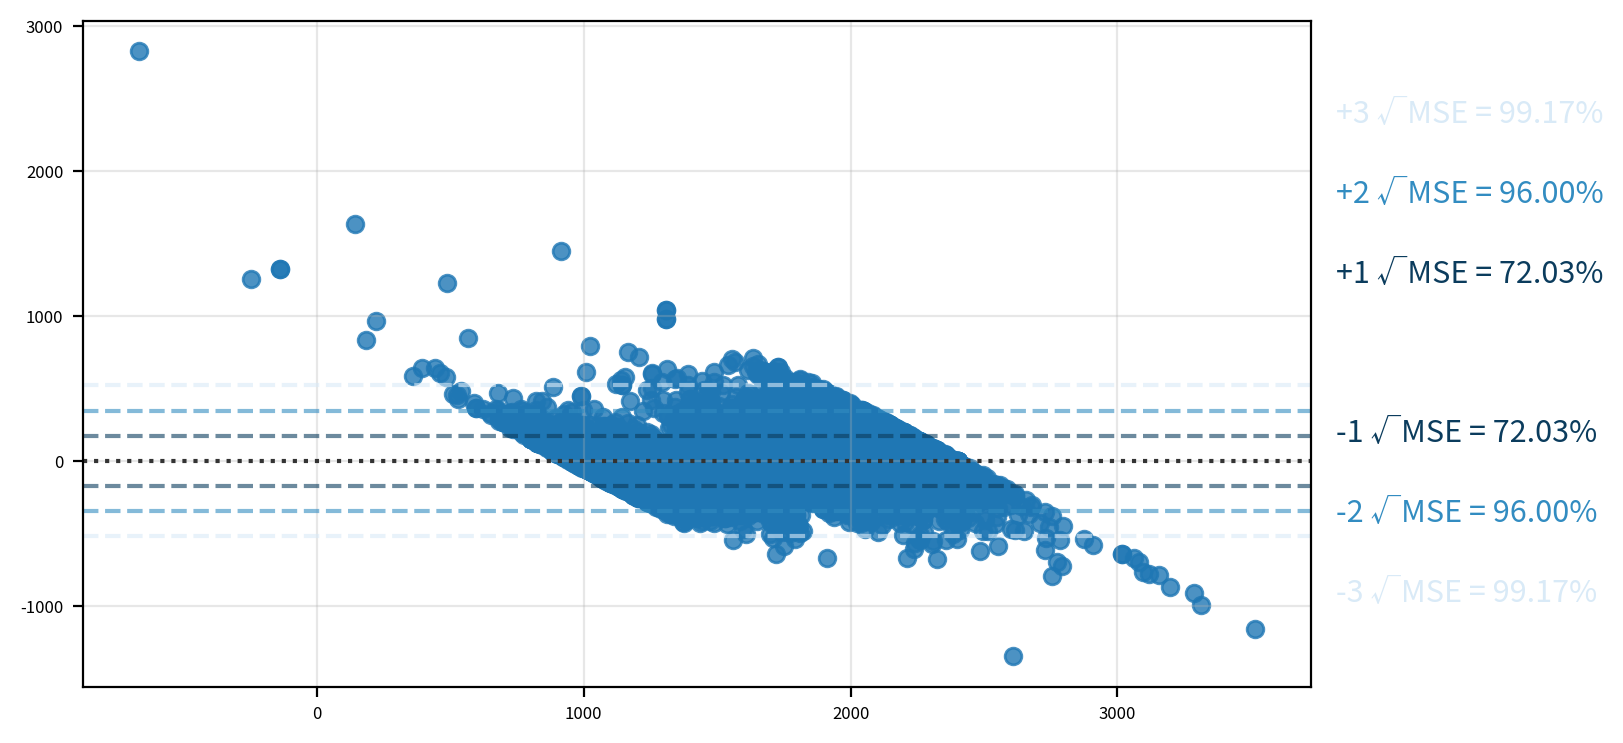

In [133]:
mse_sq = fit.mse_resid
mse_root = np.sqrt(mse_sq)
r = fit.resid  # 잔차

r1 = r[(r > -mse_root) & (r < mse_root)].count() / r.count() * 100
r2 = r[(r > -2 * mse_root) & (r < 2 * mse_root)].count() / r.count() * 100
r3 = r[(r > -3 * mse_root) & (r < 3 * mse_root)].count() / r.count() * 100

mse_r = [r1, r2, r3]

mse_r = [r1, r2, r3]
colors = ["#0B3C5D", "#328CC1", "#D9EAF7"]
xmax = fit.fittedvalues.max()
ymin = fit.fittedvalues.min()
# 1) 그래프 초기화
width_px = 1600
height_px = 720
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=my_dpi, constrained_layout=True)
# 2) seaborn 기본 잔차도
sb.residplot(x=fit.fittedvalues, y=fit.resid)
# 3) 꾸미기
ax.grid(True, alpha=0.3)
# 4) MSE 3단계 표시
for i, c in enumerate(colors):
    k = i + 1
    # 올바른 ±k√MSE 위치
    y_pos = k * mse_root
    ax.axhline(y=y_pos, color=c, linestyle="--", alpha=0.6)
    ax.axhline(y=-y_pos, color=c, linestyle="--", alpha=0.6)
    # 텍스트는 축 좌표계 사용 (그래프 밖으로 안 나감)
    ax.text(
        x=1.02,
        y=0.5 + 0.12 * k,
        s=f"+{k} √MSE = {mse_r[i]:0.2f}%",
        transform=ax.transAxes,
        ha="left",
        va="center",
        fontsize=11,
        color=c,
    )
    ax.text(
        x=1.02,
        y=0.5 - 0.12 * k,
        s=f"-{k} √MSE = {mse_r[i]:0.2f}%",
        transform=ax.transAxes,
        ha="left",
        va="center",
        fontsize=11,
        color=c,
    )
# 5) 출력
plt.show()
plt.close()

In [134]:
if len(df1q2) < 5000:
    method = "Shapiro-Wilk"
    stat, p = shapiro(fit.resid)
    print(f"{method} statistic: {stat:.4f}, p-value: {p:.4f}")
    violated = p < 0.05
else:
    method = "Anderson-Darling"
    ad_res = anderson(fit.resid, dist="norm")
    crit_levels = ad_res.significance_level.tolist()
    crit_values = ad_res.critical_values.tolist()
    crit_5 = crit_values[crit_levels.index(5.0)] if 5.0 in crit_levels else None
    print(f"{method} statistic: {ad_res.statistic:.4f}, 5% 임계값: {crit_5:.4f}")
    violated = crit_5 is not None and ad_res.statistic > crit_5
print(
    "정규성 가정 위배 가능성이 있음 (5% 유의수준)"
    if violated
    else "정규성 가정 위배 근거 없음 (5%유의수준)"
)

Anderson-Darling statistic: 23.5704, 5% 임계값: 0.7870
정규성 가정 위배 가능성이 있음 (5% 유의수준)


In [135]:
# Breusch–Pagan Test
names = ["LM Statistic", "LM p-value", "F Statistic", "F p-value"]
bp_test = het_breuschpagan(fit.resid, fit.model.exog)
bp = DataFrame(bp_test, index=names, columns=["value"])
# p-value는 F p-value를 기준으로 사용
p_bp = bp.loc["F p-value", "value"]
print(
    f"Breusch–Pagan statistic: {bp.loc['F Statistic','value']:.3f}, p-value ={p_bp:.3f}"
)
print(f"{'이분산성 존재(등분산 아님)' if p_bp <= 0.05 else '등분산성 만족'}")

Breusch–Pagan statistic: 35.228, p-value =0.000
이분산성 존재(등분산 아님)


In [136]:
m

'price에 대하여 carat,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_E,color_F,color_G,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(18,13443) = 4119., p ≤ 0.05).'

In [137]:
print("\n".join(v))

carat의 회귀계수는 4670.0579(p ≤ 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
cut_Good의 회귀계수는 88.6587(p ≤ 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
cut_Ideal의 회귀계수는 194.6242(p ≤ 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
cut_Premium의 회귀계수는 168.1241(p ≤ 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
cut_Very Good의 회귀계수는 141.6123(p ≤ 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
color_E의 회귀계수는 -86.2959(p ≤ 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
color_F의 회귀계수는 -141.5719(p ≤ 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
color_G의 회귀계수는 -202.7447(p ≤ 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
color_H의 회귀계수는 -315.3971(p ≤ 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
color_I의 회귀계수는 -473.9949(p ≤ 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
color_J의 회귀계수는 -670.1068(p ≤ 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
clarity_IF의 회귀계수는 1638.7477(p ≤ 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
clarity_SI1의 회귀계수는 1044.7059(p ≤ 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
clarity_SI2의 회귀계수는 842.5338(p ≤ 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
clarity_VS1의 회귀계수는 


---

# Q3

**notebooks/jiyoung/work1.ipynb**


In [138]:
from hossam import load_data
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
import numpy as np
import pandas as pd
from pandas import DataFrame
import statsmodels.api as sm
from statsmodels.stats.diagnostic import linear_reset
from scipy.stats import zscore, pearsonr, spearmanr, probplot, shapiro, kstest, anderson

from statsmodels.formula.api import ols
from statsmodels.stats.api import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [139]:
origin = pd.read_excel("3사분위수_데이터.xlsx")
df = origin.drop("Unnamed: 0", axis=1)
df.head()

price  carat        cut color clarity     x     y     z  depth  table
0   2757   0.70      Ideal     E     SI1  5.70  5.72  3.57   62.5   57.0
1   2757   0.86       Fair     E     SI2  6.45  6.33  3.52   55.1   69.0
2   2757   0.70      Ideal     G     VS2  5.70  5.67  3.50   61.6   56.0
3   2759   0.71  Very Good     E     VS2  5.68  5.73  3.56   62.4   57.0
4   2759   0.78  Very Good     G     SI2  5.81  5.85  3.72   63.8   56.0

In [140]:
def ols_report(tbl, data):
    """
    OLS summary(tbl)와 데이터프레임(data)을 받아 회귀계수 표(rdf),
    모델 적합도 요약(result_report), 모형 보고 문장(model_report),
    변수별 보고 리스트(variable_reports)를 반환한다.
    Parameters
    ---------
    tbl : statsmodels.iolib.summary.Summary
        sm.OLS(...).fit().summary() 결과로 생성된 summary 객체.
    data : pandas.DataFrame
        종속변수와 독립변수를 모두 포함한 데이터프레임.
    Returns
    ------
    tuple
        (회귀계수 DataFrame, 적합도 요약 문자열, 모형 보고 문자열, 변수별 보고 리스트)
    """
    # 독립변수 이름(상수항 제외)
    xnames = [n for n in fit.model.exog_names if n != "const"]

    # 독립변수 부분 데이터(VIF 계산용)
    indi_df = data.filter(xnames)

    # 독립변수 결과를 누적
    variables = []
    for i, v in enumerate(tbl.tables[1].data):
        # 한 행의 변수명 추출 후 목록에 있는지 확인
        name = v[0].strip()
        if name not in xnames:
            continue
        # VIF계산을 위해 열 인덱스 조회
        j = list(indi_df.columns).index(name)
        vif = variance_inflation_factor(indi_df, j)

        # 유의확률과 별표 표시 함수
        p = float(v[4].strip())
        stars = lambda p: (
            "***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else ""
        )

        # 한 변수에 대한 보고 정보 추가
        variables.append(
            {
                "종속변수": yname,
                "독립변수": name,
                "B": v[1].strip(),
                "표준오차": v[2].strip(),
                "Beta": float(fit.params[name])
                * (data[name].std(ddof=1) / data[yname].std(ddof=1)),  # 표준화 회귀계수
                "t": "%s%s" % (v[3].strip(), stars(p)),  # t-통계량(+별표)
                "p-value": p,
                "공차": 1 / vif,
                "vif": vif,
            }
        )

    rdf = DataFrame(variables)

    # summary 표에서 적합도 정보를 key-value로 추출
    result_dict = {}
    for i in [0, 2]:
        for item in tbl.tables[i].data:
            n = len(item)
            for i in range(0, n, 2):
                key = item[i].strip()[:-1]
                value = item[i + 1].strip()
                if not key or not value:
                    continue
                result_dict[key] = value

    # 적합도 보고 문자열 구성
    result_report = f"𝑅({result_dict['R-squared']}), 𝑅^2({result_dict['Adj. R-squared']}), 𝐹({result_dict['F-statistic']}), 유의확률({result_dict['Prob (F-statistic)']}), Durbin-Watson({result_dict['Durbin-Watson']})"
    # 모형 보고 문장 구성
    tpl = "%s에 대하여 %s로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 %s(F(%s,%s) = %s, p %s 0.05)."
    model_report = tpl % (
        rdf["종속변수"][0],
        ",".join(list(rdf["독립변수"])),
        (
            "유의하다"
            if float(result_dict["Prob (F-statistic)"]) <= 0.05
            else "유의하지 않다"
        ),
        result_dict["Df Model"],
        result_dict["Df Residuals"],
        result_dict["F-statistic"],
        "<=" if float(result_dict["Prob (F-statistic)"]) <= 0.05 else ">",
    )

    # 변수별 보고 문장 리스트 구성
    variable_reports = []
    s = "%s의 회귀계수는 %s(p %s 0.05)로, %s에 대하여 %s 예측변인인 것으로 나타났다."

    for i in rdf.index:
        row = rdf.iloc[i]
        variable_reports.append(
            s
            % (
                row["독립변수"],
                row["B"],
                "<=" if float(row["p-value"]) < 0.05 else ">",
                row["종속변수"],
                "유의미한" if float(row["p-value"]) < 0.05 else "유의하지 않은",
            )
        )
        return rdf, result_report, model_report, variable_reports

In [141]:
mydata = df
yname = "price"

mydata1 = mydata.drop(["cut", "color", "clarity"], axis=1)
x = mydata1.drop(yname, axis=1)
y = mydata1[yname]
x_input = sm.add_constant(x)
fit = sm.OLS(y, x_input).fit()
tbl1 = fit.summary()
rdf, r, m, v = ols_report(tbl1, mydata1)
print("=== 1차 회귀분석 ===")
display(rdf)

=== 1차 회귀분석 ===


종속변수   독립변수          B     표준오차      Beta           t  p-value        공차  \
0  price  carat  1946.6252  143.683  0.396070   13.548***    0.000  0.003910   
1  price      x  -726.4866   68.915 -0.346030  -10.542***    0.000  0.000150   
2  price      y  1373.0672   73.655  0.630631   18.642***    0.000  0.000166   
3  price      z   262.1352   59.605  0.081898    4.398***    0.000  0.000537   
4  price  depth   -10.4435    5.652 -0.020124      -1.848    0.065  0.000954   
5  price  table   -16.0639    2.275 -0.043664   -7.060***    0.000  0.001704   

           vif  
0   255.742845  
1  6654.912465  
2  6037.686501  
3  1862.848148  
4  1048.729956  
5   586.964672

vif값이 가장 높은 x제거하고 다시 분석

In [142]:
mydata = df
yname = "price"

mydata1 = mydata.drop(["x", "cut", "color", "clarity"], axis=1)
x = mydata1.drop(yname, axis=1)
y = mydata1[yname]
x_input = sm.add_constant(x)
fit = sm.OLS(y, x_input).fit()
tbl1 = fit.summary()
rdf, r, m, v = ols_report(tbl1, mydata1)
print("=== 2차 회귀분석 ===")
display(rdf)

=== 2차 회귀분석 ===


종속변수   독립변수          B     표준오차      Beta          t  p-value        공차  \
0  price  carat  1453.0945  136.396  0.295654  10.653***    0.000  0.003928   
1  price      y  1005.3187   65.135  0.461729  15.434***    0.000  0.000648   
2  price      z     9.8239   54.812  0.003069      0.179    0.858  0.000593   
3  price  depth    12.8672    5.222  0.024794     2.464*    0.014  0.000983   
4  price  table   -17.1062    2.282 -0.046496  -7.495***    0.000  0.001807   

           vif  
0   254.563716  
1  1542.456651  
2  1686.834004  
3  1017.340719  
4   553.435859

vif값이 가장 높은 z를 제거하고 다시분석

In [143]:
mydata = df
yname = "price"

mydata1 = mydata.drop(["z", "x", "cut", "color", "clarity"], axis=1)
x = mydata1.drop(yname, axis=1)
y = mydata1[yname]
x_input = sm.add_constant(x)
fit = sm.OLS(y, x_input).fit()
tbl1 = fit.summary()
rdf, r, m, v = ols_report(tbl1, mydata1)
print("=== 3차 회귀분석 ===")
display(rdf)

=== 3차 회귀분석 ===


종속변수   독립변수          B     표준오차      Beta          t  p-value        공차  \
0  price  carat  1456.2459  135.253  0.296295  10.767***    0.000  0.005948   
1  price      y  1010.0124   59.636  0.463885  16.936***    0.000  0.000735   
2  price  depth    13.4065    4.268  0.025833    3.141**    0.002  0.002013   
3  price  table   -17.1148    2.282 -0.046520  -7.500***    0.000  0.001873   

           vif  
0   168.120392  
1  1361.026505  
2   496.887068  
3   533.992185

vif값이 가장 높은 y를 제거하고 다시 분석

In [144]:
mydata = df
yname = "price"

mydata1 = mydata.drop(["y", "z", "x", "cut", "color", "clarity"], axis=1)
x = mydata1.drop(yname, axis=1)
y = mydata1[yname]
x_input = sm.add_constant(x)
fit = sm.OLS(y, x_input).fit()
tbl1 = fit.summary()
rdf, r, m, v = ols_report(tbl1, mydata1)
print("=== 4차 회귀분석 ===")
display(rdf)

=== 4차 회귀분석 ===


종속변수   독립변수          B    표준오차      Beta           t  p-value        공차  \
0  price  carat  3694.2077  29.155  0.751642  126.711***      0.0  0.034093   
1  price  depth   -36.0178   3.147 -0.069403  -11.444***      0.0  0.002844   
2  price  table   -25.1729   2.255 -0.068423  -11.162***      0.0  0.002779   

          vif  
0   29.331300  
1  351.668719  
2  359.895143

vif값이 가장 높은 table을 제외하고 다시 분석

In [145]:
mydata = df
yname = "price"

mydata1 = mydata.filter(["price", "carat", "depth"])
x = mydata1.drop(yname, axis=1)
y = mydata1[yname]
x_input = sm.add_constant(x)
fit = sm.OLS(y, x_input).fit()
tbl1 = fit.summary()
rdf, r, m, v = ols_report(tbl1, mydata1)
print("===5차 회귀분석")
display(rdf)

===5차 회귀분석


종속변수   독립변수          B    표준오차      Beta           t  p-value        공차  \
0  price  carat  3631.4652  28.739  0.738876  126.362***      0.0  0.035249   
1  price  depth   -26.1518   3.035 -0.050392   -8.618***      0.0  0.035249   

        vif  
0  28.36981  
1  28.36981

carat과 depth 모두 vif값은 동일하나, carat의 t 값이 더 크기에 depth을 제거 후 다시 분석

In [146]:
mydata = df
yname = "price"
# mydata1=mydata.copy()

mydata1 = mydata.filter(["price", "carat"])
x = mydata1.drop(yname, axis=1)
y = mydata1[yname]
x_input = sm.add_constant(x)
fit = sm.OLS(y, x_input).fit()
tbl1 = fit.summary()
print("=== 6차 회귀분석 ===")
display(tbl1)

=== 6차 회귀분석 ===


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.540
Method:                 Least Squares   F-statistic:                 1.581e+04
Date:                Fri, 16 Jan 2026   Prob (F-statistic):               0.00
Time:                        17:19:10   Log-Likelihood:            -1.0473e+05
No. Observations:               13461   AIC:                         2.095e+05
Df Residuals:                   13459   BIC:                         2.095e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        508.7249     26.547     19.163      0.000     456.690     560.760
carat       3612.1279     28.729    125.732      0.000    3555.815    3668.440
==============================================================================
Omnibus:                      102.270   Durbin-Watson:                   0.903
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              152.946
Skew:                          -0.059   Prob(JB):                     6.14e-34
Kurtosis:                       3.509   Cond. No.                         10.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

명목형 변수들을 다시 넣은 후 회귀분석

In [147]:
mydata = df
yname = "price"
# mydata1=mydata.copy()

mydata1 = mydata.filter(["price", "carat", "cut", "color", "clarity"])
mydata2 = pd.get_dummies(mydata1, drop_first=True)
mydata2 = mydata2.astype(float)
x = mydata2.drop(yname, axis=1)
y = mydata2[yname]
x_input = sm.add_constant(x)
fit = sm.OLS(y, x_input).fit()
tbl1 = fit.summary()
rdf, r, m, v = ols_report(tbl1, mydata2)
print("=== 7차 회귀분석 ===")
display(rdf)

=== 7차 회귀분석 ===


종속변수           독립변수           B    표준오차      Beta           t  p-value  \
0   price          carat   6194.6032  30.355  1.260385  204.070***      0.0   
1   price       cut_Good    341.8515  18.411  0.130845   18.567***      0.0   
2   price      cut_Ideal    593.3180  16.939  0.323916   35.026***      0.0   
3   price    cut_Premium    373.7509  16.926  0.191953   22.082***      0.0   
4   price  cut_Very Good    460.0712  17.075  0.233518   26.944***      0.0   
5   price        color_E   -167.7263  12.597 -0.076014  -13.315***      0.0   
6   price        color_F   -255.3630  12.576 -0.116898  -20.306***      0.0   
7   price        color_G   -426.5867  13.081 -0.185612  -32.610***      0.0   
8   price        color_H   -533.6424  13.440 -0.235285  -39.707***      0.0   
9   price        color_I   -921.5333  15.276 -0.334971  -60.324***      0.0   
10  price        color_J  -1295.5036  19.019 -0.355625  -68.115***      0.0   
11  price     clarity_IF   2891.0478  41.038  0.379266   70.448***      0.0   
12  price    clarity_SI1   1949.8328  24.556  1.052545   79.404***      0.0   
13  price    clarity_SI2   1465.1344  23.876  0.789549   61.364***      0.0   
14  price    clarity_VS1   2310.0013  27.374  0.835077   84.388***      0.0   
15  price    clarity_VS2   2149.7789  26.155  0.930813   82.194***      0.0   
16  price   clarity_VVS1   2784.1167  32.649  0.591248   85.274***      0.0   
17  price   clarity_VVS2   2526.7679  30.584  0.642787   82.616***      0.0   

          공차        vif  
0   0.038367  26.064318  
1   0.315969   3.164869  
2   0.154517   6.471774  
3   0.177683   5.628014  
4   0.184513   5.419684  
5   0.415748   2.405304  
6   0.402062   2.487180  
7   0.418563   2.389129  
8   0.384734   2.599197  
9   0.477198   2.095566  
10  0.585707   1.707338  
11  0.797031   1.254656  
12  0.121863   8.205914  
13  0.113017   8.848240  
14  0.307909   3.247716  
15  0.222048   4.503530  
16  0.594084   1.683264  
17  0.505423   1.978540

📕 선형성 검정
RESET F-statistic: 1097.7389
p-value: 0.0000
선형성/기능형 위배 가능성이 있음 (5% 유의수준)


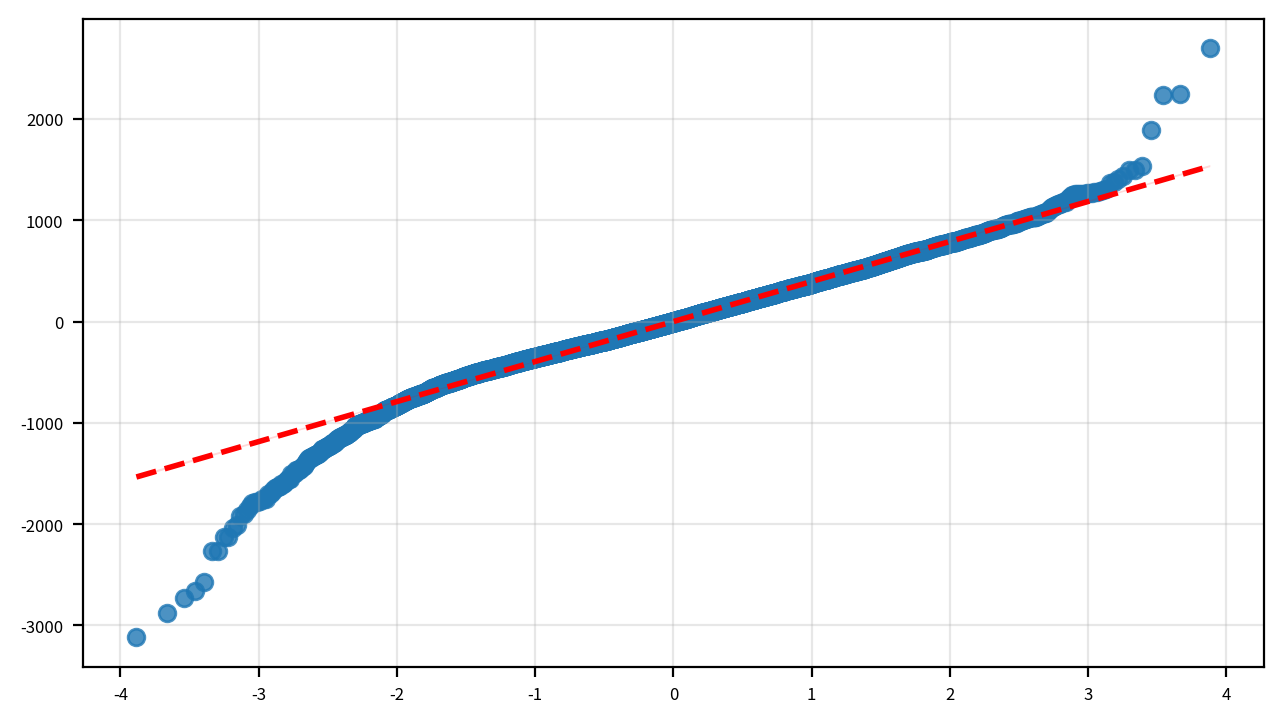

루트 1MSE 구간에 포함된 잔차 비율: 72.31%
루트 2MSE 구간에 포함된 잔차 비율: 95.51%
루트 3MSE 구간에 포함된 잔차 비율: 99.08%


🎯 잔차의 정규성, 등분산성, 독립성 검정
Anderson-Darling statistic: 20.2107, 5% 임계값: 0.7870
정규성 가정 위배 가능성이 있음 (5% 유의수준)
Breusch-Pagan statistic: 90.300, p-value = 0.000
이분산성 존재(등분산 아님)
Durbin-Watson=1.412
잔차에 양(+)의 자기상관이 존재할 가능성 있음 (독립성 위반)
🎓 최종 결과 보고
price에 대하여 carat,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_E,color_F,color_G,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(18,13442) = 2676., p <= 0.05).
carat의 회귀계수는 6194.6032(p <= 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.


In [148]:
# 잔차 검정
print("=" * 50)
print("📕 선형성 검정")
print("=" * 50)
reset_res = linear_reset(fit, power=2, use_f=True)
print(f"RESET F-statistic: {reset_res.fvalue:.4f}")
print(f"p-value: {reset_res.pvalue:.4f}")
if reset_res.pvalue < 0.05:
    print("선형성/기능형 위배 가능성이 있음 (5% 유의수준)")
else:
    print("선형성 가정 위배 근거 없음 (5% 유의수준)")

(x, y), _ = probplot(fit.resid)
width_px = 1280
height_px = 720
rows = 1
cols = 1
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)
sb.regplot(x=x, y=y, line_kws={"color": "red", "linestyle": "--", "linewidth": 2})
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
plt.close()

rr = fit.resid
mse_sq = fit.mse_resid
mse_root = np.sqrt(mse_sq)
colors = ["#0B3C5D", "#328CC1", "#D9EAF7"]
r1 = rr[(rr > -mse_root) & (rr < mse_root)].count() / rr.count() * 100
r2 = rr[(rr > -2 * mse_root) & (rr < 2 * mse_root)].count() / rr.count() * 100
r3 = rr[(rr > -3 * mse_root) & (rr < 3 * mse_root)].count() / rr.count() * 100
mse_r = [r1, r2, r3]
print(f"루트 1MSE 구간에 포함된 잔차 비율: {r1:.2f}%")
print(f"루트 2MSE 구간에 포함된 잔차 비율: {r2:.2f}%")
print(f"루트 3MSE 구간에 포함된 잔차 비율: {r3:.2f}%")
width_px = 1280
height_px = 720
rows = 1
cols = 1
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)
sb.residplot(x=fit.fittedvalues, y=fit.resid)
ax.grid(True, alpha=0.3)
for i, c in enumerate(colors):
    k = i + 1
    y_pos = k * mse_root
    ax.axhline(y=y_pos, color=c, linestyle="--", alpha=0.6)
    ax.axhline(y=-y_pos, color=c, linestyle="--", alpha=0.6)
    ax.text(
        x=1.02,
        y=0.5 + 0.12 * k,
        s=f"+{k} √MSE = {mse_r[i]}%",
        transform=ax.transAxes,
        ha="left",
        va="center",
        fontsize=11,
        color=c,
    )
    ax.text(
        x=1.02,
        y=0.5 - 0.12 * k,
        s=f"-{k} √MSE = {mse_r[i]}%",
        transform=ax.transAxes,
        ha="left",
        va="center",
        fontsize=11,
        color=c,
    )
plt.show()
plt.close()

# 잔차의 정규성, 등분산성, 독립성 검정
print("=" * 50)
print("🎯 잔차의 정규성, 등분산성, 독립성 검정")
print("=" * 50)
if len(origin) < 5000:
    method = "Shapiro-Wilk"
    s, p = shapiro(fit.resid)
    print(f"{method} statistic: {s:.4f}, p-value: {p:.4f}")
    violated = p < 0.05
else:
    method = "Anderson-Darling"
    ad_res = anderson(fit.resid, dist="norm")
    crit_levels = ad_res.significance_level.tolist()
    crit_values = ad_res.critical_values.tolist()
    crit_5 = crit_values[crit_levels.index(5.0)] if 5.0 in crit_levels else None
    print(f"{method} statistic: {ad_res.statistic:.4f}, 5% 임계값: {crit_5:.4f}")
    violated = crit_5 is not None and ad_res.statistic > crit_5
print(
    "정규성 가정 위배 가능성이 있음 (5% 유의수준)"
    if violated
    else "정규성 가정 위배 근거 없음 (5% 유의수준)"
)

names = ["LM Statistic", "LM p-value", "F Statistic", "F p-value"]
bp_test = het_breuschpagan(fit.resid, fit.model.exog)
bp = DataFrame(bp_test, index=names, columns=["value"])
p_bp = bp.loc["F p-value", "value"]
print(
    f"Breusch-Pagan statistic: {bp.loc['F Statistic', 'value']:.3f}, p-value = {p_bp:.3f}"
)
print(f"{'이분산성 존재(등분산 아님)' if p_bp<=0.05 else '등분산성 만족'}")

dw = durbin_watson(fit.resid)
if 1.5 <= dw <= 2.5:
    interpretation = "잔차는 독립성을 만족함 (자기상관 없음)"
elif dw < 1.5:
    interpretation = "잔차에 양(+)의 자기상관이 존재할 가능성 있음 (독립성 위반)"
else:
    interpretation = "잔차에 음(-)의 자기상관이 존재할 가능성 있음 (독립성 위반)"
print(f"Durbin-Watson={dw:.3f}\n{interpretation}")

# 최종 결과 보고
print("=" * 50)
print("🎓 최종 결과 보고")
print("=" * 50)
print(m)
print("\n".join(v))

p-value 값이 0.05보다 작기 때문에 잔차검정 진행

1. 연속형 변수만 선택
2. VIF 계산
4. 남은 연속형 고정
5. 명목형 더미화
6. 결합
7. 회귀
명목형 변수를 더미화할 경우 다중공선성 진단이 복잡해질 수 있어,
연속형 변수에 대해 먼저 VIF를 통해 구조적 공선성을 점검한 후
안정화된 모형에 명목형 변수를 추가하였다.

r

'𝑅(0.782), 𝑅^2(0.782), 𝐹(2676.), 유의확률(0.00), Durbin-Watson(1.412)'


---

# 명목추가

**notebooks/sooyoung/명목추가.ipynb**


# 연속형 변수 ---> 명목형 변수 추가

In [149]:
from pandas import DataFrame, melt
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
import numpy as np
import pandas as pd

In [150]:
origin = pd.read_excel("4사분위수_데이터.xlsx")
df = origin.drop("Unnamed: 0", axis=1)  # 콜론 뒤에 한 칸 띄어쓰기가 있는 경우 -> '~: 0'
df.head()

price  carat        cut color clarity     x     y     z  depth  table
0   5324   1.21    Premium     H     SI2  6.75  6.78  4.24   62.7   59.0
1   5324   1.21  Very Good     H     SI2  6.70  6.75  4.21   62.6   61.0
2   5324   1.21  Very Good     I     SI1  6.76  6.92  4.25   62.1   56.0
3   5324   1.21      Ideal     J     VS1  6.81  6.86  4.26   62.3   55.0
4   5324   0.90  Very Good     F     VS1  6.18  6.23  3.80   61.2   56.0

In [151]:
df["color"].nunique()
df["color"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 13457 entries, 0 to 13456
Series name: color
Non-Null Count  Dtype 
--------------  ----- 
13457 non-null  object
dtypes: object(1)
memory usage: 105.3+ KB


In [152]:
# 선형회귀를 위한 참조
import statsmodels.api as sm
from statsmodels.formula.api import ols

# 결과 검정을 위한 참조
from statsmodels.stats.diagnostic import linear_reset
from scipy.stats import zscore, probplot, shapiro, anderson
from statsmodels.stats.api import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson

# VIF값을 계산하기 위한 참조
from statsmodels.stats.outliers_influence import variance_inflation_factor

### 1. 결과 보고서 생성

In [153]:
def ols_report(tbl, data):
    """
    OLS summary(tbl)와 데이터프레임(data)을 받아 회귀계수 표(rdf),
    모델 적합도 요약(result_report), 모형 보고 문장(model_report),
    변수별 보고 리스트(variable_reports)를 반환한다.
    Parameters
    ---------
    tbl : statsmodels.iolib.summary.Summary
        sm.OLS(...).fit().summary() 결과로 생성된 summary 객체.
    data : pandas.DataFrame
        종속변수와 독립변수를 모두 포함한 데이터프레임.
    Returns
    ------
    tuple
        (회귀계수 DataFrame, 적합도 요약 문자열, 모형 보고 문자열, 변수별 보고 리스트)
    """
    # 독립변수 이름(상수항 제외)
    xnames = [n for n in fit.model.exog_names if n != "const"]

    # 독립변수 부분 데이터 (VIF 계산용)
    indi_df = data.filter(xnames)

    # 독립변수 결과를 누적
    variables = []
    for i, v in enumerate(tbl.tables[1].data):
        # 한 행의 변수명 추출 후 목록에 있는지 확인
        name = v[0].strip()
        if name not in xnames:
            continue

        # VIF 계산을 위해 열 인덱스 조회
        j = list(indi_df.columns).index(name)
        vif = variance_inflation_factor(indi_df, j)

        # 유의확률과 별표 표시 함수
        p = float(v[4].strip())
        stars = lambda p: (
            "//*" if p < 0.001 else "/*" if p < 0.01 else "*" if p < 0.05 else ""
        )

        # 한 변수에 대한 보고 정보 추가
        variables.append(
            {
                "종속변수": yname,  # 종속변수 이름
                "독립변수": name,  # 독립변수 이름
                "B": v[1].strip(),  # 비표준화 회귀계수(B)
                "표준오차": v[2].strip(),  # 계수 표준오차
                "Beta": float(fit.params[name])
                * (
                    data[name].std(ddof=1) / data[yname].std(ddof=1)
                ),  # 표준화 회귀계수(β)
                "t": "%s%s" % (v[3].strip(), stars(p)),  # t-통계량(+별표)
                "p-value": p,  # 계수 유의확률
                "공차": 1 / vif,  # 공차(Tolerance = 1/VIF)
                "vif": vif,  # 분산팽창계수
            }
        )

    rdf = DataFrame(variables)

    if rdf.empty:
        return None, "데이터 없음", "모델 유의하지 않음", []

    # summary 표에서 적합도 정보를 key-value로 추출
    result_dict = {}
    for i in [0, 2]:
        for item in tbl.tables[i].data:
            n = len(item)
            for i in range(0, n, 2):
                key = item[i].strip()[:-1]
                value = item[i + 1].strip()
                if not key or not value:
                    continue
                result_dict[key] = value

    # 적합도 보고 문자열 구성
    result_report = f"𝑅({result_dict['R-squared']}),𝑅^2({result_dict['Adj. R-squared']}), 𝐹({result_dict['F-statistic']}), 유의확률({result_dict['Prob (F-statistic)']}), Durbin-Watson({result_dict['Durbin-Watson']})"

    # 모형 보고 문장 구성
    tpl = "%s에 대하여 %s로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 %s(F(%s,%s) = %s, p %s 0.05)."
    model_report = tpl % (
        rdf["종속변수"][0],
        ",".join(list(rdf["독립변수"])),
        (
            "유의하다"
            if float(result_dict["Prob (F-statistic)"]) <= 0.05
            else "유의하지 않다"
        ),
        result_dict["Df Model"],
        result_dict["Df Residuals"],
        result_dict["F-statistic"],
        "<=" if float(result_dict["Prob (F-statistic)"]) <= 0.05 else ">",
    )

    # 변수별 보고 문장 리스트 구성
    variable_reports = []
    s = "%s의 회귀계수는 %s(p %s 0.05)로, %s에 대하여 %s 예측변인인 것으로 나타났다."

    for i in rdf.index:
        row = rdf.iloc[i]
        variable_reports.append(
            s
            % (
                row["독립변수"],
                row["B"],
                "<=" if float(row["p-value"]) < 0.05 else ">",
                row["종속변수"],
                "유의미한" if float(row["p-value"]) < 0.05 else "유의하지 않은",
            )
        )

    return rdf, result_report, model_report, variable_reports

### 2. 회귀분석

> 연속형 변수들로만 vif 10 초과를 제거 후 ->>> 명목형 변수 추가하여 p-value 확인

In [154]:
df2 = df.copy()
yname = "price"

df2 = df.drop(["cut", "color", "clarity"], axis=1)  # 명목형 변수 제외
x = df2.drop(yname, axis=1)
y = df2[yname]
x_input = sm.add_constant(x)

fit = sm.OLS(y, x_input).fit()
tbl1 = fit.summary()

rdf, r, m, v = ols_report(tbl1, df2)

print(" === 1차 회귀분석 ===")
display(rdf)
print(m)

 === 1차 회귀분석 ===


종속변수   독립변수          B     표준오차      Beta           t  p-value        공차  \
0  price  carat  6534.7055  224.693  0.695787   29.083//*    0.000  0.006546   
1  price      x   126.3534  168.238  0.022079       0.751    0.453  0.000610   
2  price      y    44.6804   48.735  0.009439       0.917    0.359  0.003623   
3  price      z   296.3369  175.686  0.033195       1.687    0.092  0.000838   
4  price  depth  -251.1899   21.245 -0.099486  -11.824//*    0.000  0.001242   
5  price  table  -142.9256   10.437 -0.083606  -13.694//*    0.000  0.001654   

           vif  
0   152.768361  
1  1639.245437  
2   276.007658  
3  1193.124153  
4   805.118141  
5   604.420627

price에 대하여 carat,x,y,z,depth,table로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(6,13450) = 2862., p <= 0.05).


In [155]:
df2 = df.copy()
yname = "price"

df2 = df.drop(
    ["x", "cut", "color", "clarity"], axis=1
)  # 명목형 변수 제외 + vif_max 제외
x = df2.drop(yname, axis=1)
y = df2[yname]
x_input = sm.add_constant(x)

fit = sm.OLS(y, x_input).fit()
tbl1 = fit.summary()

rdf, r, m, v = ols_report(tbl1, df2)

print(" === 2차 회귀분석 ===")
display(rdf)
print(m)

 === 2차 회귀분석 ===


종속변수   독립변수          B     표준오차      Beta           t  p-value        공차  \
0  price  carat  6662.4570  146.807  0.709389   45.382//*    0.000  0.009637   
1  price      y    48.5994   48.454  0.010267       1.003    0.316  0.003986   
2  price      z   365.8426  149.332  0.040981      2.450*    0.014  0.000997   
3  price  depth  -260.9470   16.809 -0.103350  -15.524//*    0.000  0.001250   
4  price  table  -143.4791   10.411 -0.083930  -13.782//*    0.000  0.002239   

           vif  
0   103.767927  
1   250.894729  
2  1003.163709  
3   799.805739  
4   446.617489

price에 대하여 carat,y,z,depth,table로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(5,13451) = 3434., p <= 0.05).


In [156]:
df2 = df.copy()
yname = "price"

df2 = df.drop(
    ["z", "x", "cut", "color", "clarity"], axis=1
)  # 명목형 변수 제외 + vif_max 제외
x = df2.drop(yname, axis=1)
y = df2[yname]
x_input = sm.add_constant(x)

fit = sm.OLS(y, x_input).fit()
tbl1 = fit.summary()

rdf, r, m, v = ols_report(tbl1, df2)

print(" === 3차 회귀분석 ===")
display(rdf)
print(m)

 === 3차 회귀분석 ===


종속변수   독립변수          B    표준오차      Beta           t  p-value        공차  \
0  price  carat  6947.0659  89.772  0.739693   77.385//*     0.00  0.027471   
1  price      y    92.3450  45.053  0.019509      2.050*     0.04  0.004696   
2  price  depth  -245.1384  15.524 -0.097089  -15.791//*     0.00  0.002309   
3  price  table  -144.9784  10.395 -0.084807  -13.947//*     0.00  0.002253   

          vif  
0   36.401586  
1  212.937818  
2  433.017002  
3  443.884475

price에 대하여 carat,y,depth,table로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(4,13452) = 4289., p <= 0.05).


In [157]:
df2 = df.copy()
yname = "price"

df2 = df.drop(
    ["table", "z", "x", "cut", "color", "clarity"], axis=1
)  # 명목형 변수 제외 + vif_max 제외
x = df2.drop(yname, axis=1)
y = df2[yname]
x_input = sm.add_constant(x)

fit = sm.OLS(y, x_input).fit()
tbl1 = fit.summary()

rdf, r, m, v = ols_report(tbl1, df2)

print(" === 4차 회귀분석 ===")
display(rdf)
print(m)

 === 4차 회귀분석 ===


종속변수   독립변수          B    표준오차      Beta           t  p-value        공차  \
0  price  carat  6772.7562  89.535  0.721134   75.643//*    0.000  0.027762   
1  price      y   131.4629  45.287  0.027773     2.903/*    0.004  0.004996   
2  price  depth  -176.3257  14.825 -0.069835  -11.894//*    0.000  0.009437   

          vif  
0   36.019977  
1  200.145477  
2  105.968637

price에 대하여 carat,y,depth로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(3,13453) = 5574., p <= 0.05).


In [158]:
df2 = df.copy()
yname = "price"

df2 = df.drop(
    ["y", "table", "z", "x", "cut", "color", "clarity"], axis=1
)  # 명목형 변수 제외 + vif_max 제외
x = df2.drop(yname, axis=1)
y = df2[yname]
x_input = sm.add_constant(x)

fit = sm.OLS(y, x_input).fit()
tbl1 = fit.summary()

rdf, r, m, v = ols_report(tbl1, df2)

print(" === 5차 회귀분석 ===")
display(rdf)
print(m)

 === 5차 회귀분석 ===


종속변수   독립변수          B    표준오차      Beta           t  p-value        공차  \
0  price  carat  6979.8556  54.114  0.743185  128.984//*      0.0  0.069575   
1  price  depth  -184.6658  14.548 -0.073138  -12.694//*      0.0  0.069575   

         vif  
0  14.372957  
1  14.372957

price에 대하여 carat,depth로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(2,13454) = 8352., p <= 0.05).


In [159]:
df2 = df.copy()
yname = "price"

df2 = df.filter(["price", "carat"])  # 명목형 변수 제외 + vif_max 제외
x = df2.drop(yname, axis=1)
y = df2[yname]
x_input = sm.add_constant(x)

fit = sm.OLS(y, x_input).fit()
tbl1 = fit.summary()

# rdf, r, m, v = ols_report(tbl1, df2)

print(" === 6차 회귀분석 ===")
display(tbl1)
print(m)

 === 6차 회귀분석 ===


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.549
Model:                            OLS   Adj. R-squared:                  0.549
Method:                 Least Squares   F-statistic:                 1.635e+04
Date:                Fri, 16 Jan 2026   Prob (F-statistic):               0.00
Time:                        17:19:11   Log-Likelihood:            -1.2415e+05
No. Observations:               13457   AIC:                         2.483e+05
Df Residuals:                   13455   BIC:                         2.483e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -222.7117     80.348     -2.772      0.006    -380.205     -65.218
carat       6955.9302     54.402    127.861      0.000    6849.294    7062.566
==============================================================================
Omnibus:                      709.919   Durbin-Watson:                   0.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1681.086
Skew:                           0.325   Prob(JB):                         0.00
Kurtosis:                       4.605   Cond. No.                         8.05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

price에 대하여 carat,depth로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(2,13454) = 8352., p <= 0.05).


In [160]:
df2 = df.copy()
yname = "price"

df2 = df.filter(["price", "carat", "cut", "color", "clarity"])  # 명목형 변수 추가
df3 = pd.get_dummies(df2, drop_first=True).astype(float)
x = df3.drop(yname, axis=1)
y = df3[yname]
x_input = sm.add_constant(x)

fit = sm.OLS(y, x_input).fit()
tbl1 = fit.summary()

rdf, r, m, v = ols_report(tbl1, df3)
print(" === 7차 회귀분석 ===")
display(rdf)
print(m)

 === 7차 회귀분석 ===


종속변수           독립변수           B     표준오차      Beta           t  p-value  \
0   price          carat   1.117e+04   40.554  1.189543  275.483//*      0.0   
1   price       cut_Good   1004.8032   83.236  0.075912   12.072//*      0.0   
2   price      cut_Ideal   1763.7065   75.581  0.228817   23.335//*      0.0   
3   price    cut_Premium   1274.7875   75.297  0.162579   16.930//*      0.0   
4   price  cut_Very Good   1403.3683   76.804  0.160657   18.272//*      0.0   
5   price        color_E   -322.7884   54.106 -0.028200   -5.966//*      0.0   
6   price        color_F   -641.9237   51.381 -0.063826  -12.494//*      0.0   
7   price        color_G  -1475.9936   48.880 -0.171493  -30.196//*      0.0   
8   price        color_H  -2487.3536   50.689 -0.265239  -49.071//*      0.0   
9   price        color_I  -3504.3194   54.940 -0.332496  -63.785//*      0.0   
10  price        color_J  -5278.1671   63.166 -0.390047  -83.561//*      0.0   
11  price     clarity_IF   1.316e+04  140.714  0.504541   93.495//*      0.0   
12  price    clarity_SI1   8442.7778  112.277  0.977308   75.196//*      0.0   
13  price    clarity_SI2   6655.5294  110.495  0.710255   60.234//*      0.0   
14  price    clarity_VS1   1.032e+04  115.037  1.053205   89.674//*      0.0   
15  price    clarity_VS2   9641.0116  113.189  1.162678   85.177//*      0.0   
16  price   clarity_VVS1    1.22e+04  130.049  0.599080   93.785//*      0.0   
17  price   clarity_VVS2   1.145e+04  119.825  0.852326   95.522//*      0.0   

          공차        vif  
0   0.057077  17.520262  
1   0.279606   3.576467  
2   0.084613  11.818465  
3   0.090025  11.108048  
4   0.122706   8.149592  
5   0.440082   2.272305  
6   0.358822   2.786900  
7   0.261349   3.826301  
8   0.303239   3.297733  
9   0.339373   2.946608  
10  0.452269   2.211076  
11  0.574025   1.742084  
12  0.102884   9.719655  
13  0.118279   8.454613  
14  0.139079   7.190142  
15  0.092136  10.853554  
16  0.443808   2.253228  
17  0.251890   3.969985

price에 대하여 carat,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_E,color_F,color_G,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(18,13438) = 4444., p <= 0.05).


### 3. 선형성 검증

In [161]:
reset_res = linear_reset(fit, power=2, use_f=True)
print(f"RESET F-statistic: {reset_res.fvalue:.4f}")
print(f"p-value: {reset_res.pvalue:.4f}")

if reset_res.pvalue < 0.05:
    print("선형성/기능형 위배 가능성이 있음 (5% 유의수준)")
else:
    print("선형성 가정 위배 근거 없음 (5% 유의수준)")

RESET F-statistic: 190.1232
p-value: 0.0000
선형성/기능형 위배 가능성이 있음 (5% 유의수준)


In [162]:
(x, y), _ = probplot(fit.resid)

width_px = 1280
height_px = 720
rows = 1
cols = 1
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

sb.regplot(x=x, y=y, line_kws={"color": "red", "linestyle": "--", "linewidth": 2})

ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close()

In [163]:
r

'𝑅(0.856),𝑅^2(0.856), 𝐹(4444.), 유의확률(0.00), Durbin-Watson(1.502)'

루트 1MSE 구간에 포함된 잔차 비율: 100.00%
루트 2MSE 구간에 포함된 잔차 비율: 100.00%
루트 3MSE 구간에 포함된 잔차 비율: 100.00%


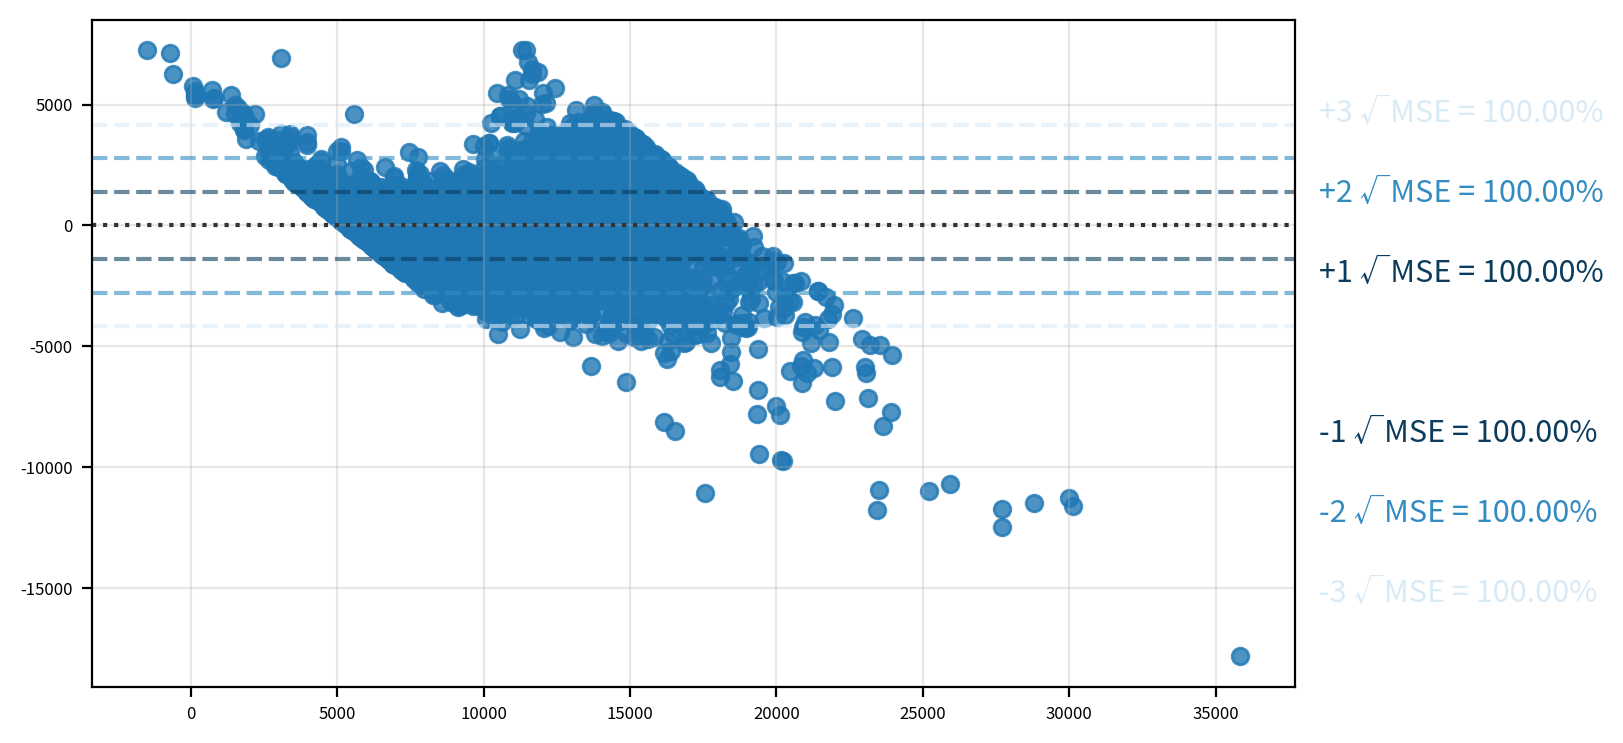

In [164]:
mse_sq = fit.mse_resid
mse_root = np.sqrt(mse_sq)
r = fit.resid

# 잔차
r1 = r[(r > -mse_sq) & (r < mse_sq)].count() / r.count() * 100
r2 = r[(r > -2 * mse_sq) & (r < 2 * mse_sq)].count() / r.count() * 100
r3 = r[(r > -3 * mse_sq) & (r < 3 * mse_sq)].count() / r.count() * 100

mse_r = [r1, r2, r3]
colors = ["#0B3C5D", "#328CC1", "#D9EAF7"]

print(f"루트 1MSE 구간에 포함된 잔차 비율: {r1:.2f}%")
print(f"루트 2MSE 구간에 포함된 잔차 비율: {r2:.2f}%")
print(f"루트 3MSE 구간에 포함된 잔차 비율: {r3:.2f}%")

xmax = fit.fittedvalues.max()
ymin = fit.fittedvalues.min()

width_px = 1600
height_px = 720
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=my_dpi, constrained_layout=True)

# 2) seaborn 기본 잔차도
sb.residplot(x=fit.fittedvalues, y=fit.resid)

ax.grid(True, alpha=0.3)

# 4) MSE 3단계 표시
for i, c in enumerate(colors):
    k = i + 1

    # 올바른 ±k√MSE 위치
    y_pos = k * mse_root
    ax.axhline(y=y_pos, color=c, linestyle="--", alpha=0.6)
    ax.axhline(y=-y_pos, color=c, linestyle="--", alpha=0.6)

    # 텍스트는 축 좌표계 사용(그래프 밖으로 안 나감)
    ax.text(
        x=1.02,
        y=0.5 + 0.12 * k,
        s=f"+{k} √MSE = {mse_r[i]:0.2f}%",
        transform=ax.transAxes,
        ha="left",
        va="center",
        fontsize=11,
        color=c,
    )
    ax.text(
        x=1.02,
        y=0.5 - 0.12 * k,
        s=f"-{k} √MSE = {mse_r[i]:0.2f}%",
        transform=ax.transAxes,
        ha="left",
        va="center",
        fontsize=11,
        color=c,
    )

plt.show()
plt.close()

In [165]:
print("===== 잔차의 정규성 검정 =====")

if len(origin) < 5000:
    method = "Shapiro-Wilk"
    stat, p = shapiro(fit.resid)
    print(f"{method} statistic: {stat:.4f}, p-value: {p:.4f}")
    violated = p < 0.05
else:
    method = "Anderson-Darling"
    ad_res = anderson(fit.resid, dist="norm")
    crit_levels = ad_res.significance_level.tolist()
    crit_values = ad_res.critical_values.tolist()
    crit_5 = crit_values[crit_levels.index(5.0)] if 5.0 in crit_levels else None
    print(f"{method} statistic: {ad_res.statistic:.4f}, 5% 임계값: {crit_5:.4f}")
    violated = crit_5 is not None and ad_res.statistic > crit_5

print(
    "정규성 가정 위배 가능성이 있음 (5% 유의수준)"
    if violated
    else "정규성 가정 위배 근거 없음 (5% 유의수준)"
)


print("\n===== 잔차의 등분산성  =====")
# Breusch-pegan Test
names = ["LM Statistic", "LM p-value", "F Statistic", "F p-value"]
bp_test = het_breuschpagan(fit.resid, fit.model.exog)
bp = DataFrame(bp_test, index=names, columns=["value"])

# p-value는 F p-value를 기준으로 사용
p_bp = bp.loc["F p-value", "value"]

print(
    f"Breusch–Pagan statistic: {bp.loc['F Statistic','value']:.3f}, p-value = {p_bp:.3f}"
)
print(f"{'이분산성 존재(등분산 아님)' if p_bp <= 0.05 else '등분산성 만족'}")


print(" \n===== 잔차의 독립성 =====")

dw = durbin_watson(fit.resid)

if 1.5 <= dw <= 2.5:
    interpretation = "잔차는 독립성을 만족함 (자기상관 없음)"
elif dw < 1.5:
    interpretation = "잔차에 양(+)의 자기상관이 존재할 가능성 있음 (독립성 위반)"
else:
    interpretation = "잔차에 음(–)의 자기상관이 존재할 가능성 있음 (독립성 위반)"

print(f"Durbin–Watson: {dw:.3f}")
print(interpretation)

print("\n ====== 결과 보고 ======")
m  # 모형 적합도
print("\n".join(v))

===== 잔차의 정규성 검정 =====
Anderson-Darling statistic: 173.9702, 5% 임계값: 0.7870
정규성 가정 위배 가능성이 있음 (5% 유의수준)

===== 잔차의 등분산성  =====
Breusch–Pagan statistic: 237.442, p-value = 0.000
이분산성 존재(등분산 아님)
 
===== 잔차의 독립성 =====
Durbin–Watson: 1.502
잔차는 독립성을 만족함 (자기상관 없음)

 ====== 결과 보고 ======
carat의 회귀계수는 1.117e+04(p <= 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
cut_Good의 회귀계수는 1004.8032(p <= 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
cut_Ideal의 회귀계수는 1763.7065(p <= 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
cut_Premium의 회귀계수는 1274.7875(p <= 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
cut_Very Good의 회귀계수는 1403.3683(p <= 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
color_E의 회귀계수는 -322.7884(p <= 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
color_F의 회귀계수는 -641.9237(p <= 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
color_G의 회귀계수는 -1475.9936(p <= 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
color_H의 회귀계수는 -2487.3536(p <= 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
color_I의 회귀계수는 -3504.3194(p <= 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
color